In [1]:
# =================== CELDA 0 — CONFIG & HELPERS (REFactor propuesta) ===================
import os, sys, random, warnings, pathlib
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore", category=FutureWarning)

################################################################################
# 1. Reproducibilidad total
################################################################################
def seed_everything(seed: int = 42):
    """
    Fija todas las semillas pseudoaleatorias que razonablemente controlamos:
    - Python `random`
    - Hash aleatorio de Python
    - NumPy
    - (opcional) PyTorch si está disponible
    
    Esto NO garantiza bitwise determinism en CUDA en todas las GPUs/drivers,
    pero elimina la aleatoriedad obvia de entrenamiento/inferencia.
    """
    import importlib

    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

    # PyTorch es opcional: sólo si está instalado
    if importlib.util.find_spec("torch") is not None:
        import torch
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.use_deterministic_algorithms(False)  # True = más lento pero más determinista
        # Nota: cudnn.benchmark=False hace que convs sean deterministas-ish
        if torch.backends.cudnn.is_available():
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False

SEED = 42
seed_everything(SEED)

################################################################################
# 2. Estilo "Nature-ready" para TODAS las figuras
################################################################################
def set_nature_style():
    """
    Ajusta parámetros globales de Matplotlib/Seaborn para figuras tipo Nature:
    - tipografía sans-serif editable en Illustrator (fonttype=42)
    - tamaños de fuente consistentes con 'context="paper"'
    - ejes sin spines top/right
    - ticks hacia afuera
    - DPI alto por defecto
    """
    sns.set_theme(style="white", context="paper")
    mpl.rcParams.update({
        # texto editable en Illustrator / Affinity
        "pdf.fonttype": 42,
        "ps.fonttype": 42,

        # tipografía
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial", "DejaVu Sans"],

        # tamaños (en pt aprox)
        "font.size": 9,
        "axes.titlesize": 10,
        "axes.labelsize": 9,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
        "legend.fontsize": 8,

        # estética de ejes
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.linewidth": 0.8,
        "xtick.major.width": 0.8,
        "ytick.major.width": 0.8,
        "xtick.direction": "out",
        "ytick.direction": "out",

        # salida
        "figure.dpi": 300,
        "savefig.pad_inches": 0.02,
    })

set_nature_style()

################################################################################
# 3. Rutas y parámetros globales de la corrida
################################################################################
# Nota: respetamos valores previos si ya existen en el workspace interactivo.
if 'N_FOLDS' not in globals():      N_FOLDS = 5
if 'CLF' not in globals():          CLF = 'mlp'
if 'SUFFIX' not in globals():       SUFFIX = '_integrated_gradients_top50'
if 'CHANNELS_TO_USE' not in globals(): CHANNELS_TO_USE = [1, 2, 5]

if 'BASE_RUN_DIR' not in globals():
    BASE_RUN_DIR = Path('./resultados_13_paper_qc_beta3')

FIG_DIR = Path('./Figures_Nature')
TBL_DIR = Path('./Tables_Nature')
FIG_DIR.mkdir(exist_ok=True, parents=True)
TBL_DIR.mkdir(exist_ok=True, parents=True)

# rutas del tensor y metadata crudos de sujetos
if 'GLOBAL_TENSOR_PATH' not in globals():
    GLOBAL_TENSOR_PATH = (
        '/home/diego/Escritorio/limpio/'
        'AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_'
        'AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/'
        'GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_'
        'AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz'
    )

if 'METADATA_PATH' not in globals():
    METADATA_PATH = '/home/diego/Escritorio/limpio/SubjectsData_AAL3_procesado2.csv'

# un diccionario "config snapshot" bonito para loggear/guardar en Supplementary
RUN_CFG = {
    "SEED": SEED,
    "N_FOLDS": N_FOLDS,
    "CLF": CLF,
    "SUFFIX": SUFFIX,
    "CHANNELS_TO_USE": CHANNELS_TO_USE,
    "BASE_RUN_DIR": str(BASE_RUN_DIR),
    "GLOBAL_TENSOR_PATH": GLOBAL_TENSOR_PATH,
    "METADATA_PATH": METADATA_PATH,
    "FIG_DIR": str(FIG_DIR),
    "TBL_DIR": str(TBL_DIR),
}

################################################################################
# 4. Helper para guardar figuras en alta resolución listas para el paper
################################################################################
def savefig_nature(fig: mpl.figure.Figure,
                   path_no_ext,
                   dpi_png: int = 600,
                   transparent_png: bool = False,
                   extra_meta: dict | None = None):
    """
    Guarda dos versiones de la figura:
      - PDF (vectorial, texto editable) -> para Illustrator / submission
      - PNG (alta resolución)           -> para borradores / slides / supl.
    
    Parámetros
    ----------
    fig : matplotlib.figure.Figure
        Figura a guardar.
    path_no_ext : str | Path
        Ruta base SIN extensión. Se crearán .pdf y .png.
    dpi_png : int
        DPI para la versión PNG.
    transparent_png : bool
        Si True, el fondo del PNG es transparente.
    extra_meta : dict or None
        Metadatos adicionales para incrustar en el PDF.
    """
    p = pathlib.Path(path_no_ext)
    p.parent.mkdir(parents=True, exist_ok=True)

    meta_pdf = {
        "Creator": "Matplotlib",
        "Title": p.name,
        "CreationDate": datetime.now(),
    }
    if extra_meta:
        meta_pdf.update(extra_meta)

    # PDF vectorial
    fig.savefig(
        p.with_suffix(".pdf"),
        metadata=meta_pdf,
        bbox_inches="tight"
    )

    # PNG alta resolución (útil para tener un snapshot rápido)
    fig.savefig(
        p.with_suffix(".png"),
        dpi=dpi_png,
        transparent=transparent_png,
        metadata={"Creator": "Matplotlib"},
        bbox_inches="tight"
    )

################################################################################
# 5. Log de estado
################################################################################
print(">> CONFIG INICIAL")
for k, v in RUN_CFG.items():
    print(f"   {k}: {v}")
print("✔️  Setup gráfico y helpers cargados.\n")


# --- Silenciar logs verbosos de fontTools / tqdm en guardados PDF/SVG ---
import logging, os
logging.getLogger('fontTools').setLevel(logging.WARNING)
logging.getLogger('fontTools.subset').setLevel(logging.WARNING)
os.environ.setdefault("TQDM_DISABLE", "1")  # evita el warning de IProgress si no usas ipywidgets

# SVG con texto editable (no convierte a paths)
mpl.rcParams['svg.fonttype'] = 'none'



>> CONFIG INICIAL
   SEED: 42
   N_FOLDS: 5
   CLF: mlp
   SUFFIX: _integrated_gradients_top50
   CHANNELS_TO_USE: [1, 2, 5]
   BASE_RUN_DIR: resultados_13_paper_qc_beta3
   GLOBAL_TENSOR_PATH: /home/diego/Escritorio/limpio/AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz
   METADATA_PATH: /home/diego/Escritorio/limpio/SubjectsData_AAL3_procesado2.csv
   FIG_DIR: Figures_Nature
   TBL_DIR: Tables_Nature
✔️  Setup gráfico y helpers cargados.



In [2]:
# === CARGA MAESTRA (usar una sola vez) ===
_npz = np.load(GLOBAL_TENSOR_PATH)
global_tensor_data = _npz["global_tensor_data"]              # [n_subj, 7, 131, 131]
subject_ids_all   = _npz["subject_ids"].astype(str)

meta = pd.read_csv(METADATA_PATH)
meta["SubjectID"] = meta["SubjectID"].astype(str).str.strip()

idx_df = pd.DataFrame({"SubjectID": subject_ids_all, "tensor_idx": np.arange(len(subject_ids_all))})
cnad_df = (idx_df.merge(meta, on="SubjectID", how="left")
                 .query("ResearchGroup_Mapped in ['CN','AD']").reset_index(drop=True))

print(f"✅ cnad_df listo: {cnad_df.shape[0]} sujetos AD/CN")


✅ cnad_df listo: 184 sujetos AD/CN


In [3]:
cnad_df = cnad_df.copy()

# Normalize Sex to {'M','F'} if it's encoded numeric or lowercase
if 'Sex' in cnad_df.columns:
    cnad_df['Sex'] = (
        cnad_df['Sex']
        .replace({0:'M', 1:'F', 'm':'M', 'f':'F'})
        .astype(str)
        .str.upper()
    )

# Make sure Age is numeric
if 'Age' in cnad_df.columns:
    cnad_df['Age'] = pd.to_numeric(cnad_df['Age'], errors='coerce')


In [4]:
# ===================================================================
# CELDA 1: CANALES (coherentes con tu CLI: --channels_to_use 1 2 5)
# ===================================================================
CHANNEL_CATALOG = {
    0: "Pearson_OMST_GCE_Signed_Weighted",
    1: "Pearson_Full_FisherZ_Signed",
    2: "MI_kNN_Symmetric",
    3: "dFC_AbsDiffMean",
    4: "dFC_StdDev",
    5: "DistanceCorr",
    6: "Granger_F_lag1",
}
CHANNELS_TO_USE = [1, 2, 5]
sel_names = [CHANNEL_CATALOG[c] for c in CHANNELS_TO_USE]
print("[Canales]", CHANNELS_TO_USE, "=>", sel_names)

# Para el paper: C debe ser 3 (no 4) y nombres como arriba.


[Canales] [1, 2, 5] => ['Pearson_Full_FisherZ_Signed', 'MI_kNN_Symmetric', 'DistanceCorr']


In [5]:
# ===================================================================
# CELDA 2 (UNIFICADA): CARGA DE RANKINGS Y CREACIÓN DE ID CANÓNICO
# ===================================================================
all_folds = []
for i in range(1, N_FOLDS + 1):
    path = BASE_RUN_DIR / f"fold_{i}/interpretability_{CLF}/ranking_conexiones_ANOTADO{SUFFIX}.csv"
    if not path.exists():
        print(f"⚠️ Falta fold {i}: {path}")
        continue
    df_i = pd.read_csv(path)
    
    # --- Lógica de la Celda 2bis integrada aquí ---
    # Crear un ID canónico (tupla ordenada) para cada conexión
    df_i["connection_id"] = [tuple(sorted(x)) for x in zip(df_i["src_AAL3_Name"], df_i["dst_AAL3_Name"])]
    df_i["fold"] = i
    all_folds.append(df_i)

if not all_folds:
    raise FileNotFoundError("No se encontró ningún ranking de conexiones.")

# Concatenar todos los dataframes en uno solo
df_full = pd.concat(all_folds, ignore_index=True)

# --- Verificación de la Celda 2bis integrada aquí ---
assert "connection_id" in df_full.columns
assert df_full["connection_id"].map(type).eq(tuple).all(), "La columna 'connection_id' DEBE ser una tupla."

print(f"✅ df_full cargado y preprocesado con {df_full['fold'].nunique()} folds y {len(df_full)} filas.")
print(f"   - Cada conexión tiene un 'connection_id' canónico.")

✅ df_full cargado y preprocesado con 5 folds y 42575 filas.
   - Cada conexión tiene un 'connection_id' canónico.


In [6]:
N = 131
E_undirected = N*(N-1)//2
E_directed = N*(N-1)
print(f"Undirected (sin diagonal): {E_undirected}  // Directed (sin diagonal): {E_directed}")

Undirected (sin diagonal): 8515  // Directed (sin diagonal): 17030


In [7]:
# ===================================================================
# CELDA 3 (UNIFICADA): ANÁLISIS DE ESTABILIDAD Y LATERALIDAD (CORREGIDA)
# ===================================================================
from collections import Counter
from scipy.stats import t

# --- 1. ESTABILIDAD: Cálculo de π (frecuencia) y τ (consistencia de signo) ---
TOP_K_STABILITY = 250
n_folds = df_full['fold'].nunique()
top_sets = df_full[df_full["Rank"] <= TOP_K_STABILITY].groupby("fold")["connection_id"].apply(set)

pi = pd.Series(Counter(e for s in top_sets for e in s)).div(n_folds)
pi.name = "pi"

# Use 'Saliency_Signed' which exists in your CSV files
sign = np.sign(df_full.set_index(["connection_id", "fold"])["Saliency_Signed"]).unstack() # <-- CORREGIDO
tau = sign.mean(axis=1).abs()
tau.name = "tau"

df_stability = pd.concat([pi, tau], axis=1).fillna({"pi": 0.0})
df_stability["Signed"] = df_stability["pi"] * df_stability["tau"]

# --- 2. CONSENSUS SET: Filtrado por umbrales estrictos ---
CONS_PI, CONS_TAU = 0.6, 0.6
consensus_set = df_stability.query("pi >= @CONS_PI and tau >= @CONS_TAU").sort_values("Signed", ascending=False)
print(f"🔎 Consensus Set: {len(consensus_set)} aristas (π ≥ {CONS_PI}, τ ≥ {CONS_TAU})")
display(consensus_set.head(10))

# --- 3. LATERALIDAD: Preparación de datos para la figura ---
midline_tokens = {'VER','VPL','PAG','NCR','tVPL','VER7','VER8','VER9'}
def hemi_of(roi: str) -> str:
    if not isinstance(roi, str): return 'U'
    if roi.endswith('R'): return 'R'
    if roi.endswith('L'): return 'L'
    base = ''.join([c for c in roi if not c.isdigit()])
    return 'M' if any(t in base for t in midline_tokens) else 'U'

df_full['hemi_src'] = df_full['src_AAL3_Name'].map(hemi_of)
df_full['hemi_dst'] = df_full['dst_AAL3_Name'].map(hemi_of)
df_lat_clean = df_full.query("hemi_src in ['L','R'] and hemi_dst in ['L','R']").copy()
print(f"\n✅ Conexiones de línea media filtradas para análisis de lateralidad: {len(df_lat_clean)} restantes.")

# ««« INICIO DE LA CORRECCIÓN »»»
# Usar la definición COMPLETA de la función, la que incluye RR y LL
def p_rr_by_fold(df: pd.DataFrame, K: int) -> pd.DataFrame:
    df_intra = df[df['hemi_src'] == df['hemi_dst']]
    top = df_intra[df_intra["Rank"] <= K]
    out = []
    for f, g in top.groupby("fold", observed=True):
        rr = (g["hemi_src"] == "R").sum()
        ll = (g["hemi_src"] == "L").sum()
        n  = rr + ll
        out.append({
            "fold": int(f), 
            "TopK": K, 
            "RR": rr,      # <-- Incluir RR
            "LL": ll,      # <-- Incluir LL
            "N": n,
            "p_RR": (rr / n) if n > 0 else np.nan
        })
    return pd.DataFrame(out)
# ««« FIN DE LA CORRECCIÓN »»»

df_lat_plot = pd.concat(
    [p_rr_by_fold(df_lat_clean, K) for K in (50, 100, 200)], 
    ignore_index=True
)
print("✅ DataFrame 'df_lat_plot' para figura de lateralidad creado exitosamente (con columnas RR y LL).")

🔎 Consensus Set: 6 aristas (π ≥ 0.6, τ ≥ 0.6)


pi  tau  Signed
PAR     VER7     0.6  1.0    0.60
CER3R   VER7     0.6  1.0    0.60
GAR     OFCLATR  0.8  0.6    0.48
T1AR    VER7     0.6  0.6    0.36
OFCLATR T3R      0.6  0.6    0.36
NLR     OFCMEDR  0.6  0.6    0.36


✅ Conexiones de línea media filtradas para análisis de lateralidad: 38130 restantes.
✅ DataFrame 'df_lat_plot' para figura de lateralidad creado exitosamente (con columnas RR y LL).


In [8]:
# ===================================================================
# CELDA 3.5 (CORREGIDA): ANÁLISIS DE ENRIQUECIMIENTO DE REDES (FDR)
# ===================================================================
import pandas as pd
import numpy as np
from scipy.stats import hypergeom
from statsmodels.stats.multitest import fdrcorrection
from itertools import combinations_with_replacement

print("--- Iniciando Análisis de Enriquecimiento de Redes (q-values) ---")

# --- 1. Definir Población (N) y Muestra (K) ---
# N = Población total = Total de aristas únicas posibles (calculado en Celda 2)
N_total_edges = 8515 

# K = Muestra = Total de aristas únicas Top-K (K=250) pooleadas entre 5 folds
TOP_K_STABILITY = 250 # De Celda 3
top_sets_per_fold = df_full[df_full["Rank"] <= TOP_K_STABILITY].groupby("fold")["connection_id"].apply(set)
pooled_top_K_set = set.union(*top_sets_per_fold)
K_sample_size = len(pooled_top_K_set)

print(f"N (Población Total de Aristas): {N_total_edges}")
print(f"K (Muestra = Aristas Top-{TOP_K_STABILITY} Únicas Pooleadas): {K_sample_size}")

# --- 2. Mapear todas las aristas a sus pares de redes canónicos ---
net_src_col = "src_Refined_Network" if "src_Refined_Network" in df_full.columns else "src_Yeo17_Network"
net_dst_col = "dst_Refined_Network" if "dst_Refined_Network" in df_full.columns else "dst_Yeo17_Network"

# Usamos df_full (que tiene todas las aristas) para este mapeo
all_edges_df = df_full.drop_duplicates('connection_id').copy()
all_edges_df['net_pair'] = [tuple(sorted(x)) for x in zip(all_edges_df[net_src_col], all_edges_df[net_dst_col])]

# --- 3. Calcular 'm' (éxitos en población) y 'k' (éxitos en muestra) ---

# m = Cuántas aristas totales existen en cada par de redes (población)
m_counts_pop = all_edges_df.groupby('net_pair').size().rename('m_Population')

# k = Cuántas aristas de la MUESTRA (Top-K) caen en cada par de redes
salient_edges_df = all_edges_df[all_edges_df.connection_id.isin(pooled_top_K_set)]
k_counts_sample = salient_edges_df.groupby('net_pair').size().rename('k_TopK_Hits')

# --- 4. Combinar y crear la tabla de contingencia ---
# Crear una tabla con todos los pares de redes posibles

# --- INICIO DE LA CORRECCIÓN ---
# La línea original 'all_networks = sorted(pd.unique(all_edges_df[net_src_col].dropna().append(all_edges_df[net_dst_col].dropna())))'
# es incorrecta. La forma correcta de combinar las series es con pd.concat.
all_networks_series = pd.concat([
    all_edges_df[net_src_col].dropna(), 
    all_edges_df[net_dst_col].dropna()
])
all_networks = sorted(pd.unique(all_networks_series))
# --- FIN DE LA CORRECCIÓN ---

all_possible_pairs_idx = pd.MultiIndex.from_tuples(
    [tuple(sorted(p)) for p in combinations_with_replacement(all_networks, 2)],
    names=['Net 1', 'Net 2']
)

m_counts_pop.index = pd.MultiIndex.from_tuples(m_counts_pop.index, names=['Net 1', 'Net 2'])
k_counts_sample.index = pd.MultiIndex.from_tuples(k_counts_sample.index, names=['Net 1', 'Net 2'])

# Combinar m y k
stats_df = pd.DataFrame(index=all_possible_pairs_idx).join(m_counts_pop).join(k_counts_sample)
stats_df = stats_df.fillna(0).astype(int).reset_index()
# Filtrar pares que no existen (m=0)
stats_df = stats_df.query('m_Population > 0').copy()

# --- 5. Test Hipergeométrico (p-value) y Corrección FDR (q-value) ---
# p-value = P(X >= k) = 1 - P(X <= k-1) = sf(k-1)
stats_df['p_value'] = stats_df.apply(
    lambda row: hypergeom.sf(row['k_TopK_Hits'] - 1, N_total_edges, row['m_Population'], K_sample_size),
    axis=1
)

# Corrección Benjamini-Hochberg (FDR)
# --- LÍNEA CORREGIDA ---
reject, q_values = fdrcorrection(stats_df['p_value'], alpha=0.05, method='indep')
stats_df['q_value_bh'] = q_values
stats_df['significant_q05'] = reject

# --- 6. Mostrar y Guardar Resultados ---
df_final_enrichment = stats_df.sort_values('p_value').reset_index(drop=True)
df_final_enrichment.to_csv(TBL_DIR / "Table_S_Enrichment.csv", index=False)
df_final_enrichment.head(15).to_latex(
    TBL_DIR / "Table_S_Enrichment.tex",
    index=False, float_format="%.2e", escape=False,
    columns=['Net 1', 'Net 2', 'k_TopK_Hits', 'm_Population', 'p_value', 'q_value_bh', 'significant_q05']
)

print(f"✅ Tabla de Enriquecimiento (q-values) guardada en:\n   {TBL_DIR / 'Table_S_Enrichment.csv'}")
print(f"✅ Fragmento LaTeX guardado en:\n   {TBL_DIR / 'Table_S_Enrichment.tex'}")
print("\n--- Top 15 Pares de Redes Más Enriquecidos (ordenados por p-value) ---")
display(df_final_enrichment.head(15))

--- Iniciando Análisis de Enriquecimiento de Redes (q-values) ---
N (Población Total de Aristas): 8515
K (Muestra = Aristas Top-250 Únicas Pooleadas): 1032
✅ Tabla de Enriquecimiento (q-values) guardada en:
   Tables_Nature/Table_S_Enrichment.csv
✅ Fragmento LaTeX guardado en:
   Tables_Nature/Table_S_Enrichment.tex

--- Top 15 Pares de Redes Más Enriquecidos (ordenados por p-value) ---


Net 1                      Net 2  m_Population  \
0      Background/NonCortical          Visual_Peripheral           182   
1      Background/NonCortical          Limbic_A_TempPole           140   
2           Visual_Peripheral          Visual_Peripheral            78   
3               Somatomotor_B          Visual_Peripheral            65   
4   DefaultMode_VentralMedial          Limbic_A_TempPole            60   
5      Background/NonCortical     Background/NonCortical            91   
6           Limbic_A_TempPole          Visual_Peripheral           130   
7                  Cerebellum              Somatomotor_B            55   
8                  Cerebellum  DefaultMode_VentralMedial            66   
9   DefaultMode_VentralMedial          Visual_Peripheral            78   
10     Background/NonCortical             Visual_Central           126   
11          Limbic_A_TempPole              Somatomotor_B            50   
12                 Cerebellum          Limbic_A_TempPole           110   
13                 Cerebellum          Visual_Peripheral           143   
14              Somatomotor_B              Somatomotor_B            10   

    k_TopK_Hits   p_value  q_value_bh  significant_q05  
0            45  0.000002    0.000335             True  
1            34  0.000045    0.004608             True  
2            22  0.000096    0.006608             True  
3            18  0.000517    0.022734             True  
4            17  0.000549    0.022734             True  
5            22  0.001013    0.034946             True  
6            28  0.001573    0.040612             True  
7            15  0.001750    0.040612             True  
8            17  0.001766    0.040612             True  
9            19  0.001984    0.041063             True  
10           26  0.004216    0.079329            False  
11           13  0.005428    0.093634            False  
12           22  0.011665    0.179354            False  
13           27  0.012130    0.179354            False  
14            4  0.024678    0.325802            False

In [9]:
run_args = {
    "channels_to_use": [1, 2, 5],
    "latent_dim": 256,
    "num_conv_layers_encoder": 4,
    "decoder_type": "convtranspose",
    "vae_final_activation": "tanh",
    "intermediate_fc_dim_vae": "quarter",
    "dropout_rate_vae": 0.2,
    "use_layernorm_vae_fc": False,
    "metadata_features": ["Age", "Sex"],
}
print("✅ run_args reconstruido:", run_args)


✅ run_args reconstruido: {'channels_to_use': [1, 2, 5], 'latent_dim': 256, 'num_conv_layers_encoder': 4, 'decoder_type': 'convtranspose', 'vae_final_activation': 'tanh', 'intermediate_fc_dim_vae': 'quarter', 'dropout_rate_vae': 0.2, 'use_layernorm_vae_fc': False, 'metadata_features': ['Age', 'Sex']}


In [10]:
import torch, joblib
import numpy as np, pandas as pd
from pathlib import Path
from sklearn.metrics import (
    roc_curve, roc_auc_score, brier_score_loss,
    accuracy_score, recall_score, average_precision_score
)
from sklearn.calibration import calibration_curve
from scipy.stats import t
import matplotlib.pyplot as plt

from serentipia9_qc_beta import apply_normalization_params
from models.convolutional_vae2 import ConvolutionalVAE

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- sanity ---
assert 'cnad_df' in globals()
assert 'run_args' in globals()
assert 'CHANNELS_TO_USE' in globals()
assert 'N_FOLDS' in globals() and 'CLF' in globals()
assert 'global_tensor_data' in globals() or 'GLOBAL_TENSOR_PATH' in globals()



# 1. índices train/test por fold
fold_indices = {}
all_indices = np.arange(len(cnad_df))
for f in range(1, N_FOLDS + 1):
    test_idx_path = BASE_RUN_DIR / f"fold_{f}" / "test_indices.npy"
    test_idx = np.load(test_idx_path)
    train_idx = np.setdiff1d(all_indices, test_idx, assume_unique=True)
    fold_indices[f] = {'train': train_idx, 'test': test_idx}

perf_rows = []

for f in range(1, N_FOLDS + 1):
    fold_dir = BASE_RUN_DIR / f"fold_{f}"

    # clasificador entrenado en ese fold
    pipe = joblib.load(fold_dir / f"classifier_{CLF}_pipeline_fold_{f}.joblib")

    # VAE del fold
    vae_model = ConvolutionalVAE(
        input_channels=len(run_args['channels_to_use']),
        latent_dim=run_args['latent_dim'],
        image_size=global_tensor_data.shape[-1],  # 131
        num_conv_layers_encoder=run_args['num_conv_layers_encoder'],
        decoder_type=run_args['decoder_type'],
        final_activation=run_args['vae_final_activation'],
        intermediate_fc_dim_config=run_args['intermediate_fc_dim_vae'],
        dropout_rate=run_args['dropout_rate_vae'],
        use_layernorm_fc=run_args['use_layernorm_vae_fc']
    ).to(device)

    vae_model.load_state_dict(
        torch.load(fold_dir / f"vae_model_fold_{f}.pt", map_location=device)
    )
    vae_model.eval()

    norm_params = joblib.load(fold_dir / "vae_norm_params.joblib")

    train_idx_fold = fold_indices[f]['train']
    test_idx_fold  = fold_indices[f]['test']

    df_train_fold = cnad_df.iloc[train_idx_fold].copy()
    df_test_fold  = cnad_df.iloc[test_idx_fold].copy()

    # etiquetas reales AD=1 / CN=0
    y_true_fold = df_test_fold['ResearchGroup_Mapped'].map({'CN':0,'AD':1}).values

    # ----- paso tensor -> normalización -> mu(latente) -----
    gidx_test = df_test_fold['tensor_idx'].values
    tensor_test_orig = global_tensor_data[gidx_test][:, CHANNELS_TO_USE, :, :]
    tensor_test_norm = apply_normalization_params(tensor_test_orig, norm_params)

    with torch.no_grad():
        tensor_torch = torch.from_numpy(tensor_test_norm).float().to(device)
        mu, _ = vae_model.encode(tensor_torch)    # mean latent code
        X_latent_test = mu.cpu().numpy()

    # ----- metadata (Age, Sex, etc) con imputación aprendida en TRAIN -----
    meta_cols = run_args['metadata_features']  # ej ['Age','Sex']
    # aprender imputación usando SOLO train
    metadata_train = df_train_fold[meta_cols].copy()
    if 'Sex' in metadata_train.columns:
        metadata_train['Sex'] = metadata_train['Sex'].map({'M':0,'F':1,'m':0,'f':1})

    imputation_values = {}
    for col in meta_cols:
        if metadata_train[col].isnull().any():
            if pd.api.types.is_numeric_dtype(metadata_train[col]) and metadata_train[col].nunique() > 2:
                imputation_values[col] = metadata_train[col].mean()
            else:
                imputation_values[col] = metadata_train[col].mode().iloc[0]
        else:
            imputation_values[col] = None

    metadata_test = df_test_fold[meta_cols].copy()
    if 'Sex' in metadata_test.columns:
        metadata_test['Sex'] = metadata_test['Sex'].map({'M':0,'F':1,'m':0,'f':1})

    for col, val in imputation_values.items():
        if val is not None:
            metadata_test[col].fillna(val, inplace=True)
        if metadata_test[col].isnull().any():
            metadata_test[col].fillna(-1, inplace=True)  # fallback

    # ----- concatenar latente + metadata -----
    X_test_combined = np.hstack([X_latent_test, metadata_test[meta_cols].values])

    # sanity de dimensiones
    expected_features = pipe.named_steps['scaler'].n_features_in_
    assert X_test_combined.shape[1] == expected_features, \
        f"Fold {f}: shape mismatch ({X_test_combined.shape[1]} vs {expected_features})"

    # ----- inferencia -----
    y_prob_fold = pipe.predict_proba(X_test_combined)[:,1]
    y_pred_fold = (y_prob_fold >= 0.5).astype(int)

    perf_rows.append(pd.DataFrame({
        'fold': f,
        'SubjectID': df_test_fold['SubjectID'].values,
        'tensor_idx': gidx_test,
        'y_true': y_true_fold,
        'y_prob': y_prob_fold,
        'y_pred': y_pred_fold
    }))

# juntamos
perf_df = pd.concat(perf_rows, ignore_index=True)

# métricas por fold
metrics_list = []
for f, g in perf_df.groupby('fold'):
    y_true_f = g['y_true'].astype(int).to_numpy()
    y_prob_f = g['y_prob'].astype(float).to_numpy()
    y_hat_f  = (y_prob_f >= 0.5).astype(int)

    auc_f    = roc_auc_score(y_true_f, y_prob_f) if np.unique(y_true_f).size>1 else np.nan
    pr_auc_f = average_precision_score(y_true_f, y_prob_f) if np.unique(y_true_f).size>1 else np.nan
    acc_f    = accuracy_score(y_true_f, y_hat_f)
    brier_f  = brier_score_loss(y_true_f, y_prob_f)
    sens_f   = recall_score(y_true_f, y_hat_f, pos_label=1, zero_division=0)
    spec_f   = recall_score(y_true_f, y_hat_f, pos_label=0, zero_division=0)

    metrics_list.append({
        "fold": f,
        "AUC": auc_f,
        "PR-AUC": pr_auc_f,
        "Accuracy": acc_f,
        "Brier": brier_f,
        "Sensitivity_AD": sens_f,
        "Specificity_CN": spec_f,
        "N_test": len(g),
    })

metrics_by_fold = pd.DataFrame(metrics_list).sort_values("fold").reset_index(drop=True)

# fila resumen mean ± sd
def _mean_sd_str(x):
    x = np.asarray(x, dtype=float)
    mean = np.nanmean(x)
    std = np.nanstd(x, ddof=1)
    return f"{mean:.3f} ± {std:.3f}" if not np.isnan(mean) else "N/A"

summary_row = {
    "fold": "mean±sd",
    "AUC": _mean_sd_str(metrics_by_fold["AUC"]),
    "PR-AUC": _mean_sd_str(metrics_by_fold["PR-AUC"]),
    "Accuracy": _mean_sd_str(metrics_by_fold["Accuracy"]),
    "Brier": _mean_sd_str(metrics_by_fold["Brier"]),
    "Sensitivity_AD": _mean_sd_str(metrics_by_fold["Sensitivity_AD"]),
    "Specificity_CN": _mean_sd_str(metrics_by_fold["Specificity_CN"]),
    "N_test": int(metrics_by_fold["N_test"].mean()),
}
table1_export = pd.concat([metrics_by_fold, pd.DataFrame([summary_row])], ignore_index=True)

# guardar tabla
table1_csv_path = TBL_DIR / "Table1_performance_byfold.csv"
table1_export.to_csv(table1_csv_path, index=False)

/home/diego/anaconda3/envs/serentipia_gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[INFO] [cuML] ➜ no disponible
[INFO] Usando dispositivo: cuda


¿GPU visible?: True
torch.cuda.is_available -> True
torch.version.cuda      -> 12.1
cupy GPU visible        -> True
¿GPU visible?: True


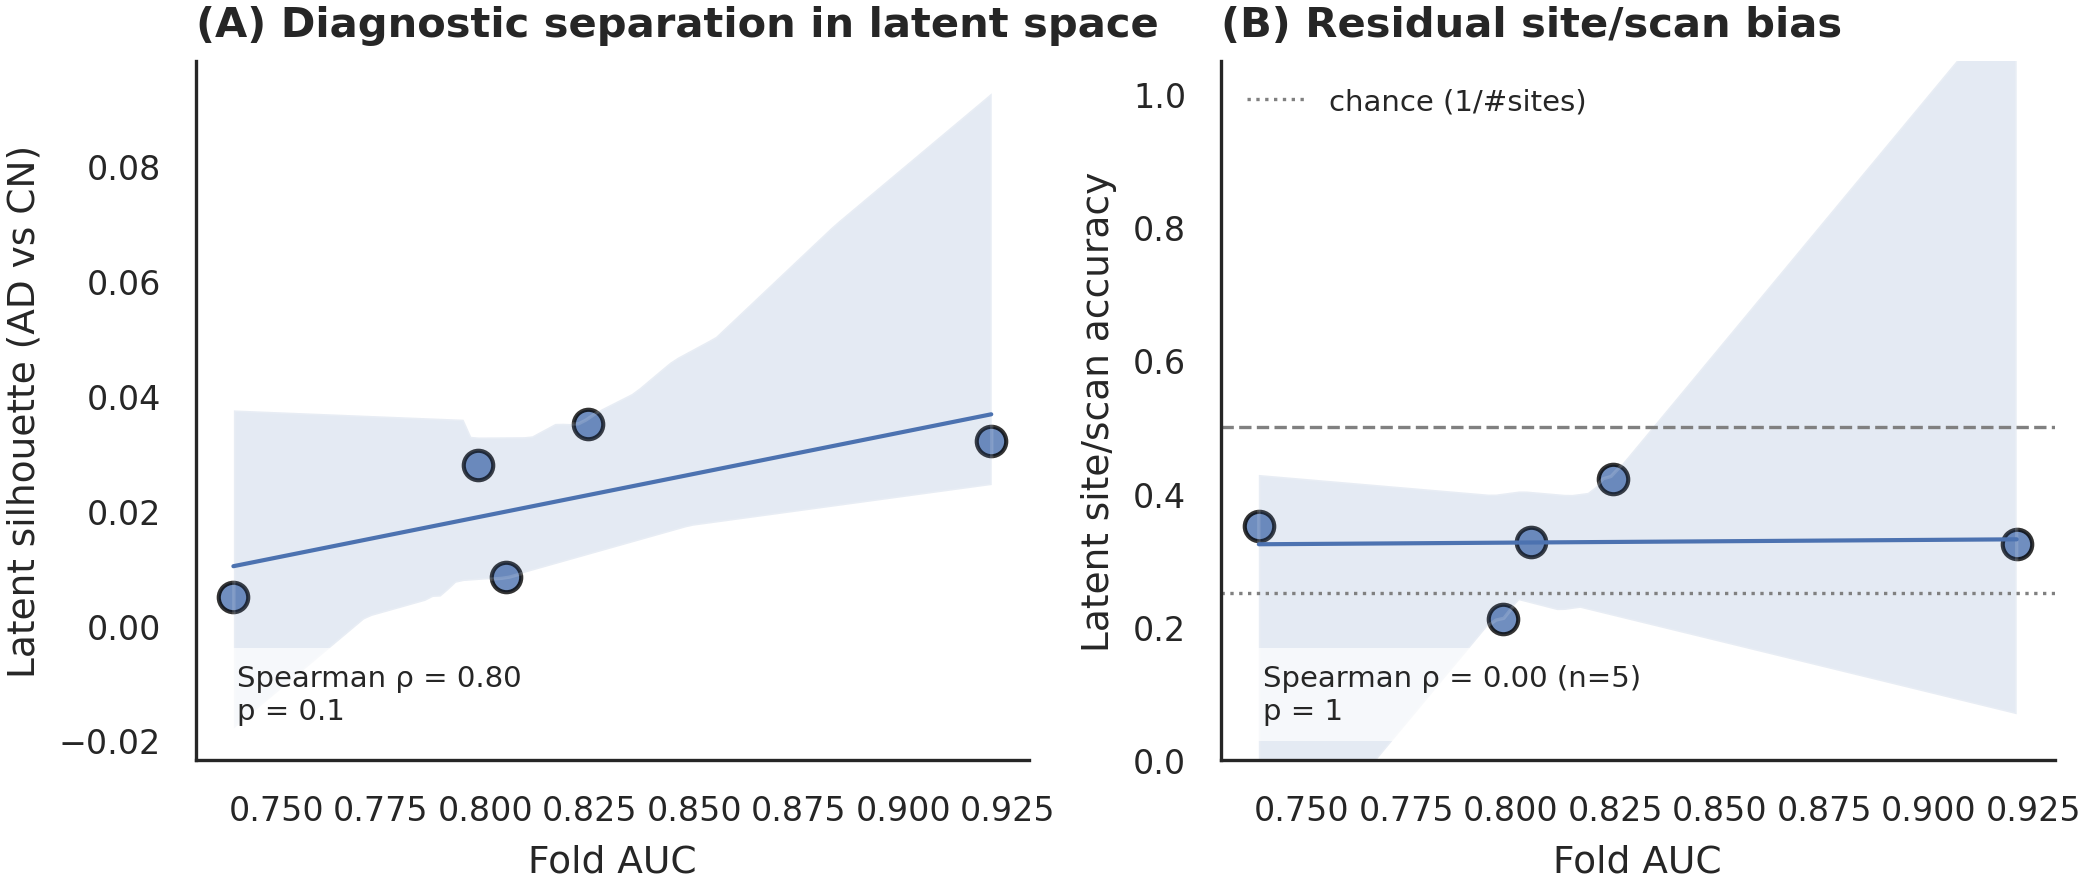

✅ Fig 2A-2B guardada en alta resolución.
   fold       AUC  silhouette_latent  acc_site_latent  acc_site_raw  n_sites  \
0     1  0.921053           0.032217         0.323718      0.314103        4   
1     2  0.739766           0.004955         0.350733      0.221841        4   
2     3  0.824561           0.035064         0.422123      0.283234        4   
3     4  0.798246           0.027961         0.211538      0.312500        4   
4     5  0.804954           0.008370         0.326885      0.349206        4   

   chance_level  latent_dim  beta_max   decoder_type  num_conv_layers  \
0          0.25         256       6.6  convtranspose                4   
1          0.25         256       6.6  convtranspose                4   
2          0.25         256       6.6  convtranspose                4   
3          0.25         256       6.6  convtranspose                4   
4          0.25         256       6.6  convtranspose                4   

        norm_mode                      

In [11]:
# ============================================================
# CELDA B — DISENTANGLEMENT / QC LATENTE (Fig 2A-2B)
# ============================================================
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.stats import spearmanr

assert 'metrics_by_fold' in globals(), "Corre Celda A primero (metrics_by_fold)."

def _standardize_qc_cols(df_in: pd.DataFrame) -> pd.DataFrame:
    """Mapea columnas heterogéneas a nombres estándar:
       - silhouette_latent
       - acc_site_latent
       - acc_site_raw
       - n_sites
    """
    df = df_in.copy()
    colmap = {}

    # silhouette_latent
    if 'silhouette_latent' not in df.columns:
        for c in df.columns:
            cl = c.lower()
            if 'silhouette' in cl and ('latent' in cl or 'zspace' in cl or 'mu' in cl):
                colmap[c] = 'silhouette_latent'
                break

    # acc_site_latent
    if 'acc_site_latent' not in df.columns:
        for c in df.columns:
            cl = c.lower()
            if ('acc' in cl or 'accuracy' in cl) and ('site' in cl or 'scanner' in cl) and ('latent' in cl or 'mu' in cl or 'z' in cl):
                colmap[c] = 'acc_site_latent'
                break
        if 'site_leak_latent_acc' in df.columns:
            colmap['site_leak_latent_acc'] = 'acc_site_latent'

    # acc_site_raw
    if 'acc_site_raw' not in df.columns:
        for c in df.columns:
            cl = c.lower()
            if ('acc' in cl or 'accuracy' in cl) and ('site' in cl or 'scanner' in cl) and ('raw' in cl or 'orig' in cl or 'pre' in cl):
                colmap[c] = 'acc_site_raw'
                break

    # n_sites
    if 'n_sites' not in df.columns:
        for c in df.columns:
            cl = c.lower()
            if 'n_sites' in cl or ('sites' in cl and ('n_' in cl or 'num' in cl or 'count' in cl)):
                colmap[c] = 'n_sites'
                break
            if cl in ['n_sites_test','num_sites_test','site_count_test']:
                colmap[c] = 'n_sites'
                break

    df = df.rename(columns=colmap)
    return df

def _load_fold_qc(fold: int) -> pd.DataFrame:
    qc_dir = BASE_RUN_DIR / f"fold_{fold}"
    # Candidatos explícitos:
    qc_candidates = [
        qc_dir / "latent_qc_metrics.csv",
        qc_dir / "qc_latent_metrics.csv",
        qc_dir / f"latent_qc_fold_{fold}.csv",
        qc_dir / f"{CLF}_latent_qc_metrics.csv",
    ]
    # También glob por si cambió el nombre
    qc_candidates.extend(list(qc_dir.glob("*latent*qc*.csv")))
    qc_candidates.extend(list(qc_dir.glob("*qc*latent*.csv")))

    for p in qc_candidates:
        if p.exists():
            tmp = pd.read_csv(p)
            tmp['fold'] = fold
            return _standardize_qc_cols(tmp)

    print(f"⚠️ No encontré QC latente para fold {fold}")
    return pd.DataFrame({"fold":[fold]})

qc_rows = []
for f in range(1, N_FOLDS + 1):
    qc_rows.append(_load_fold_qc(f))
df_qc_all = pd.concat(qc_rows, ignore_index=True)

# merge con AUC por fold
df_qc_summary = pd.merge(
    metrics_by_fold[['fold','AUC']],
    df_qc_all,
    how='left',
    on='fold'
)

# chance-level para predecir sitio = 1 / (#sites)
if 'n_sites' in df_qc_summary.columns:
    df_qc_summary['chance_level'] = 1.0 / df_qc_summary['n_sites'].replace(0, np.nan)
else:
    df_qc_summary['chance_level'] = np.nan

# === FIG 2: si faltan métricas QC, no crashea y lo indica en la figura ===
fig, axs = plt.subplots(1, 2, figsize=(7,3), constrained_layout=True)

# Panel 2A
if 'silhouette_latent' in df_qc_summary.columns and df_qc_summary['silhouette_latent'].notna().any():
    sns.regplot(data=df_qc_summary, x="AUC", y="silhouette_latent",
                ax=axs[0], scatter_kws={"s":50,"edgecolor":"black","alpha":0.8}, line_kws={"lw":1})
    from scipy.stats import spearmanr
    rho_sil, p_sil = spearmanr(df_qc_summary["AUC"], df_qc_summary["silhouette_latent"], nan_policy='omit')
    axs[0].text(0.05, 0.05, f"Spearman ρ = {rho_sil:.2f}\np = {p_sil:.2g}",
                transform=axs[0].transAxes, fontsize=7, va='bottom', ha='left',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    axs[0].set_ylabel("Latent silhouette (AD vs CN)")
else:
    axs[0].text(0.5,0.5,"silhouette_latent\nn/a",ha='center',va='center', color='grey')
    axs[0].set_axis_off()

axs[0].set_title("(A) Diagnostic separation in latent space", loc='left', weight='bold')
axs[0].set_xlabel("Fold AUC")

# Panel 2B
y_label = "Latent site/scan accuracy"  # evita NameError si cambiás el texto luego
have_acc = 'acc_site_latent' in df_qc_summary.columns and df_qc_summary['acc_site_latent'].notna().any()

if have_acc:
    df_tmp = df_qc_summary[['AUC', 'acc_site_latent', 'chance_level']].copy()
    df_tmp = df_tmp.dropna(subset=['AUC', 'acc_site_latent'])

    sns.regplot(
        data=df_tmp, x="AUC", y="acc_site_latent",
        ax=axs[1],
        scatter_kws={"s":50, "edgecolor":"black", "alpha":0.8},
        line_kws={"lw":1}
    )

    # Líneas de referencia
    axs[1].axhline(0.5, ls="--", c="gray", lw=0.8)
    if 'chance_level' in df_tmp.columns and df_tmp['chance_level'].notna().any():
        ch = float(np.nanmean(df_tmp['chance_level']))
        axs[1].axhline(ch, ls=":", c="gray", lw=0.8, label='chance (1/#sites)')
        axs[1].legend(frameon=False, fontsize=7)

    # Spearman con n efectivo
    rho_leak, p_leak = spearmanr(df_tmp["AUC"], df_tmp["acc_site_latent"])
    n_eff = len(df_tmp)
    axs[1].text(
        0.05, 0.05,
        f"Spearman ρ = {rho_leak:.2f} (n={n_eff})\np = {p_leak:.2g}",
        transform=axs[1].transAxes, fontsize=7, va='bottom', ha='left',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
    )

    axs[1].set_ylabel(y_label)
    axs[1].set_ylim(0, 1.05)
else:
    axs[1].text(0.5, 0.5, "acc_site_latent\nn/a", ha='center', va='center', color='grey')
    axs[1].set_axis_off()

axs[1].set_title("(B) Residual site/scan bias", loc='left', weight='bold')
axs[1].set_xlabel("Fold AUC")


savefig_nature(fig, FIG_DIR / "fig2_disentangle_auc_vs_qc")
plt.show()

print("✅ Fig 2A-2B guardada en alta resolución.")
print(df_qc_summary)



In [12]:
# === CONSENSUS SWEEP hacia ~11 aristas ===
import numpy as np, pandas as pd
from collections import Counter

#TOP_K_STABILITY = 250     # el mismo K que ya usaste
TARGET_N = 11             # objetivo: ~11 aristas para tabla/figura
PI_GRID  = np.arange(0.50, 0.91, 0.05)
TAU_GRID = np.arange(0.50, 0.91, 0.05)

assert 'df_full' in globals(), "Cargá df_full antes (ranking_conexiones_ANOTADO...)."

n_folds = df_full['fold'].nunique()
top_sets = df_full[df_full["Rank"] <= TOP_K_STABILITY].groupby("fold")["connection_id"].apply(set)
pi = pd.Series(Counter(e for s in top_sets for e in s)).div(n_folds); pi.name = "pi"

sign = np.sign(df_full.set_index(["connection_id","fold"])["Saliency_Signed"]).unstack()
tau = sign.mean(axis=1).abs(); tau.name = "tau"

df_stab = pd.concat([pi, tau], axis=1).fillna({"pi": 0.0})
df_stab["Signed"] = df_stab["pi"] * df_stab["tau"]

cands = []
for p in PI_GRID:
    for t in TAU_GRID:
        n = int((df_stab.query("pi >= @p and tau >= @t")).shape[0])
        cands.append((p, t, n, abs(n - TARGET_N)))
p_best, t_best, n_best, _ = sorted(cands, key=lambda x: (x[3], -x[2], -x[0], -x[1]))[0]

consensus_set = (df_stab.query("pi >= @p_best and tau >= @t_best")
                           .sort_values("Signed", ascending=False))
print(f"✅ Consenso: π≥{p_best:.2f}, τ≥{t_best:.2f} → {len(consensus_set)} aristas (target {TARGET_N})")

# ==== Export a LaTeX (filas) ====
# Map ROI→red (refined si está, sino Yeo17)
net_src_col = 'src_Refined_Network' if 'src_Refined_Network' in df_full.columns else 'src_Yeo17_Network'
net_dst_col = 'dst_Refined_Network' if 'dst_Refined_Network' in df_full.columns else 'dst_Yeo17_Network'

roi2net = {}
for _, r in df_full[['src_AAL3_Name', net_src_col]].dropna().drop_duplicates().iterrows():
    roi2net[r['src_AAL3_Name']] = r[net_src_col]
for _, r in df_full[['dst_AAL3_Name', net_dst_col]].dropna().drop_duplicates().iterrows():
    roi2net.setdefault(r['dst_AAL3_Name'], r[net_dst_col])

def _tex_escape(s): return str(s).replace('_', r'\_')

rows = []
for (a,b), r in consensus_set.iloc[:max(TARGET_N, len(consensus_set))].iterrows():
    rows.append(f"{_tex_escape(a)} & {_tex_escape(b)} & "
                f"{_tex_escape(roi2net.get(a,''))}—{_tex_escape(roi2net.get(b,''))} & "
                f"{r['pi']:.2f} & {r['tau']:.2f} \\\\")

Path('Tables_Nature').mkdir(parents=True, exist_ok=True)
out_path = Path('Tables_Nature/consensus_edges.tex')
out_path.write_text("\n".join(rows), encoding='utf-8')
print(f"✅ LaTeX (filas) → {out_path.resolve()}")


✅ Consenso: π≥0.55, τ≥0.55 → 6 aristas (target 11)
✅ LaTeX (filas) → /home/diego/Escritorio/limpio/Tables_Nature/consensus_edges.tex


In [13]:
# ===================================================================
# CELDA REEMPLAZO: Saliencia (media) vs. Cambio de Conectividad (Cohen's d real)
# ===================================================================
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from scipy.stats import spearmanr

# --- Utilidad estable para d de Cohen (AD - CN) ---
def cohen_d(ad, cn, eps=1e-9):
    ad, cn = np.asarray(ad), np.asarray(cn)
    nx, ny = ad.size, cn.size
    if nx < 2 or ny < 2:
        return np.nan
    dof = nx + ny - 2
    s_ad = np.var(ad, ddof=1)
    s_cn = np.var(cn, ddof=1)
    pooled = np.sqrt(((nx - 1) * s_ad + (ny - 1) * s_cn) / max(dof, 1))
    if pooled < eps:
        return 0.0
    return (np.mean(ad) - np.mean(cn)) / pooled

# --- Carga de tensor y metadatos (usa tus rutas ya definidas) ---
npz = np.load(GLOBAL_TENSOR_PATH)
# Filtrar a canales seleccionados y mantener orden de sujetos del NPZ
tensor_all = npz["global_tensor_data"][:, CHANNELS_TO_USE, :, :]  # [n_subj, n_chan_sel, R, R]
subj_all_ids = pd.Series(npz["subject_ids"].astype(str), name="SubjectID")

meta = pd.read_csv(METADATA_PATH)
meta["SubjectID"] = meta["SubjectID"].astype(str).str.strip()

# DataFrame maestro alineado al NPZ
idx_df = pd.DataFrame({"SubjectID": subj_all_ids, "tensor_idx": np.arange(len(subj_all_ids))})
merged = idx_df.merge(meta, on="SubjectID", how="left")
cnad_df = merged[merged["ResearchGroup_Mapped"].isin(["CN", "AD"])].reset_index(drop=True)

# --- Conjunto de conexiones a evaluar y su (idx_i, idx_j) canónico ---
if not {"idx_i", "idx_j"}.issubset(df_full.columns):
    raise KeyError("df_full debe contener columnas 'idx_i' e 'idx_j' para mapear ROIs.")

conn_map = (
    df_full[["connection_id", "idx_i", "idx_j"]]
    .drop_duplicates("connection_id")
    .set_index("connection_id")
    .astype(int)
)

# --- d de Cohen por fold en TEST y promedio entre folds ---
N_FOLDS_FOUND = df_full["fold"].nunique()
cohen_per_fold = []

for f in range(1, N_FOLDS_FOUND + 1):
    test_idx_path = BASE_RUN_DIR / f"fold_{f}" / "test_indices.npy"
    if not test_idx_path.exists():
        print(f"⚠️ Falta test_indices en fold {f}: {test_idx_path}. Se omite este fold.")
        continue

    test_indices_in_cnad = np.load(test_idx_path)  # índices sobre cnad_df
    test_df = cnad_df.iloc[test_indices_in_cnad]

    ad_idx = test_df[test_df["ResearchGroup_Mapped"] == "AD"]["tensor_idx"].to_numpy()
    cn_idx = test_df[test_df["ResearchGroup_Mapped"] == "CN"]["tensor_idx"].to_numpy()

    if len(ad_idx) < 2 or len(cn_idx) < 2:
        print(f"⚠️ Muy pocos sujetos en test para fold {f}. Se omite.")
        continue

    rows = []
    for conn, (i, j) in conn_map.iterrows():
        # valor de conectividad por sujeto (promedio sobre canales seleccionados)
        # shape: [n_subj]
        vals_all = tensor_all[:, :, i, j].mean(axis=1)
        dval = cohen_d(vals_all[ad_idx], vals_all[cn_idx])
        rows.append((conn, dval))

    df_fold_d = pd.DataFrame(rows, columns=["connection_id", f"cohen_d_fold_{f}"]).set_index("connection_id")
    cohen_per_fold.append(df_fold_d)

if not cohen_per_fold:
    raise RuntimeError("No se pudo calcular Cohen's d en ningún fold (revisa test_indices.npy y metadatos).")

df_cohen_all = pd.concat(cohen_per_fold, axis=1)

# Promedio (ignorando NaNs si algún fold faltó) y dispersión por si quieres reportarla
df_cohen_all["mean_cohen_d"] = df_cohen_all.mean(axis=1, skipna=True)
df_cohen_all["std_cohen_d"]  = df_cohen_all.std(axis=1,  skipna=True)

# --- Saliencia media entre folds (para el eje Y del plot) ---
df_mean_saliency = df_full.groupby("connection_id")["Saliency_Signed"].mean().rename("mean_saliency") # <-- CORREGIDO

# --- Merge para análisis (y filtro al consensus set) ---
df_analysis = pd.concat([df_mean_saliency, df_cohen_all["mean_cohen_d"]], axis=1).dropna()
df_consensus_analysis = df_analysis.loc[df_analysis.index.intersection(consensus_set.index)].copy()
df_consensus_analysis["conn_str"] = df_consensus_analysis.index.map(lambda t: f"{t[0]}—{t[1]}")

# --- Correlación (opcional, magnitudes) ---
rho, pval = spearmanr(df_consensus_analysis["mean_saliency"].abs(),
                      df_consensus_analysis["mean_cohen_d"].abs())

In [14]:
# ===================================================================
# CELDA CORREGIDA: CONTRIBUCIÓN POR CANAL (PROMEDIADO ENTRE FOLDS)
# ===================================================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# --- Configuración de rutas ---
BASE_RUN_DIR = Path('./resultados_13_paper_qc_beta3')
CLF = 'mlp'
SUFFIX = '_integrated_gradients_top50'
N_FOLDS = 5

# --- Recolectar datos de todos los folds ---
channel_contributions_rows = []
files_found = 0
for i in range(1, N_FOLDS + 1):
    file_path = BASE_RUN_DIR / f'fold_{i}/interpretability_{CLF}/channel_contributions{SUFFIX}.csv'
    if file_path.exists():
        df_contribution = pd.read_csv(file_path)
        df_contribution['fold'] = i
        channel_contributions_rows.append(df_contribution)
        files_found += 1
    else:
        print(f"⚠️ Advertencia: No se encontró el archivo para el fold {i} en: {file_path}")

# --- Proceder solo si se encontraron archivos ---
if channel_contributions_rows:
    df_contributions_all_folds = pd.concat(channel_contributions_rows, ignore_index=True)
    print(f"\n✅ Se cargaron datos de contribución de canales de {files_found} folds.")

else:
    print("\n❌ No se encontraron archivos de contribución de canales. No se puede generar el gráfico.")


✅ Se cargaron datos de contribución de canales de 5 folds.


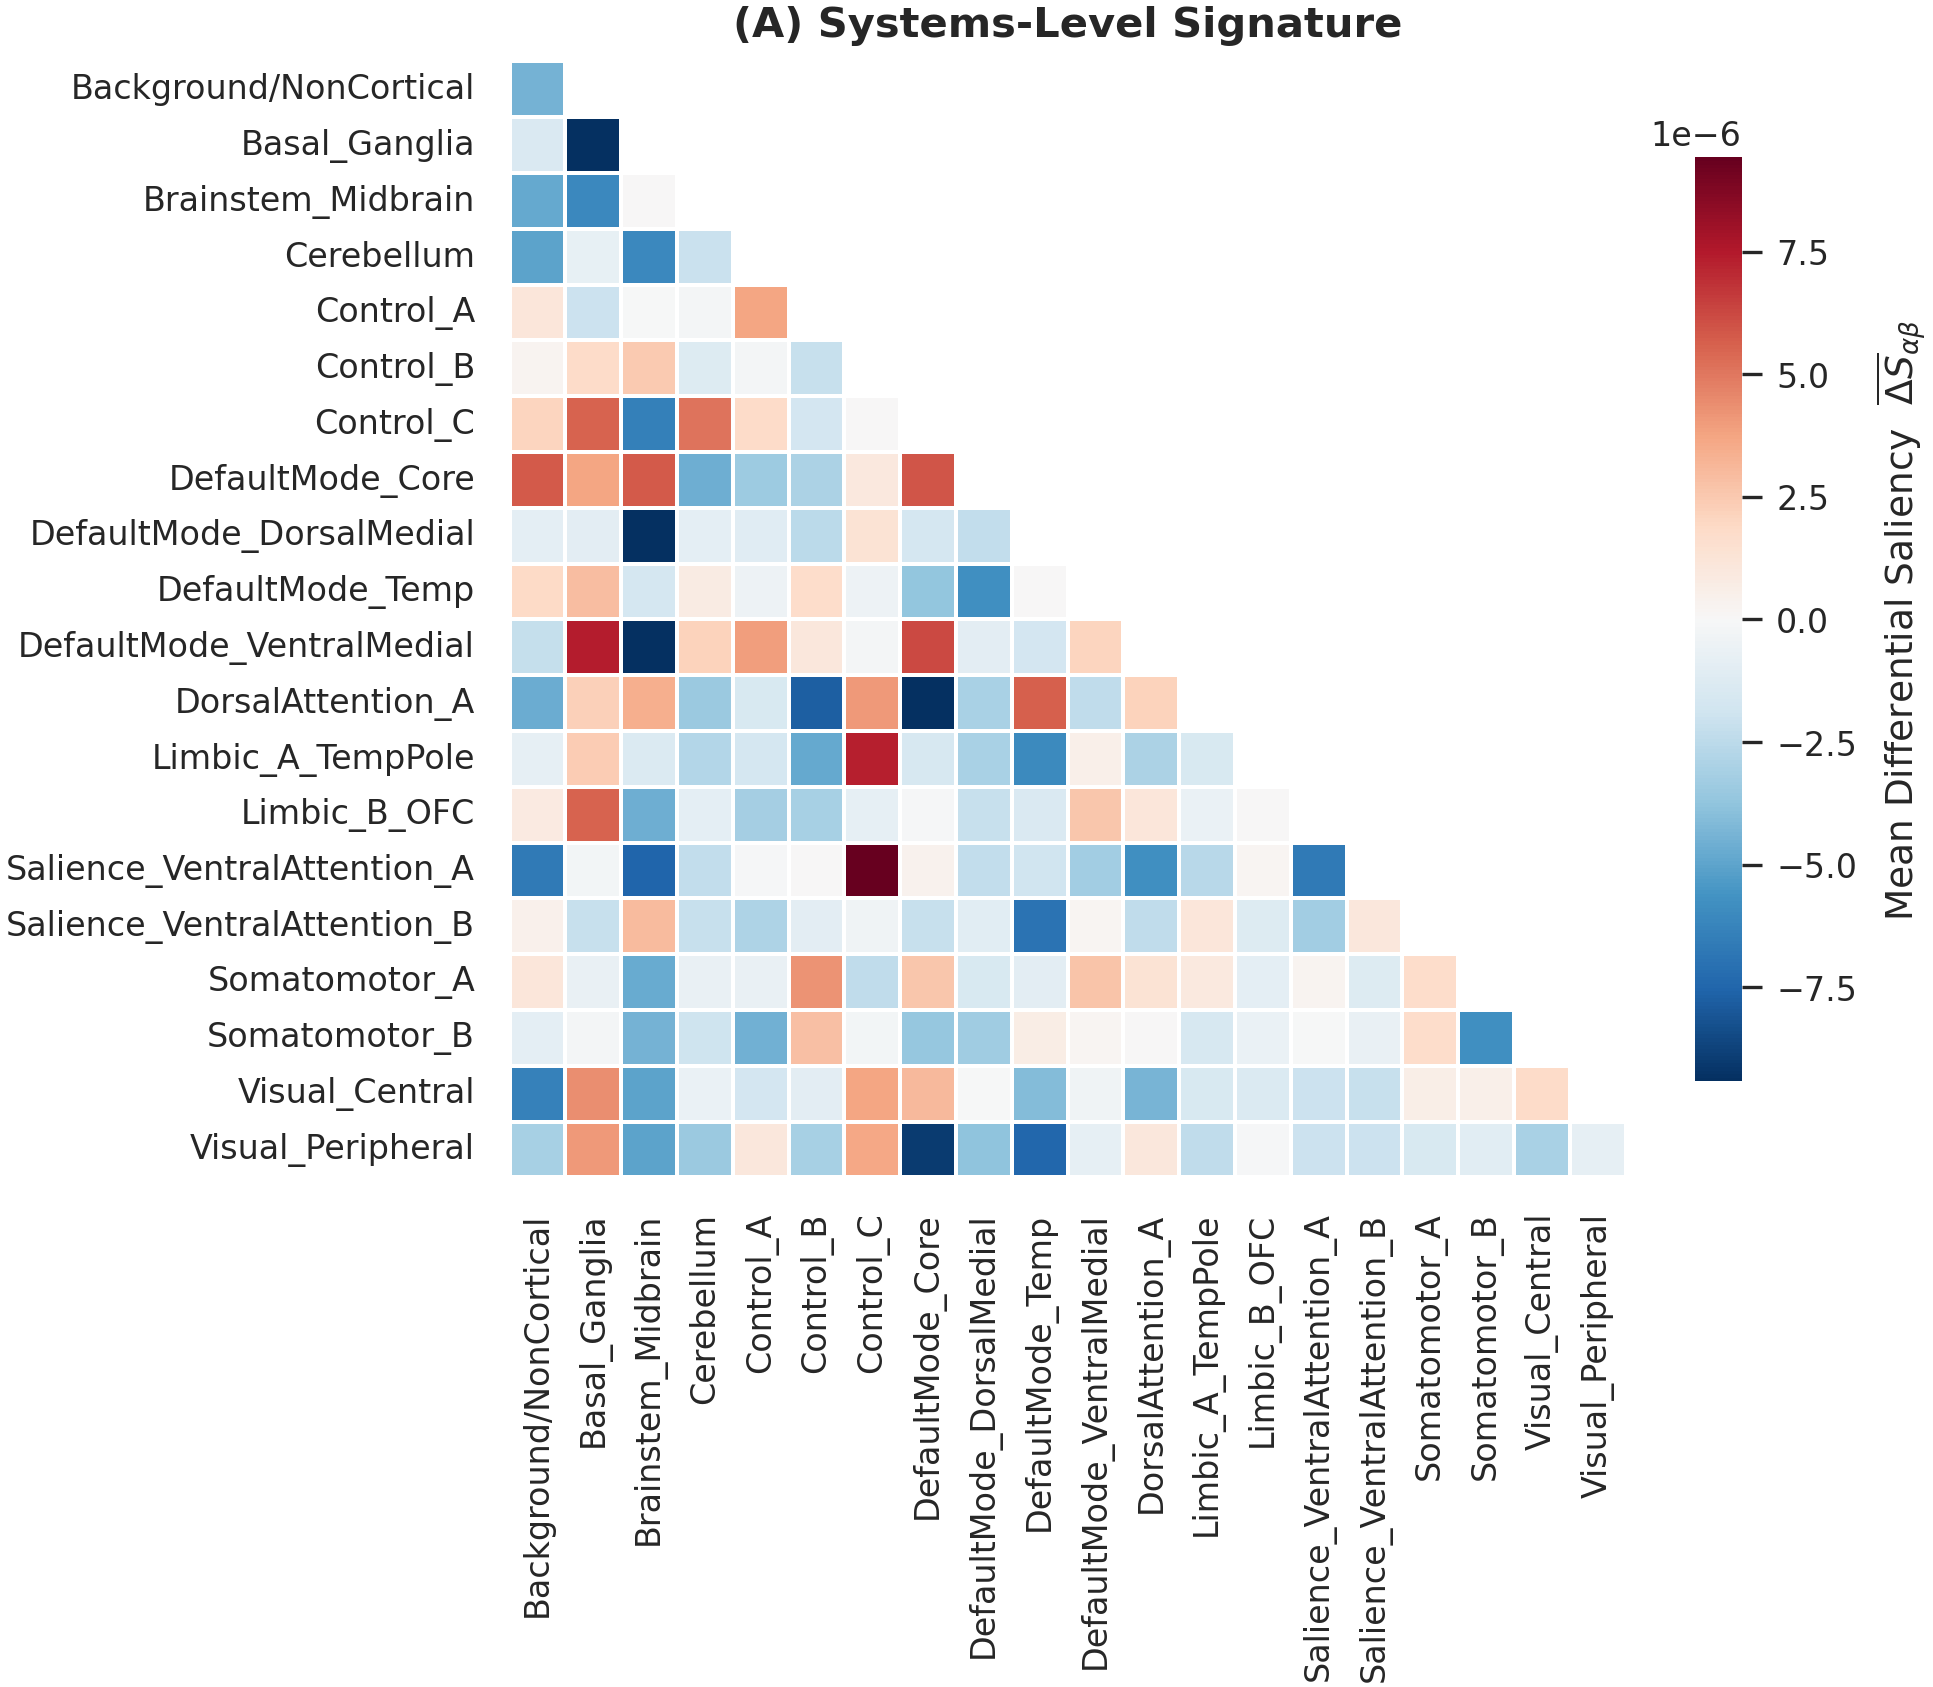

✅ Panel A (mejorado) guardado en: Figures_Nature/figure_A_systems_signature_mejorada.pdf
Orden de redes usado: ['Background/NonCortical', 'Basal_Ganglia', 'Brainstem_Midbrain', 'Cerebellum', 'Control_A', 'Control_B', 'Control_C', 'DefaultMode_Core', 'DefaultMode_DorsalMedial', 'DefaultMode_Temp', 'DefaultMode_VentralMedial', 'DorsalAttention_A', 'Limbic_A_TempPole', 'Limbic_B_OFC', 'Salience_VentralAttention_A', 'Salience_VentralAttention_B', 'Somatomotor_A', 'Somatomotor_B', 'Visual_Central', 'Visual_Peripheral']


In [15]:
# ===================================================================
# CELDA PARA FIGURA A (MEJORADA): Systems-Level Signature (estilo Fig. B)
#   - simetriza explícitamente la matriz de redes
#   - muestra sólo triángulo inferior (máscara como en Fig. B)
#   - orden estable de redes
#   - escala de color robusta y centrada en 0 (RdBu_r)
#   - guarda .pdf/.png con savefig_nature y también .svg
# ===================================================================

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Parámetros de salida / comportamiento ---
AGGREGATE_ACROSS_FOLDS = True   # =True para promediar entre folds (recomendado)
FOLD_TO_SHOW = 1                # usado sólo si AGGREGATE_ACROSS_FOLDS = False
FIG_A_NAME = "figure_A_systems_signature_mejorada"
ANNOTATE_CELLS = False          # poné True si hay pocas redes y querés números

# --- Columnas de red (compatibles con tus CSV anotados) ---
ns = "src_Refined_Network" if "src_Refined_Network" in df_full.columns else "src_Yeo17_Network"
nd = "dst_Refined_Network" if "dst_Refined_Network" in df_full.columns else "dst_Yeo17_Network"

# --- Subconjunto (por fold o agregado) + limpieza mínima ---
cols = [ns, nd, "Saliency_Signed"] + (["fold"] if "fold" in df_full.columns else [])
df_A = df_full[cols].dropna().copy()
if not AGGREGATE_ACROSS_FOLDS and "fold" in df_A.columns:
    df_A = df_A[df_A["fold"] == FOLD_TO_SHOW].copy()

# --- Agregación por par de redes y simetrización explícita ---
mat_A = df_A.groupby([ns, nd])["Saliency_Signed"].mean().unstack(fill_value=0.0)
mat_A = (mat_A + mat_A.T) / 2.0   # <- MISMA idea que Fig. B: forzamos simetría

# --- Orden estable de redes (alfabético por defecto; fácil de reproducir) ---
network_order = sorted(mat_A.index.union(mat_A.columns))
mat_A = mat_A.reindex(index=network_order, columns=network_order).fillna(0.0)

# --- Máscara: ocultar triángulo superior + diagonal (k=1) como en Fig. B ---
mask = np.triu(np.ones_like(mat_A, dtype=bool), k=1)

# --- Escala robusta centrada en cero (divergente) ---
vmax = np.percentile(np.abs(mat_A.values), 98)
if not np.isfinite(vmax) or vmax <= 1e-12:
    vmax = 1.0
vmin = -vmax

# --- Plot ---
fig_A, ax_A = plt.subplots(figsize=(6, 5))
sns.heatmap(
    mat_A,
    mask=mask,                 # <- triángulo inferior visible (simétrica)
    cmap="RdBu_r",
    vmin=vmin, vmax=vmax, center=0.0,
    square=True,
    linewidths=0.5,
    linecolor="white",
    cbar_kws={'label': r'Mean Differential Saliency  $\overline{\Delta S}_{\alpha\beta}$', 'shrink': 0.8},
    annot=ANNOTATE_CELLS and (len(network_order) <= 12),
    fmt=".2f",
    ax=ax_A
)
ax_A.set_title("(A) Systems-Level Signature", weight="bold")
ax_A.set_xlabel("")
ax_A.set_ylabel("")
ax_A.tick_params(axis='x', rotation=90)
ax_A.tick_params(axis='y', rotation=0)

# --- Guardado consistente con tu Fig. B ---
savefig_nature(fig_A, FIG_DIR / FIG_A_NAME)                  # PDF + PNG
fig_A.savefig(FIG_DIR / f"{FIG_A_NAME}.svg", format='svg', bbox_inches="tight")  # SVG
plt.show()

print(f"✅ Panel A (mejorado) guardado en: {FIG_DIR / (FIG_A_NAME + '.pdf')}")
print("Orden de redes usado:", network_order)


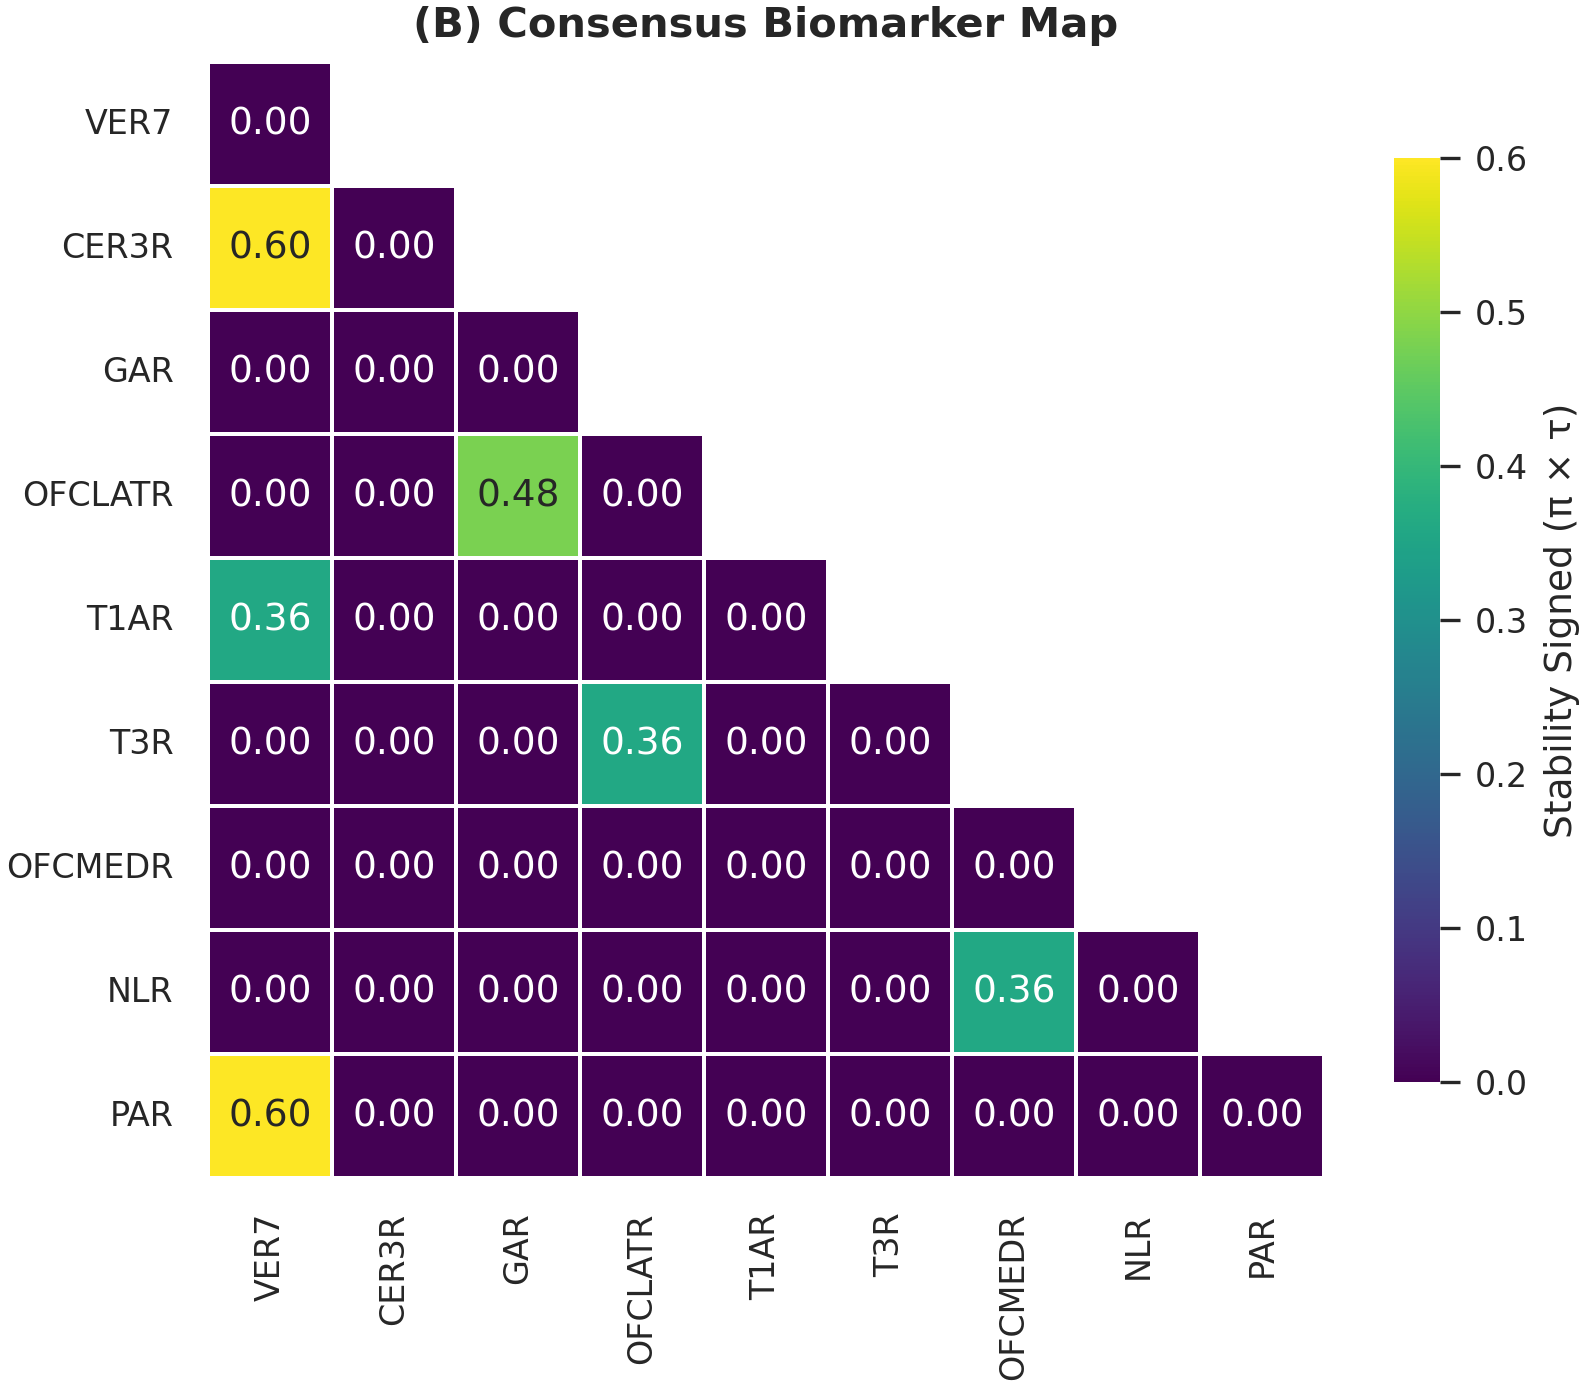

✅ Figura del Panel B (mejorada) guardada en: Figures_Nature/figure_B_consensus_map_mejorada.svg


In [16]:
# ===================================================================
# CELDA PARA FIGURA B: Consensus Biomarker Map (MEJORADA)
# ===================================================================

# --- Configuración ---
FIG_B_NAME = "figure_B_consensus_map_mejorada"

# --- 1. Preparación de Datos (sin cambios) ---
mat_B_data = consensus_set['Signed'].copy()
rois_B = sorted(list(set(roi for conn_tuple in mat_B_data.index for roi in conn_tuple)))
mat_B = pd.DataFrame(0.0, index=rois_B, columns=rois_B)

for (src, dst), signed_stability in mat_B_data.items():
    if src in mat_B.index and dst in mat_B.columns:
        mat_B.loc[src, dst] = signed_stability
    if dst in mat_B.index and src in mat_B.columns:
        mat_B.loc[dst, src] = signed_stability # Sigue siendo simétrica

# --- 2. MEJORA: Reordenar por Red ---
# Usamos el mapeo 'roi2net' que definiste en la celda de "Consensus Sweep"
# (Asegúrate de que la celda "Consensus Sweep" se haya ejecutado)
if 'roi2net' not in globals():
    print("⚠️ Advertencia: 'roi2net' no encontrado. Creando mapeo...")
    net_src_col = 'src_Refined_Network' if 'src_Refined_Network' in df_full.columns else 'src_Yeo17_Network'
    net_dst_col = 'dst_Refined_Network' if 'dst_Refined_Network' in df_full.columns else 'dst_Yeo17_Network'
    roi2net = {}
    for _, r in df_full[['src_AAL3_Name', net_src_col]].dropna().drop_duplicates().iterrows():
        roi2net[r['src_AAL3_Name']] = r[net_src_col]
    for _, r in df_full[['dst_AAL3_Name', net_dst_col]].dropna().drop_duplicates().iterrows():
        roi2net.setdefault(r['dst_AAL3_Name'], r[net_dst_col])

# Crear un DF para ordenar
roi_order_df = pd.DataFrame({
    'ROI': rois_B,
    'Network': [roi2net.get(r, 'Unknown') for r in rois_B]
})
# Ordenar por Red, luego por ROI
roi_order_df = roi_order_df.sort_values(by=['Network', 'ROI'])
network_ordered_rois = roi_order_df['ROI'].tolist()

# Aplicar el nuevo orden
mat_B = mat_B.reindex(index=network_ordered_rois, columns=network_ordered_rois)

# --- 3. MEJORA: Crear máscara para el triángulo superior + diagonal ---
mask = np.triu(np.ones_like(mat_B, dtype=bool), k=1) # k=1 para ocultar también la diagonal

# --- 4. Generación del Gráfico ---
fig_B, ax_B = plt.subplots(figsize=(6, 5))

sns.heatmap(
    mat_B, 
    mask=mask,         # <-- Aplicar máscara
    cmap="viridis",    # 'viridis' está bien para [0, max]
    vmin=0,            # Asegurar que 0 es el mínimo
    square=True, 
    cbar_kws={'label': 'Stability Signed (π × τ)', 'shrink': 0.8},
    ax=ax_B, 
    linewidths=.5, 
    linecolor='white',
    annot=True,        # <-- Añadir valores (útil para matrices pequeñas)
    fmt=".2f"          # <-- Formato de los valores
)

ax_B.set_title("(B) Consensus Biomarker Map", weight="bold")
ax_B.set_xlabel("")
ax_B.set_ylabel("")
ax_B.tick_params(axis='x', rotation=90)
ax_B.tick_params(axis='y', rotation=0)

# --- Guardado en SVG ---
output_path_B = FIG_DIR / f"{FIG_B_NAME}.svg"
fig_B.savefig(output_path_B, format='svg', bbox_inches="tight")
plt.show()

print(f"✅ Figura del Panel B (mejorada) guardada en: {output_path_B}")

2 [-0.25091976  0.90142861]
7 [0.46398788 0.19731697]
3 [-0.68796272 -0.68801096]
6 [-0.88383278  0.73235229]


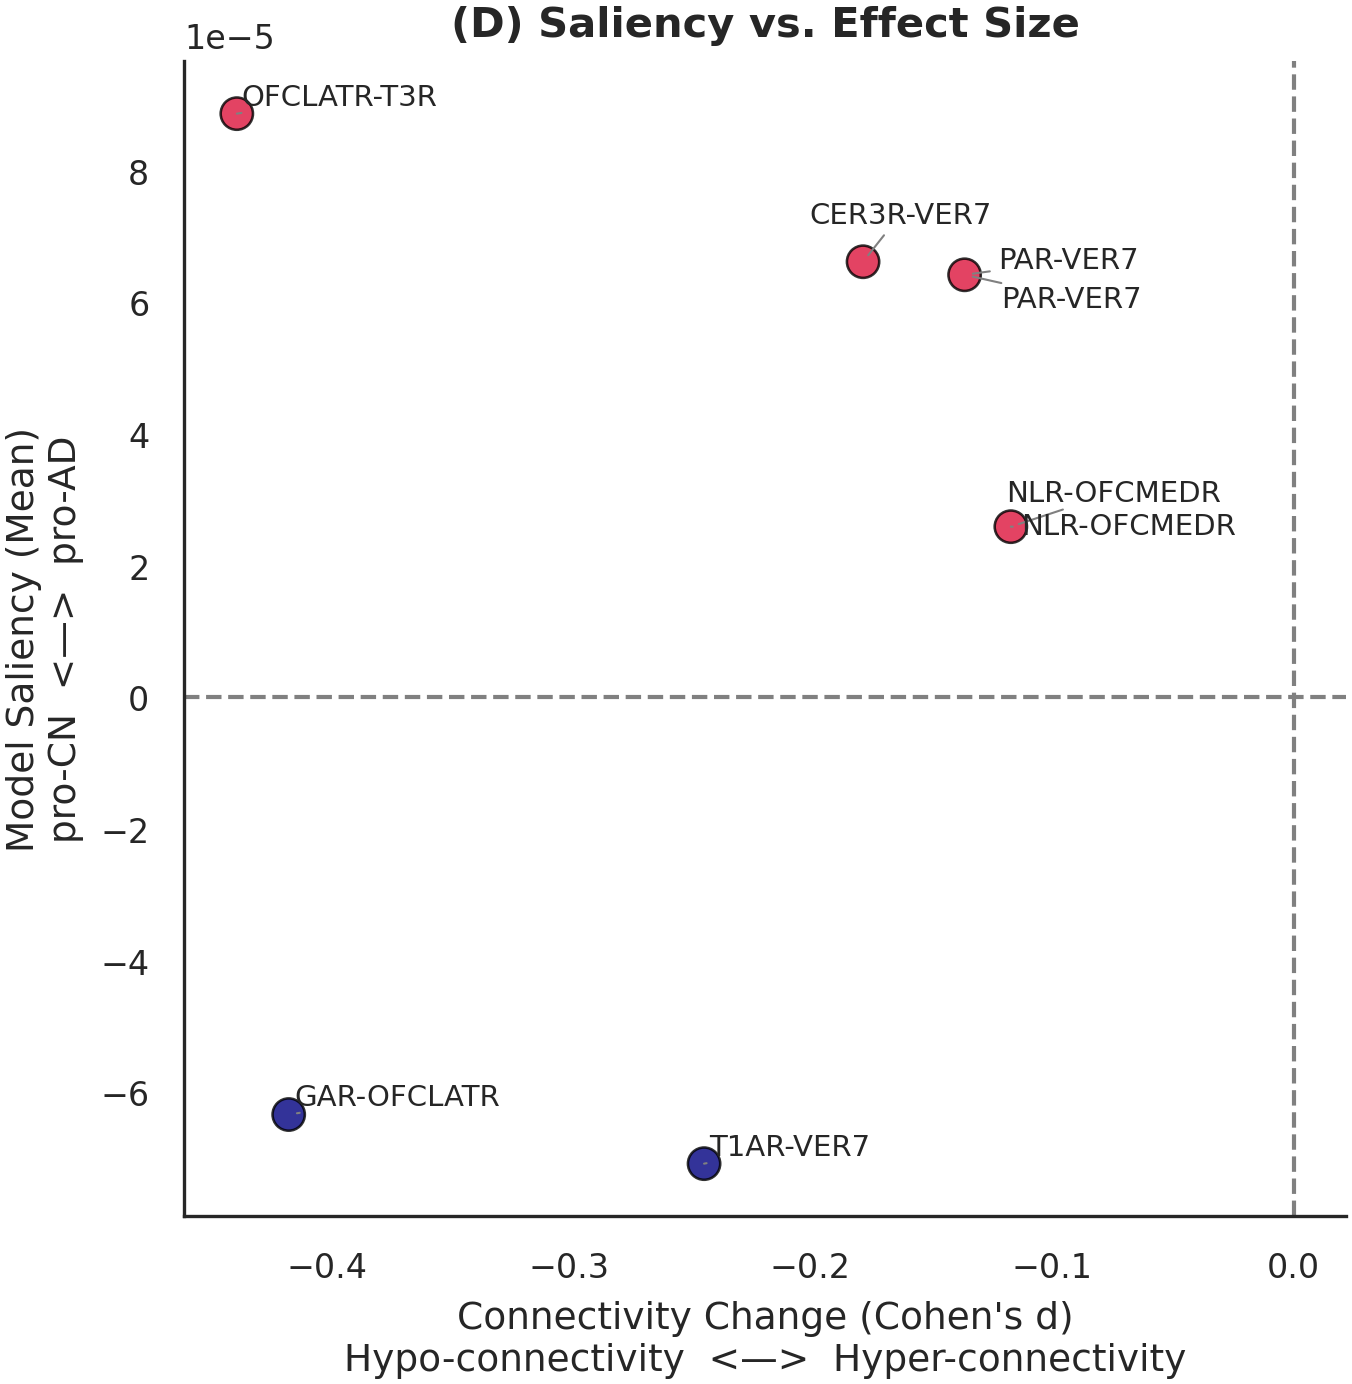

✅ Figura del Panel D guardada en: Figures_Nature/figure_D_saliency_vs_effect.svg


In [17]:
# ===================================================================
# CELDA PARA FIGURA D: Saliency vs. Effect Size (FIX)
# ===================================================================
from scipy.stats import spearmanr
try:
    from adjustText import adjust_text
    ADJUST_TEXT_AVAILABLE = True
except ImportError:
    ADJUST_TEXT_AVAILABLE = False
    def adjust_text(texts, **kwargs): pass

FIG_D_NAME = "figure_D_saliency_vs_effect"

# --- Preparación de Datos (usa df_cohen_all) ---
df_mean_sal = df_full.groupby("connection_id")["Saliency_Signed"].mean().rename("sal")
cohen_df = df_cohen_all[["mean_cohen_d"]].rename(columns={"mean_cohen_d": "cohen_d"})

# Asegurar mismo índice y filtrar al consensus_set
df_qc = (
    pd.concat([df_mean_sal, cohen_df], axis=1)
      .dropna()
      .loc[df_mean_sal.index.intersection(consensus_set.index)]
)

# Seguridad: si quedara vacío, no crashea
if len(df_qc) == 0:
    print("⚠️ df_qc está vacío. Revisa que consensus_set y df_cohen_all compartan índices.")
    fig_D, ax_D = plt.subplots(figsize=(5, 5))
    ax_D.text(0.5, 0.5, "No data after merge", ha='center', va='center', style='italic', color='grey')
    ax_D.set_xticks([]); ax_D.set_yticks([])
    output_path_D = FIG_DIR / f"{FIG_D_NAME}.svg"
    fig_D.savefig(output_path_D, format='svg', bbox_inches="tight")
    plt.show()
else:
    rho, pval = spearmanr(df_qc["sal"].abs(), df_qc["cohen_d"].abs())

    fig_D, ax_D = plt.subplots(figsize=(5, 5))
    sns.scatterplot(
        data=df_qc, x="cohen_d", y="sal",
        s=60, edgecolor="black", alpha=0.8, ax=ax_D,
        hue=(df_qc['sal'] > 0), palette={True:'crimson', False:'navy'}, legend=False
    )

    ax_D.axhline(0, c="grey", ls="--", lw=1)
    ax_D.axvline(0, c="grey", ls="--", lw=1)
    ax_D.set_title("(D) Saliency vs. Effect Size", weight="bold")
    ax_D.set_xlabel("Connectivity Change (Cohen's d)\nHypo-connectivity  <—>  Hyper-connectivity")
    ax_D.set_ylabel("Model Saliency (Mean)\npro-CN  <—>  pro-AD")

    #ax_D.text(0.95, 0.05, f'ρ(|Sal|,|d|) = {rho:.2f} (p={pval:.2e})',
    #          transform=ax_D.transAxes, ha='right', va='bottom', fontsize=9,
    #          bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

    # Etiquetar extremos
    pts = pd.concat([df_qc.nlargest(4, 'sal'), df_qc.nsmallest(4, 'sal')])
    texts = [ax_D.text(r["cohen_d"], r["sal"], f"{i[0]}-{i[1]}", fontsize=7)
             for i, r in pts.iterrows()]
    if ADJUST_TEXT_AVAILABLE:
        adjust_text(texts, ax=ax_D, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

    output_path_D = FIG_DIR / f"{FIG_D_NAME}.svg"
    fig_D.savefig(output_path_D, format='svg', bbox_inches="tight")
    plt.show()

print(f"✅ Figura del Panel D guardada en: {output_path_D}")

# ===================================================================



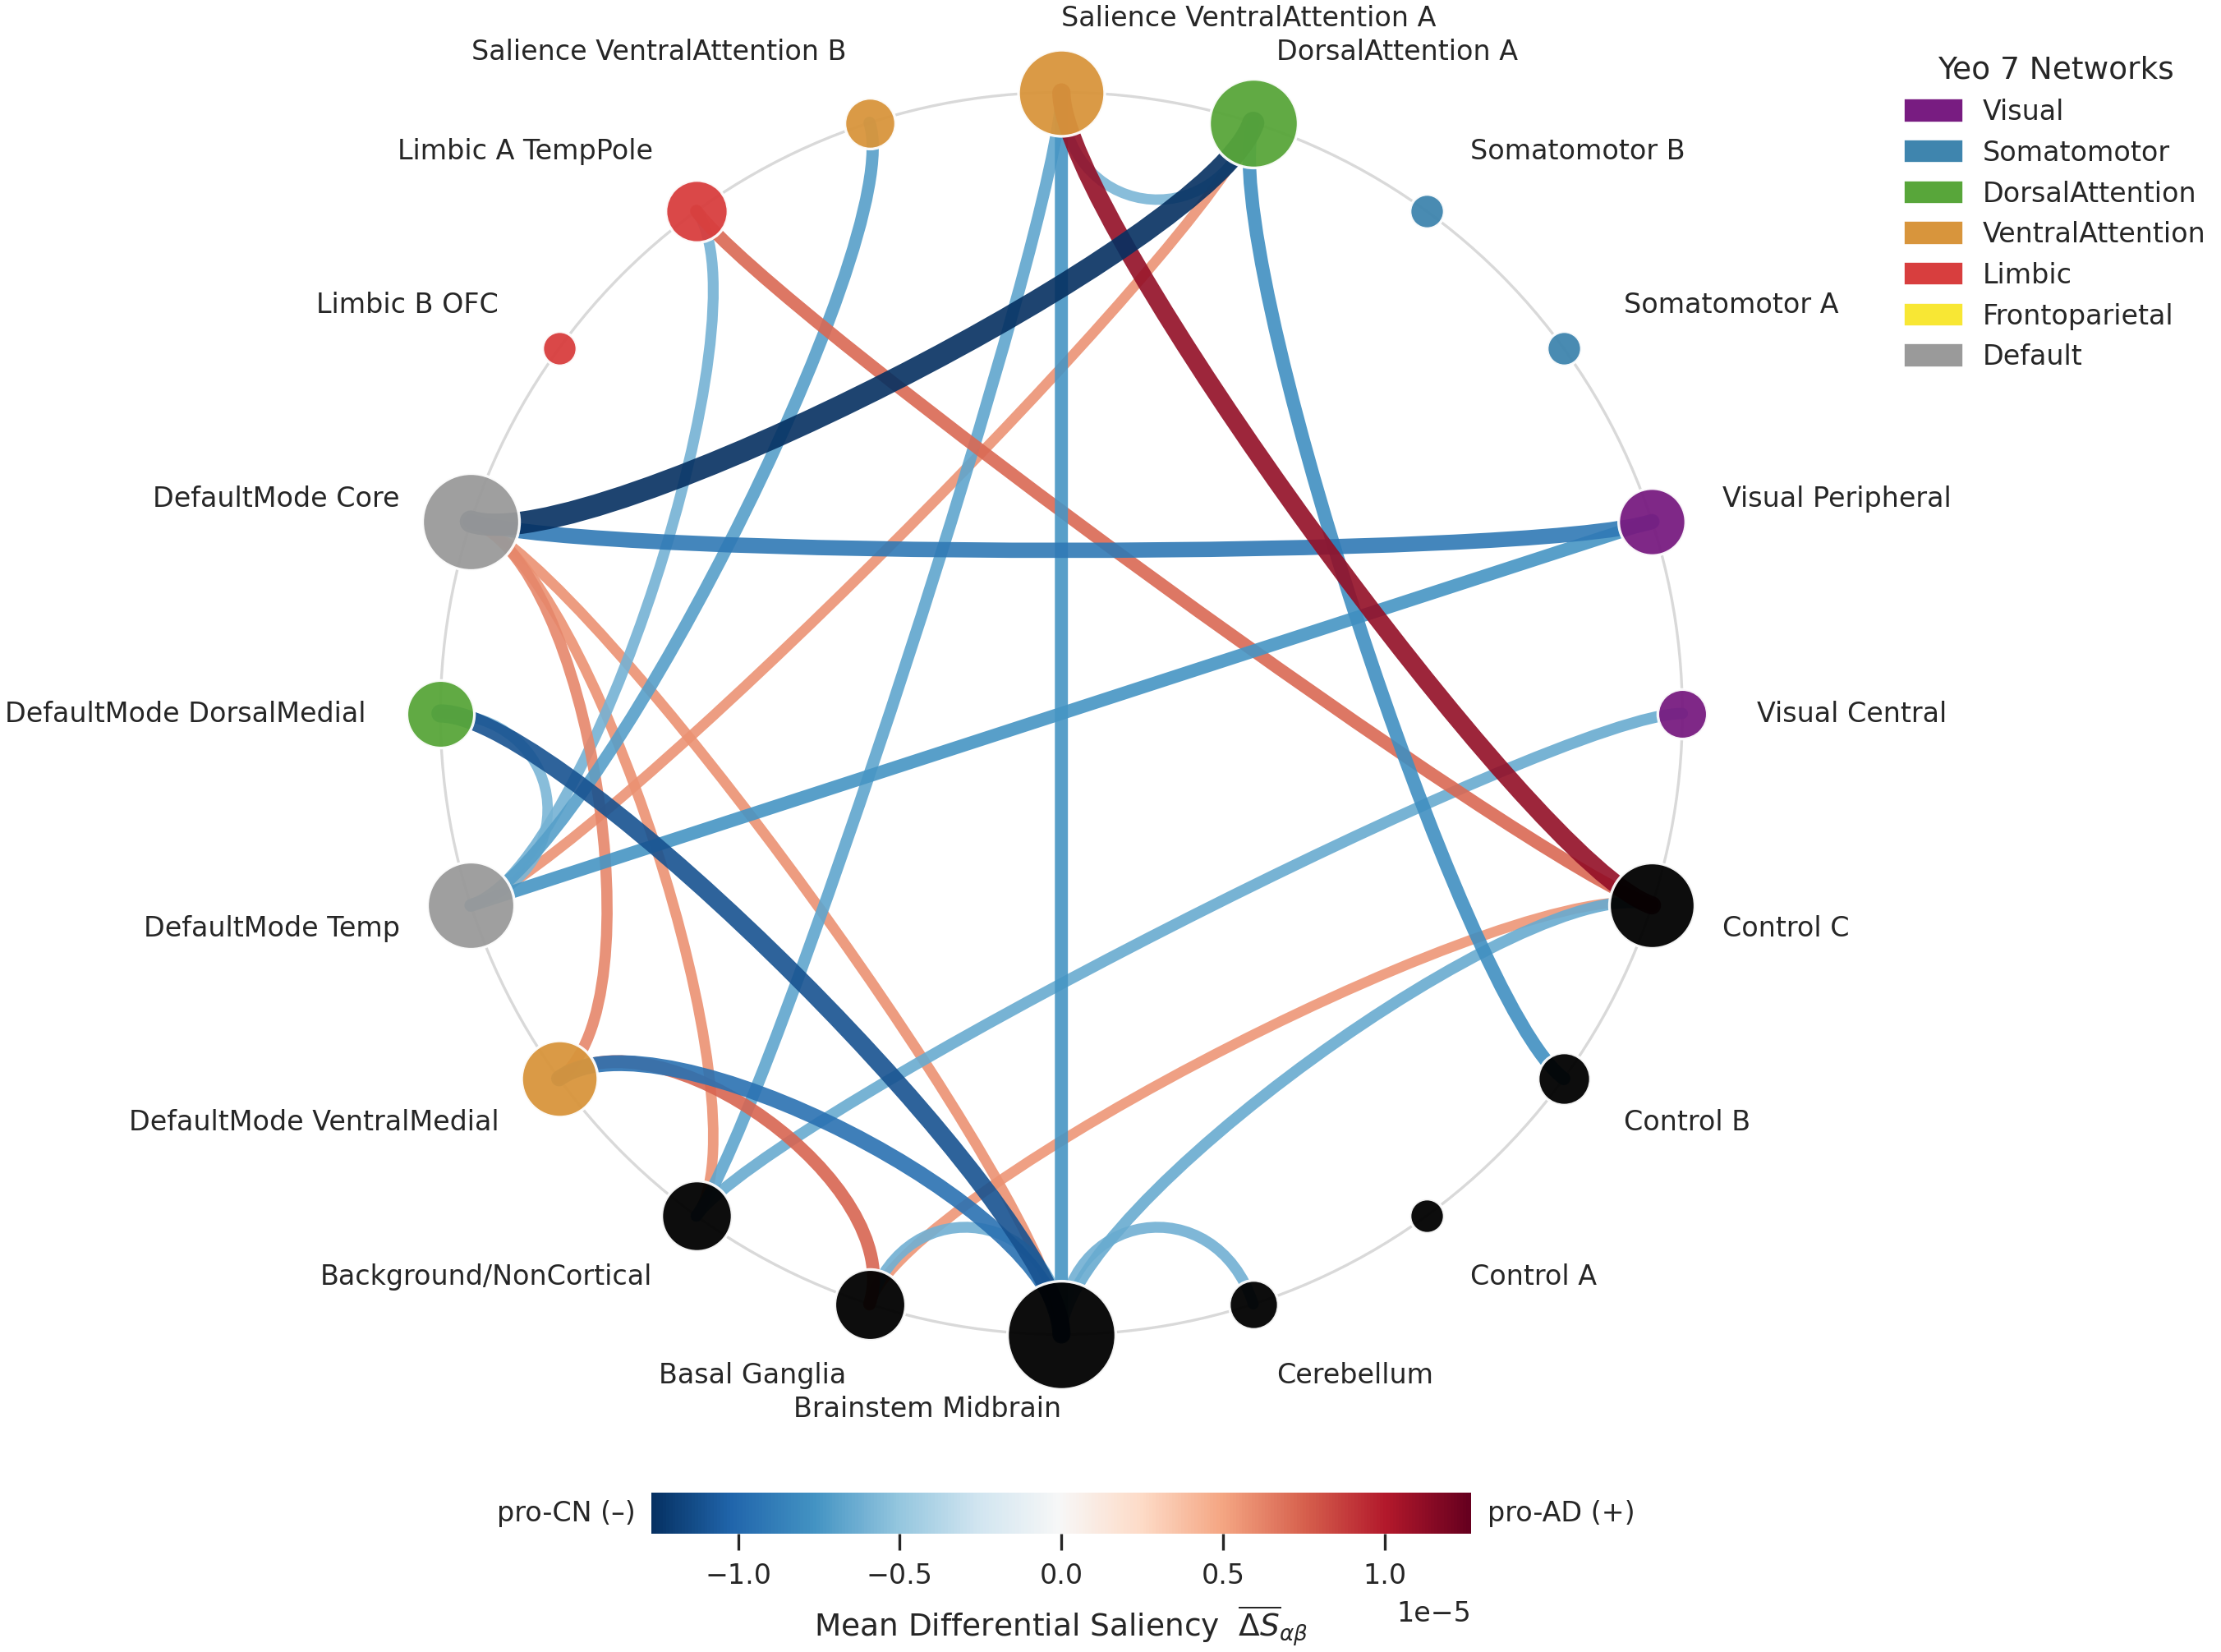

In [18]:
# ======================= CELDA — Chord Yeo↔Yeo (VERSIÓN FINAL CON SVG CORREGIDO) =======================
import pathlib
from datetime import datetime as _dt
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib import colormaps as mpl_cmaps
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.path import Path as MplPath
from matplotlib.patches import PathPatch, Circle
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# ======================== PARÁMETROS DE LA FIGURA ========================
TOP_K_PAIRS = 24
AGGREGATE_ACROSS_FOLDS = True
FOLD_TO_SHOW = 1
CMAP = 'RdBu_r'
FIGSIZE = (7.2, 7.2)
R_BASE, R_LABEL = 1.00, 1.12
CURVE_INSET = 0.80
ORDER_MODE = 'yeo'
NODE_COLOR_MODE = 'yeo'
MIN_ABS_WEIGHT = 0.0
outname = FIG_DIR / f"fig_YeoChord_{'allfolds' if AGGREGATE_ACROSS_FOLDS else f'fold{FOLD_TO_SHOW}'}_{_dt.now().strftime('%Y%m%d_%H%M')}"

# ======================== LÓGICA DE PLOTEO (Función Principal) ========================
YEO7_ORDER = ['Visual', 'Somatomotor', 'DorsalAttention', 'VentralAttention', 
              'Limbic', 'Frontoparietal', 'Default']
YEO_COLOR_MAP = {
    'visual': '#781C81', 'somato': '#3F85AE', 'dorsal': '#58A63A', 
    'ventral': '#D8953C', 'limbic': '#D83E3E', 'fronto': '#F8E734', 'default': '#9A9A9A'
}

def guess_yeo_color(name: str, default='black'):
    n = name.lower()
    for key, col in YEO_COLOR_MAP.items():
        if key in n: return col
    return default

def _bezier_chord(ax, p1, p2, lw, color, alpha=0.9, inset=0.80):
    ctrl1, ctrl2 = p1 * inset, p2 * inset
    path = MplPath([p1, ctrl1, ctrl2, p2], [MplPath.MOVETO, MplPath.CURVE4, MplPath.CURVE4, MplPath.CURVE4])
    ax.add_patch(PathPatch(path, facecolor='none', edgecolor=color, lw=lw, alpha=alpha, capstyle='round'))

# ---- Preparación de datos (sin cambios) ----
ns = 'src_Refined_Network' if 'src_Refined_Network' in df_full.columns else 'src_Yeo17_Network'
nd = 'dst_Refined_Network' if 'dst_Refined_Network' in df_full.columns else 'dst_Yeo17_Network'
_df = df_full[[ns, nd, 'Saliency_Signed'] + (['fold'] if 'fold' in df_full.columns else [])].dropna()
if not AGGREGATE_ACROSS_FOLDS and 'fold' in _df.columns:
    _df = _df[_df['fold'] == FOLD_TO_SHOW].copy()
title_suffix = 'mean across folds' if AGGREGATE_ACROSS_FOLDS else f'fold {FOLD_TO_SHOW}'
mat = _df.groupby([ns, nd])['Saliency_Signed'].mean().unstack(fill_value=0.0)
mat = (mat + mat.T) / 2
networks = sorted(mat.index.union(mat.columns))
mat = mat.reindex(index=networks, columns=networks).fillna(0.0)
edges = []
for i, a in enumerate(networks):
    for j, b in enumerate(networks):
        if j <= i: continue
        w = float(mat.loc[a, b])
        if abs(w) >= MIN_ABS_WEIGHT:
            edges.append((a, b, w, abs(w)))
if not edges: raise ValueError("No hay pares de redes para graficar.")
k = int(min(TOP_K_PAIRS, len(edges)))
edges_top = sorted(edges, key=lambda t: t[3], reverse=True)[:k]
node_strength = pd.Series(0.0, index=networks)
for a, b, w, aw in edges_top:
    node_strength[a] += aw; node_strength[b] += aw
if ORDER_MODE == 'yeo':
    def _get_order_key(name):
        n_lower = name.lower()
        for idx, canon in enumerate(YEO7_ORDER):
            if canon.lower() in n_lower: return (idx, name)
        return (len(YEO7_ORDER), name)
    net_order = sorted(networks, key=_get_order_key)
else:
    net_order = sorted(networks)
theta = np.linspace(0, 2*np.pi, len(net_order), endpoint=False)
pos = {net: np.array([R_BASE*np.cos(t), R_BASE*np.sin(t)]) for net, t in zip(net_order, theta)}
vmax = np.percentile([aw for *_, aw in edges_top], 98) if edges_top else 1.0
if not np.isfinite(vmax) or vmax <= 1e-6: vmax = 1.0
norm = Normalize(vmin=-vmax, vmax=vmax)
cmap = mpl_cmaps.get_cmap(CMAP)
max_abs = max((aw for *_, aw in edges_top), default=1.0)
def width_from_abs(aw):
    return float(np.clip(0.6 + 6.0 * (aw / (max_abs + 1e-12)), 0.6, 6.5))

# ---- Figura ----
fig, ax = plt.subplots(figsize=FIGSIZE)
ax.set_aspect('equal'); ax.axis('off')
ax.add_patch(Circle((0,0), R_BASE, facecolor='none', edgecolor='0.85', lw=0.8, zorder=0))

for a, b, w, aw in sorted(edges_top, key=lambda t: t[3]):
    _bezier_chord(ax, pos[a], pos[b], lw=width_from_abs(aw), color=cmap(norm(w)), inset=CURVE_INSET)

for net in net_order:
    xy = pos[net]
    facecolor = guess_yeo_color(net) if NODE_COLOR_MODE == 'yeo' else 'black'
    size = 100 + 900 * (node_strength.get(net, 0) / node_strength.max() if node_strength.max() > 0 else 0)
    ax.scatter([xy[0]], [xy[1]], s=size, zorder=5, edgecolor='white', linewidth=0.8, color=facecolor, alpha=0.95)
    ang = np.arctan2(xy[1], xy[0])
    lx, ly = R_LABEL*np.cos(ang), R_LABEL*np.sin(ang)
    ax.text(lx, ly, net.replace('_',' '), fontsize=8, ha='left' if lx >= 0 else 'right', va='center')

# --- LEYENDA PARA LAS REDES YEO ---
key_map = {
    'Visual': 'visual', 'Somatomotor': 'somato', 'DorsalAttention': 'dorsal',
    'VentralAttention': 'ventral', 'Limbic': 'limbic', 'Frontoparietal': 'fronto', 'Default': 'default'
}
legend_handles = [mpatches.Patch(color=YEO_COLOR_MAP[key_map[name]], label=name) for name in YEO7_ORDER]
ax.legend(handles=legend_handles, 
          title='Yeo 7 Networks', 
          bbox_to_anchor=(1.1, 1.0),
          loc='upper left',         
          fontsize=8,
          title_fontsize=9,
          frameon=False)            

# --- COLORBAR HORIZONTAL ABAJO (FIX SVG) ---
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array(np.linspace(-vmax, vmax, 256))  # ⟵ CLAVE: da “datos” al mapeador

cax = inset_axes(ax, width="60%", height="3%", loc='lower center', borderpad=-5)
cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
cbar.set_label(r'Mean Differential Saliency  $\overline{\Delta S}_{\alpha\beta}$', fontsize=9)
cbar.solids.set_edgecolor("face")       # evita líneas en el gradiente
cbar.outline.set_visible(False)
# (opcional) rasterizar SOLO el gradiente si ves banding en Illustrator
# cbar.solids.set_rasterized(True)

cbar.ax.text(1.02, 0.5, 'pro-AD (+)', transform=cbar.ax.transAxes, ha='left', va='center', fontsize=8)
cbar.ax.text(-0.02, 0.5, 'pro-CN (–)', transform=cbar.ax.transAxes, ha='right', va='center', fontsize=8)

# --- Guardado ---
savefig_nature(fig, outname)  # pdf/png como ya tenías
fig.savefig(outname.with_suffix(".svg"), format='svg', bbox_inches="tight")  # ⟵ sin 'rasterized'

#la figura se guarda en outname con extensiones .pdf, .png y .svg


In [19]:
# === NUEVA CELDA: Robust hubs agregados (grado-controlado) ===
import pandas as pd, numpy as np
from pathlib import Path

Ks = (50, 100, 200)
hub_rows = []

for fold in range(1, N_FOLDS + 1):
    for K in Ks:
        path = BASE_RUN_DIR / f"fold_{fold}/interpretability_{CLF}/node_robust_hubs_top{K}{SUFFIX}.csv"
        if not path.exists():
            print(f"⚠️ Falta: {path}")
            continue
        df = pd.read_csv(path)
        # aseguramos columnas esperadas
        assert {'node','degree','strength','residual_strength'}.issubset(df.columns), "CSV hubs no tiene columnas esperadas"
        df = df.sort_values('residual_strength', ascending=False).reset_index(drop=True)
        df['fold'] = fold
        df['K'] = K
        df['rank_resid'] = np.arange(1, len(df)+1)
        # guardamos top-10 por robustez
        hub_rows.append(df.head(10)[['node','residual_strength','rank_resid','fold','K']])

if not hub_rows:
    raise RuntimeError("No se encontraron CSVs de hubs. Corre interpretar_fold_paper.py (saliency) para generarlos.")

hubs_agg = pd.concat(hub_rows, ignore_index=True)

# métricas de “epicentro”
summary = (
    hubs_agg
    .groupby('node')
    .agg(
        top3_hits = ('rank_resid', lambda s: int((s <= 3).sum())),
        mean_rank = ('rank_resid', 'mean'),
        mean_resid= ('residual_strength', 'mean'),
        n_lists   = ('rank_resid', 'size')
    )
    .sort_values(['top3_hits','mean_resid'], ascending=[False, False])
)

display(summary.head(20))

# ✅ chequeo específico de HIPPOR y cerebelo
roi_focus = [r for r in summary.index if ('HIPPOR' in r) or ('CER' in r)]
display(summary.loc[roi_focus].sort_values(['top3_hits','mean_resid'], ascending=[False,False]).head(20))


top3_hits  mean_rank  mean_resid  n_lists
node                                              
FUSIL            4   2.666667    0.000130        6
AMYGDL           3   1.000000    0.000456        3
O2R              3   4.000000    0.000152        5
tVPLL            3   1.333333    0.000134        3
FMR              3   4.833333    0.000122        6
VER6             3   1.666667    0.000120        3
CER3R            2   2.333333    0.000153        3
OFCANTR          2   3.333333    0.000135        3
FMOR             2   3.833333    0.000130        6
F3O_2R           2   5.500000    0.000122        4
CER10R           2   4.600000    0.000104        5
LINGR            2   6.200000    0.000098        5
O1R              2   4.833333    0.000080        6
SMAL             1   4.000000    0.000127        3
CER10L           1   5.250000    0.000119        4
CER8R            1   4.400000    0.000119        5
NLR              1   3.500000    0.000111        2
PALLR            1   4.333333    0.000106        3
O3L              1   4.333333    0.000100        3
VER7             1   6.000000    0.000099        3

top3_hits  mean_rank  mean_resid  n_lists
node                                               
CER3R             2   2.333333    0.000153        3
CER10R            2   4.600000    0.000104        5
CER10L            1   5.250000    0.000119        4
CER8R             1   4.400000    0.000119        5
CER8L             1   7.400000    0.000087        5
CER9R             0   5.500000    0.000110        4
CERCRU2R          0   7.000000    0.000081        2
CER4_5L           0   4.333333    0.000077        3
CER7BR            0   9.000000    0.000077        1
HIPPOR            0   7.333333    0.000074        3
CER9L             0   8.500000    0.000047        2
CERCRU1R          0   9.000000    0.000037        2

In [20]:
# === NUEVA CELDA: Lateralización con conteos y test binomial ===
import pandas as pd, numpy as np
from scipy.stats import binomtest

def rr_ll_counts(df: pd.DataFrame, K: int) -> pd.DataFrame:
    df_intra = df[df['hemi_src'] == df['hemi_dst']]
    top = df_intra[df_intra["Rank"] <= K]
    out = []
    for f, g in top.groupby("fold", observed=True):
        rr = (g["hemi_src"] == "R").sum()
        ll = (g["hemi_src"] == "L").sum()
        out.append({"fold": int(f), "K": K, "RR": rr, "LL": ll})
    return pd.DataFrame(out)

counts = pd.concat([rr_ll_counts(df_lat_clean, K) for K in (50, 100, 200)], ignore_index=True)

stats = []
for K, g in counts.groupby('K'):
    rr_total = g['RR'].sum()
    ll_total = g['LL'].sum()
    n = rr_total + ll_total
    prop = rr_total / max(n, 1)
    p = binomtest(rr_total, n, p=0.5, alternative='greater').pvalue if n > 0 else np.nan
    stats.append({"TopK": K, "RR_total": rr_total, "LL_total": ll_total, "prop_RR": prop, "p_binom": p})
stats_df = pd.DataFrame(stats).sort_values('TopK')
display(stats_df)

# (opcional) imprimir frase lista para el paper
for r in stats_df.itertuples():
    print(f"K={r.TopK}: R–R={r.RR_total}, L–L={r.LL_total}, proporción R–R={r.prop_RR:.2f}, binomial p={r.p_binom:.3g}")


TopK  RR_total  LL_total   prop_RR       p_binom
0    50        86        24  0.781818  1.116034e-09
1   100       154        43  0.781726  3.678328e-16
2   200       306        99  0.755556  5.430684e-26

K=50: R–R=86, L–L=24, proporción R–R=0.78, binomial p=1.12e-09
K=100: R–R=154, L–L=43, proporción R–R=0.78, binomial p=3.68e-16
K=200: R–R=306, L–L=99, proporción R–R=0.76, binomial p=5.43e-26


[INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


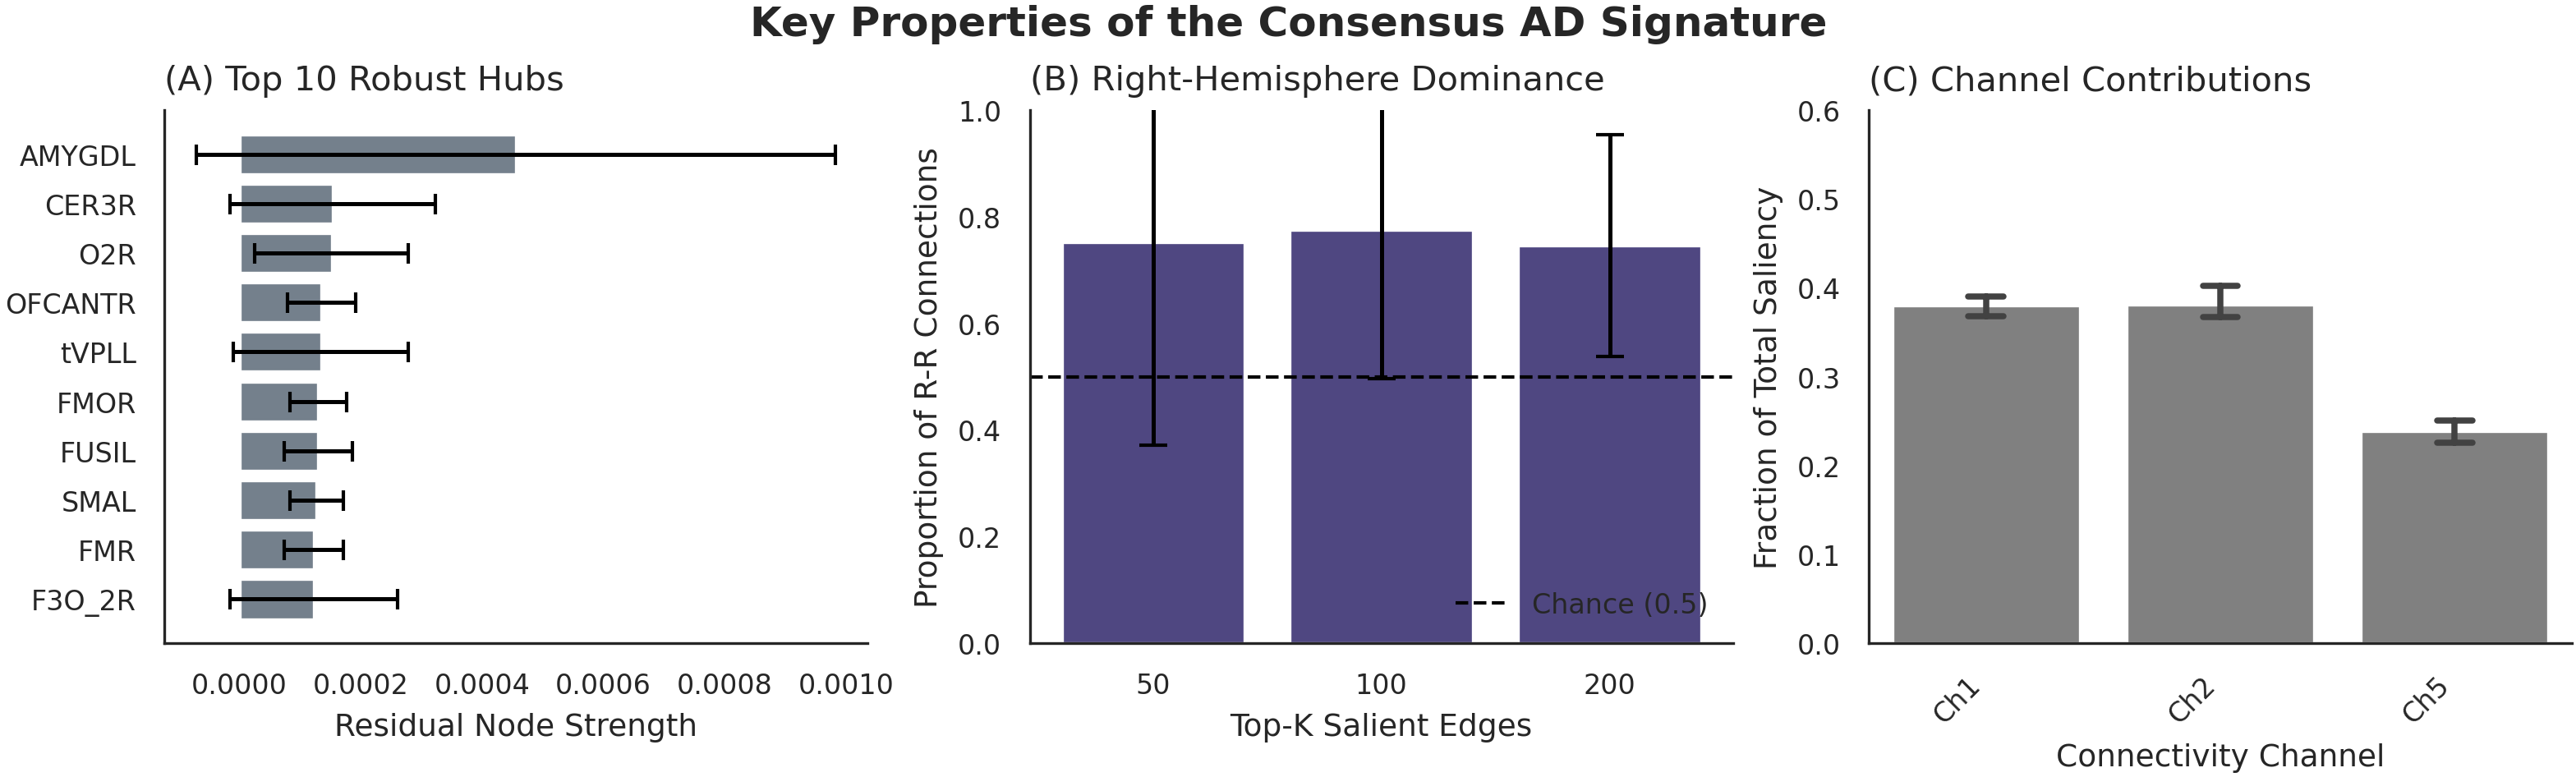

✅ Figura compuesta 'signature_properties' guardada en: Figures_Nature/signature_properties.pdf


In [21]:
# ==============================================================================
# CELDA FINAL: Figura compuesta "signature_properties" (A-B-C) para Q1
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t

# --- Verificar que los datos necesarios existen ---
assert 'hubs_agg' in globals(), "Ejecuta la celda de análisis de hubs primero."
assert 'df_lat_plot' in globals(), "Ejecuta la celda 3 (análisis de estabilidad) primero."
assert 'df_contributions_all_folds' in globals(), "Ejecuta la celda de contribución de canales primero."

# ---- (A) Preparar datos para el panel de Hubs ----
topA = (
    hubs_agg
    .groupby('node')
    .agg(mean_resid=('residual_strength', 'mean'),
         sem=('residual_strength', lambda s: s.std(ddof=1) / np.sqrt(s.size) if s.size > 1 else 0),
         n=('residual_strength', 'size'))
    .sort_values('mean_resid', ascending=False)
    .head(10)
    .reset_index()
)
topA['ci95'] = t.ppf(0.975, df=topA['n'] - 1) * topA['sem']

# ---- (B) Preparar datos para el panel de Lateralización ----
agg_B = df_lat_plot.groupby("TopK")["p_RR"].agg(["mean", "count", "std"]).reset_index()
agg_B["sem"] = agg_B["std"] / np.sqrt(agg_B["count"])
agg_B["ci95"] = t.ppf(0.975, df=agg_B["count"] - 1) * agg_B["sem"]

# ---- (C) Preparar datos para el panel de Canales ----
# Los datos ya están en 'df_contributions_all_folds'

# ---- Creación de la Figura Compuesta ----
fig, axs = plt.subplots(1, 3, figsize=(10.5, 3.2), constrained_layout=True)
fig.suptitle('Key Properties of the Consensus AD Signature', fontsize=12, weight='bold')

# ---------- Panel A: Hubs ----------
sns.barplot(ax=axs[0], data=topA, y='node', x='mean_resid', color='slategray', orient='h')
axs[0].errorbar(x=topA['mean_resid'], y=np.arange(len(topA)), xerr=topA['ci95'], fmt='none', ecolor='black', capsize=3)
axs[0].set_title('(A) Top 10 Robust Hubs', loc='left')
axs[0].set_xlabel('Residual Node Strength'); axs[0].set_ylabel('')

# ---------- Panel B: Lateralización ----------
sns.barplot(ax=axs[1], data=agg_B, x='TopK', y='mean', color='darkslateblue')
axs[1].errorbar(x=np.arange(len(agg_B)), y=agg_B['mean'], yerr=agg_B['ci95'], fmt='none', ecolor='black', capsize=4)
axs[1].axhline(0.5, ls='--', c='black', lw=1, label='Chance (0.5)')
axs[1].set_ylim(0, 1.0); axs[1].set_xlabel('Top-K Salient Edges'); axs[1].set_ylabel('Proportion of R-R Connections')
axs[1].set_title('(B) Right-Hemisphere Dominance', loc='left')
axs[1].legend(frameon=False, loc='lower right')

# ---------- Panel C: Canales ----------
# --- LÍNEA CORREGIDA ---
sns.barplot(ax=axs[2], data=df_contributions_all_folds, x='channel_name', y='l1_norm_fraction_abs',
            errorbar=('ci', 95), color='gray', capsize=.15)
axs[2].set_ylim(0, 0.6); axs[2].set_xlabel('Connectivity Channel'); axs[2].set_ylabel('Fraction of Total Saliency')
axs[2].tick_params(axis='x', rotation=45)
plt.setp(axs[2].get_xticklabels(), ha='right')
axs[2].set_title('(C) Channel Contributions', loc='left')

# Guardar la figura
savefig_nature(fig, FIG_DIR / 'signature_properties')
plt.show()

print(f"✅ Figura compuesta 'signature_properties' guardada en: {FIG_DIR / 'signature_properties.pdf'}")

In [22]:
# === Guardar el panel D en PDF y exportar tabla de lateralidad ===
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, binomtest

FIG_DIR = Path('./Figures_Nature'); FIG_DIR.mkdir(exist_ok=True, parents=True)
TBL_DIR = Path('./Tables_Nature');  TBL_DIR.mkdir(exist_ok=True, parents=True)

# --- Recalcular DF para el panel D (si no quedaron en el entorno) ---
df_mean_sal = df_full.groupby("connection_id")["Saliency_Signed"].mean().rename("sal")
cohen_df = df_cohen_all[["mean_cohen_d"]].rename(columns={"mean_cohen_d": "cohen_d"})
df_qc = (pd.concat([df_mean_sal, cohen_df], axis=1)
           .dropna()
           .loc[df_mean_sal.index.intersection(consensus_set.index)])


# --- Exportar tabla de lateralidad (agregada entre pliegues) ---
def rr_ll_counts(df: pd.DataFrame, K: int) -> pd.DataFrame:
    df_intra = df[df['hemi_src'] == df['hemi_dst']]
    top = df_intra[df_intra["Rank"] <= K]
    rr = (top["hemi_src"] == "R").sum()
    ll = (top["hemi_src"] == "L").sum()
    n  = rr + ll
    prop = rr / n if n else np.nan
    p = binomtest(rr, n, p=0.5, alternative='greater').pvalue if n else np.nan
    return pd.DataFrame({"TopK":[K], "RR_total":[rr], "LL_total":[ll], "prop_RR":[prop], "p_binom":[p]})

Kvals = [50,100,200]
stats_df = pd.concat([rr_ll_counts(df_lat_clean, K) for K in Kvals], ignore_index=True)
stats_df.to_csv(TBL_DIR / "laterality_stats.csv", index=False)
print("✅ Exportada tabla:", TBL_DIR / "laterality_stats.csv")


✅ Exportada tabla: Tables_Nature/laterality_stats.csv


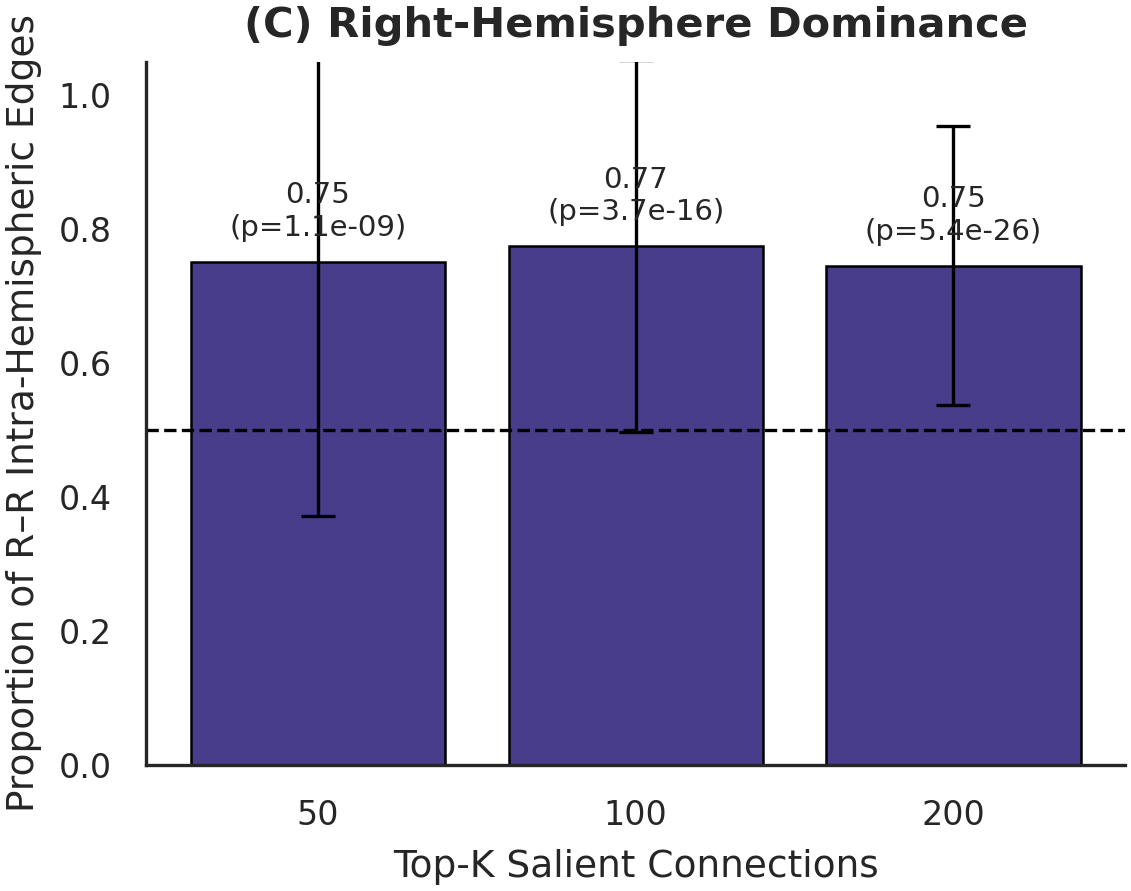

✅ Panel C actualizado con IC95 + p(binomial). Guardado en figure_C_hemisphere_dominance_FINAL.pdf/png
   TopK      mean      ci95  prop_all   p_binom_all
0    50  0.751598  0.379482  0.781818  1.116034e-09
1   100  0.774957  0.278206  0.781726  3.678328e-16
2   200  0.745801  0.208027  0.755556  5.430684e-26


In [23]:
# ===================== CELDA: Panel C FINAL (Right-Hemisphere Dominance) =====================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t

assert 'df_lat_clean' in globals(), "Necesito df_lat_clean de la celda de lateralidad"
assert 'df_lat_plot' in globals(), "Necesito df_lat_plot (proporción R-R por fold)"
assert 'stats_df' in globals(), "Ejecuta antes la celda que calcula stats_df con binomial test"

# 1. Reagregamos promedio por K
agg_C = (
    df_lat_plot
    .groupby("TopK", as_index=False)["p_RR"]
    .agg(mean="mean", std="std", count="count")
)
agg_C["sem"] = agg_C["std"] / np.sqrt(agg_C["count"])
agg_C["ci95"] = t.ppf(0.975, df=agg_C["count"]-1) * agg_C["sem"]

# 2. Merge con p-val binomial de todos los folds combinados (stats_df ya lo tiene)
agg_C = agg_C.merge(
    stats_df.rename(columns={"prop_RR":"prop_all", "p_binom":"p_binom_all"})[["TopK","prop_all","p_binom_all"]],
    on="TopK",
    how="left"
)

# 3. Plot bonito
fig_C, ax_C = plt.subplots(figsize=(4, 3.2))

xvals = np.arange(len(agg_C))
bars = ax_C.bar(
    xvals,
    agg_C["mean"],
    color="darkslateblue",
    edgecolor="black",
    linewidth=0.6
)

ax_C.errorbar(
    xvals,
    agg_C["mean"],
    yerr=agg_C["ci95"],
    fmt="none",
    ecolor="black",
    elinewidth=0.8,
    capsize=4,
    capthick=0.8
)

# línea chance
ax_C.axhline(0.5, ls="--", c="black", lw=0.8)
ax_C.set_ylim(0, 1.05)

ax_C.set_xticks(xvals)
ax_C.set_xticklabels(agg_C["TopK"].astype(str))
ax_C.set_xlabel("Top-K Salient Connections")
ax_C.set_ylabel("Proportion of R–R Intra-Hemispheric Edges")
ax_C.set_title("(C) Right-Hemisphere Dominance", weight="bold")

# anotar media y p_binomial
for xi, bar, row in zip(xvals, bars, agg_C.itertuples()):
    ax_C.text(
        xi,
        bar.get_height() + 0.03,
        f"{bar.get_height():.2f}\n(p={row.p_binom_all:.1e})",
        ha="center",
        va="bottom",
        fontsize=7
    )

fig_C.tight_layout()
savefig_nature(fig_C, FIG_DIR / "figure_C_hemisphere_dominance_FINAL")
plt.show()

print("✅ Panel C actualizado con IC95 + p(binomial). Guardado en figure_C_hemisphere_dominance_FINAL.pdf/png")
print(agg_C[["TopK","mean","ci95","prop_all","p_binom_all"]])

# También guardar en SVG
fig_C.savefig(FIG_DIR / "figure_C_hemisphere_dominance_FINAL.svg", format='svg', bbox_inches="tight")



In [ ]:
# === NUEVA CELDA: Recalcular fuga de escáner (RAW vs LATENTE) con Accuracy y Balanced Accuracy ===
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, balanced_accuracy_score

assert 'fold_indices' in globals() and 'cnad_df' in globals(), "Corre las celdas previas (splits/metadata)."
site_col = locals().get('site_col', 'Site3')  # usa el detectado en tu Celda D

def _uppertri_mean_channels(X):  # X: [n, C, R, R] → [n, E]
    n, C, R, _ = X.shape
    iu = np.triu_indices(R, 1)
    return X.mean(axis=1)[:, iu[0], iu[1]]

rows = []
for f in range(1, N_FOLDS+1):
    te_idx = fold_indices[f]['test']
    tr_idx = fold_indices[f]['train']
    df_tr, df_te = cnad_df.iloc[tr_idx], cnad_df.iloc[te_idx]

    # ---------- FEATURES RAW (input del modelo, normalizado) ----------
    g_tr, g_te = df_tr['tensor_idx'].values, df_te['tensor_idx'].values
    Xraw_tr = global_tensor_data[g_tr][:, CHANNELS_TO_USE, :, :]
    Xraw_te = global_tensor_data[g_te][:, CHANNELS_TO_USE, :, :]

    # Respetar tu normalización de entrada al VAE
    norm_params = joblib.load(BASE_RUN_DIR / f"fold_{f}" / "vae_norm_params.joblib")
    Xraw_tr = apply_normalization_params(Xraw_tr, norm_params)
    Xraw_te = apply_normalization_params(Xraw_te, norm_params)

    Xraw_tr = _uppertri_mean_channels(Xraw_tr)
    Xraw_te = _uppertri_mean_channels(Xraw_te)

    y_tr = df_tr[site_col].astype(str).values
    y_te = df_te[site_col].astype(str).values
    n_classes = len(pd.unique(np.r_[y_tr, y_te]))
    chance = 1.0 / max(n_classes, 1)

    clf_raw = make_pipeline(StandardScaler(with_mean=False), 
                            LogisticRegression(max_iter=2000, n_jobs=1, class_weight=None, multi_class='auto'))
    clf_raw.fit(Xraw_tr, y_tr)
    y_hat = clf_raw.predict(Xraw_te)

    acc_raw = accuracy_score(y_te, y_hat)
    ba_raw  = balanced_accuracy_score(y_te, y_hat)

    # ---------- FEATURES LATENTES (μ) ----------
    fold_dir = BASE_RUN_DIR / f"fold_{f}"
    vae_model = ConvolutionalVAE(
        input_channels=len(CHANNELS_TO_USE),
        latent_dim=run_args['latent_dim'],
        image_size=global_tensor_data.shape[-1],
        num_conv_layers_encoder=run_args['num_conv_layers_encoder'],
        decoder_type=run_args['decoder_type'],
        final_activation=run_args['vae_final_activation'],
        intermediate_fc_dim_config=run_args['intermediate_fc_dim_vae'],
        dropout_rate=run_args['dropout_rate_vae'],
        use_layernorm_fc=run_args['use_layernorm_vae_fc']
    ).to(device)
    vae_model.load_state_dict(torch.load(fold_dir / f"vae_model_fold_{f}.pt", map_location=device))
    vae_model.eval()

    Xraw_tr_4d = global_tensor_data[g_tr][:, CHANNELS_TO_USE, :, :]
    Xraw_te_4d = global_tensor_data[g_te][:, CHANNELS_TO_USE, :, :]
    Xn_tr = apply_normalization_params(Xraw_tr_4d, norm_params)
    Xn_te = apply_normalization_params(Xraw_te_4d, norm_params)

    with torch.no_grad():
        Z_tr = vae_model.encode(torch.from_numpy(Xn_tr).float().to(device))[0].cpu().numpy()
        Z_te = vae_model.encode(torch.from_numpy(Xn_te).float().to(device))[0].cpu().numpy()

    clf_lat = make_pipeline(StandardScaler(), 
                            LogisticRegression(max_iter=2000, n_jobs=1, class_weight=None, multi_class='auto'))
    clf_lat.fit(Z_tr, y_tr)
    y_hat_lat = clf_lat.predict(Z_te)

    acc_lat = accuracy_score(y_te, y_hat_lat)
    ba_lat  = balanced_accuracy_score(y_te, y_hat_lat)

    rows.append({
        'fold': f,
        'n_sites_test': len(pd.unique(y_te)),
        'chance_level_ba': chance,
        'acc_site_raw': acc_raw,
        'ba_site_raw': ba_raw,
        'acc_site_latent': acc_lat,
        'ba_site_latent': ba_lat
    })

qc_rebuilt = pd.DataFrame(rows)
display(qc_rebuilt)

# Exporta una Table S2 **canónica**
TBL_DIR.mkdir(parents=True, exist_ok=True)
s2_out = TBL_DIR / "TableS2_scanner_leakage_RECOMPUTED.csv"
qc_rebuilt.to_csv(s2_out, index=False)
print("✅ Table S2 (recomputed) →", s2_out)

# Opcional: media±sd impresas
def _msd(s): return f"{np.mean(s):.3f} ± {np.std(s, ddof=1):.3f}"
print("ACC raw:", _msd(qc_rebuilt['acc_site_raw']))
print("ACC lat:", _msd(qc_rebuilt['acc_site_latent']))
print("BA  raw:", _msd(qc_rebuilt['ba_site_raw']))
print("BA  lat:", _msd(qc_rebuilt['ba_site_latent']))


fold  n_sites_test  chance_level_ba  acc_site_raw  ba_site_raw  \
0     1            19         0.030303      0.189189     0.108187   
1     2            19         0.030303      0.216216     0.191228   
2     3            23         0.030303      0.243243     0.157005   
3     4            20         0.030303      0.216216     0.140000   
4     5            20         0.030303      0.194444     0.131667   

   acc_site_latent  ba_site_latent  
0         0.243243        0.232456  
1         0.135135        0.094737  
2         0.189189        0.106280  
3         0.081081        0.030000  
4         0.111111        0.120000

✅ Table S2 (recomputed) → Tables_Nature/TableS2_scanner_leakage_RECOMPUTED.csv
ACC raw: 0.212 ± 0.021
ACC lat: 0.152 ± 0.065
BA  raw: 0.146 ± 0.031
BA  lat: 0.117 ± 0.073


[INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


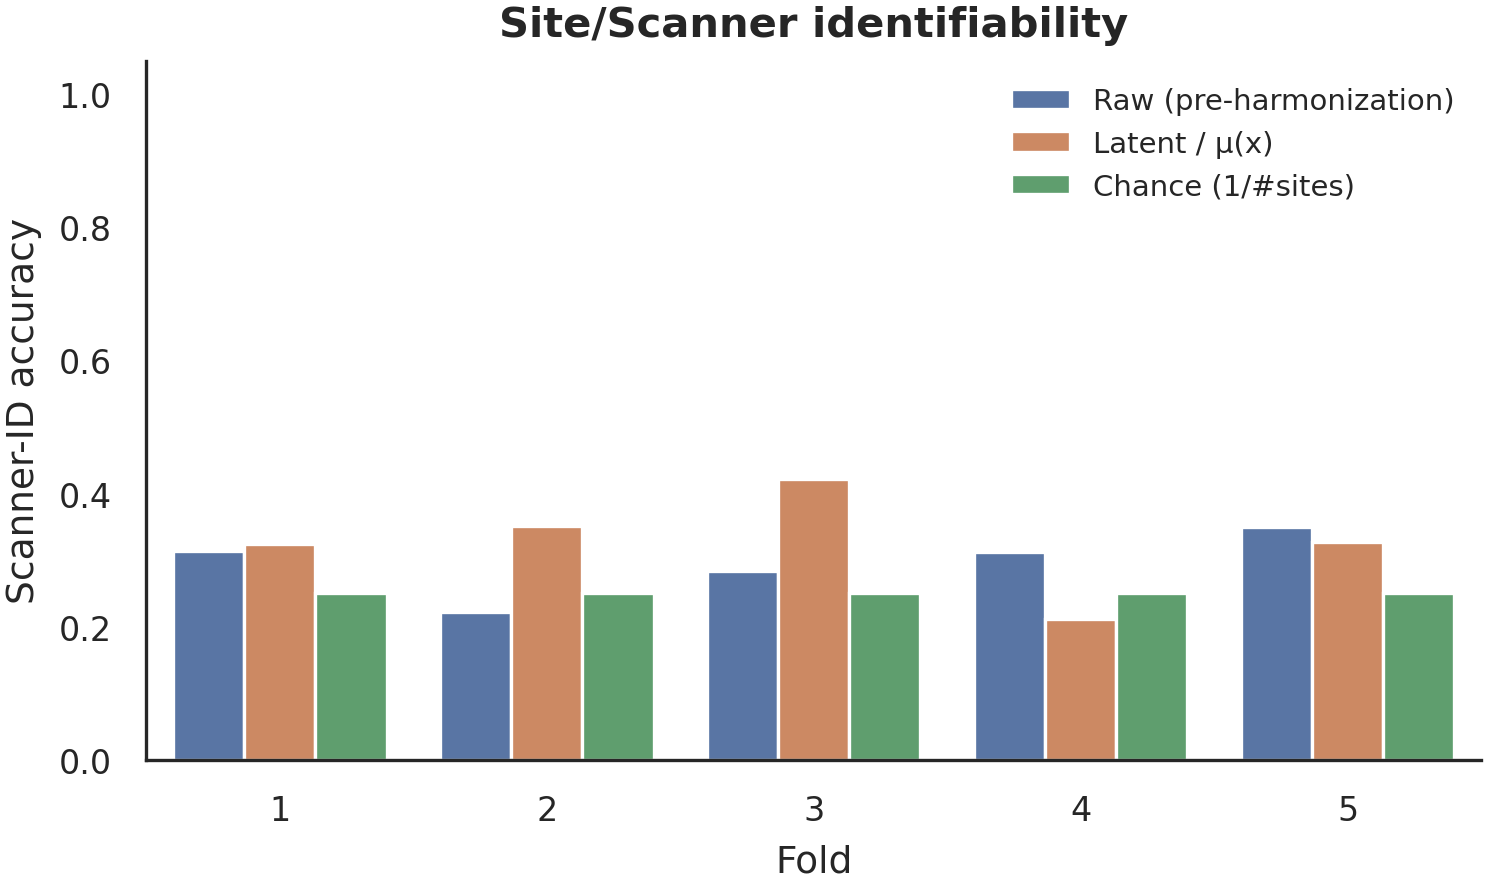

✅ Fig 3 guardada en: Figures_Nature/fig3_scanner_leakage.pdf
✅ Table S2 guardada en: Tables_Nature/TableS2_scanner_leakage.csv
⚠️ No pude generar Supp Fig S1. Claves NPZ disponibles: ['global_tensor_data', 'subject_ids', 'channel_names', 'rois_count', 'target_len_ts', 'tr_seconds', 'filter_low_hz', 'filter_high_hz', 'hrf_deconvolution_applied', 'hrf_model', 'channel_normalization_method_subject', 'notes_on_further_normalization', 'roi_order_name', 'roi_names_in_order', 'network_labels_in_order']


In [ ]:
# ============================================================
# CELDA C — ARMONIZACIÓN / FUGA DEL ESCÁNER (Fig 3, Supp Fig S1)
# ============================================================
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

assert 'df_qc_summary' in globals(), "Corre Celda B primero (df_qc_summary)."

# ------------------------------------------------------------
# 1. FIG 3: Leakage por fold (raw vs latent) con chance
# ------------------------------------------------------------
leak_cols = []
# Preferir BA si está; si no, usar ACC
if 'ba_site_raw' in df_qc_summary.columns and 'ba_site_latent' in df_qc_summary.columns:
    leak_cols = ['ba_site_raw', 'ba_site_latent']
    y_label = "Scanner-ID balanced accuracy"
else:
    if 'acc_site_raw' in df_qc_summary.columns: leak_cols.append('acc_site_raw')
    if 'acc_site_latent' in df_qc_summary.columns: leak_cols.append('acc_site_latent')
    y_label = "Scanner-ID accuracy"

if not leak_cols:
    print("⚠️ No tengo columnas de fuga de escáner ('acc_site_raw' / 'acc_site_latent') en df_qc_summary. Saltando Fig 3.")
else:
    leak_plot_df = df_qc_summary[['fold'] + leak_cols + (['chance_level'] if 'chance_level' in df_qc_summary.columns else [])].copy()
    # melt para barras agrupadas
    value_vars = [c for c in ['acc_site_raw','acc_site_latent','chance_level'] if c in leak_plot_df.columns]
    leak_long = leak_plot_df.melt(id_vars='fold',
                                  value_vars=value_vars,
                                  var_name='source',
                                  value_name='acc')
    source_map = {
        'acc_site_raw': 'Raw (pre-harmonization)',
        'acc_site_latent': 'Latent / μ(x)',
        'chance_level': 'Chance (1/#sites)'
    }
    leak_long['source'] = leak_long['source'].map(source_map).fillna(leak_long['source'])

    fig3, ax3 = plt.subplots(figsize=(5,3), constrained_layout=True)
    name_map = {1:'Pearson_Full_FisherZ_Signed', 2:'MI_kNN_Symmetric', 5:'DistanceCorr'}
    df_contributions_all_folds['channel_name'] = (
                    df_contributions_all_folds['channel_name'].map(name_map).astype('category')
                )

    sns.barplot(
        data=leak_long, x='fold', y='acc', hue='source',
        ax=ax3, capsize=.15
    )
    ax3.set_ylim(0,1.05)
    ax3.set_ylabel("Scanner-ID accuracy")
    ax3.set_xlabel("Fold")
    ax3.set_title("Site/Scanner identifiability", weight='bold')
    ax3.legend(frameon=False, fontsize=7)

    savefig_nature(fig3, FIG_DIR / "fig3_scanner_leakage")
    plt.show()
    print("✅ Fig 3 guardada en:", FIG_DIR / "fig3_scanner_leakage.pdf")

    # Exportar tabla S2
    tableS2_path = TBL_DIR / "TableS2_scanner_leakage.csv"
    df_qc_summary.to_csv(tableS2_path, index=False)
    print("✅ Table S2 guardada en:", tableS2_path)

# ------------------------------------------------------------
# 2. Supp Fig S1: QC de normalización / reconstrucción
# ------------------------------------------------------------
# Intento reconstruir histogramas de pesos de conectividad:
#  - "raw" (antes de armonizar)
#  - "input"/"norm" (lo que entra al modelo)
#  - "recon" (reconstrucción VAE)
# Si no las encuentro en el NPZ, solo aviso.

def _pick_first_key(available_keys, substrings):
    for sub in substrings:
        for k in available_keys:
            if sub.lower() in k.lower():
                return k
    return None

try:
    npz_dbg = np.load(GLOBAL_TENSOR_PATH)
    available_keys = list(npz_dbg.keys())
except Exception as e:
    npz_dbg = None
    available_keys = []
    print(f"⚠️ No pude abrir GLOBAL_TENSOR_PATH para hist QC ({e}).")

if npz_dbg is not None:
    key_raw   = _pick_first_key(available_keys, ['raw','orig','original','unscaled'])
    key_norm  = _pick_first_key(available_keys, ['global_tensor_data','norm','zscore','scaled'])
    key_recon = _pick_first_key(available_keys, ['recon','reconstructed','vae','decoded'])

    def _offdiag_values(arr_4d):
        # arr_4d puede ser [n_subj, n_chan, R, R] o [n_subj, R, R]
        arr = arr_4d
        if arr.ndim == 4:
            arr = arr.mean(axis=1)  # promediamos canales
        # arr ahora [n_subj, R, R]
        n_subj, R1, R2 = arr.shape
        vals = []
        for ii in range(R1):
            for jj in range(R2):
                if ii < jj:
                    vals.append(arr[:, ii, jj])
        if len(vals) == 0:
            return np.array([])
        return np.concatenate(vals, axis=0)

    have_all = (key_raw is not None) and (key_norm is not None) and (key_recon is not None)
    if have_all:
        vals_raw  = _offdiag_values(npz_dbg[key_raw])
        vals_norm = _offdiag_values(npz_dbg[key_norm])
        vals_rec  = _offdiag_values(npz_dbg[key_recon])

        figS1, axsS1 = plt.subplots(1,3, figsize=(9,3), sharey=True, constrained_layout=True)
        panels = [
            ("Raw / pre-harmonization", vals_raw),
            ("Harmonized / model input", vals_norm),
            ("VAE reconstruction", vals_rec),
        ]
        for ax, (title, arr_vals) in zip(axsS1, panels):
            sns.histplot(arr_vals, bins=40, stat='density', ax=ax)
            ax.set_title(title, fontsize=9)
            ax.set_xlabel("Edge weight")
            ax.set_ylabel("Density")
        savefig_nature(figS1, FIG_DIR / "figS1_QC_preproc")
        plt.show()
        print("✅ Supp Fig S1 guardada en:", FIG_DIR / "figS1_QC_preproc.pdf")
    else:
        print("⚠️ No pude generar Supp Fig S1. Claves NPZ disponibles:", available_keys)
 

In [ ]:
# ============================================================
# CELDA D — BALANCE COHORTES POR FOLD (Table S1, versión final)
# Genera la tabla demográfica / de procedencia por fold (train/test)
# y una fila global "ALL" lista para Supplementary Table S1.
# ============================================================

import numpy as np
import pandas as pd
from pathlib import Path
from scipy.stats import t

# ------------------------------------------------------------------
# 0. Chequeos básicos de dependencias en el workspace
#    (estas variables ya existen si corriste las celdas previas)
# ------------------------------------------------------------------
assert 'cnad_df' in globals(), "cnad_df no existe. Corre las celdas de carga de metadata."
assert 'fold_indices' in globals(), "fold_indices no existe. Corre la celda donde armaste train/test por fold."
assert 'N_FOLDS' in globals(), "N_FOLDS no definido."
assert 'TBL_DIR' in globals(), "TBL_DIR no definido (debería venir de la celda 0)."

# ------------------------------------------------------------------
# 1. Normalización mínima de columnas clave en cnad_df
#    (esto lo hacemos por si vienes de un kernel limpio)
# ------------------------------------------------------------------
cnad_df = cnad_df.copy()

# Edad -> numérico
if 'Age' in cnad_df.columns:
    cnad_df['Age'] = pd.to_numeric(cnad_df['Age'], errors='coerce')

# Sexo -> 'M' / 'F' consistente (útil para %Female)
if 'Sex' in cnad_df.columns:
    cnad_df['Sex'] = (
        cnad_df['Sex']
        .replace({0:'M', 1:'F', 'm':'M', 'f':'F'})
        .astype(str)
        .str.upper()
    )

# ------------------------------------------------------------------
# 2. Helper functions para métricas demográficas
# ------------------------------------------------------------------
def mean_sd_str(x, ndigits=1):
    """
    Devuelve 'media ± sd' con 1 decimal.
    Si hay <2 valores válidos, devolvemos 'NA' para no mentirle al revisor.
    """
    x = pd.to_numeric(pd.Series(x), errors='coerce').dropna()
    if len(x) < 2:
        return "NA"
    return f"{x.mean():.{ndigits}f} ± {x.std(ddof=1):.{ndigits}f}"

def pct_female(series_sex):
    """
    Porcentaje de sujetos etiquetados como F (sobre F+M).
    Devuelve 'NA' si no hay datos.
    """
    s = pd.Series(series_sex).astype(str).str.upper()
    mask = s.isin(['M','F'])
    if mask.sum() == 0:
        return "NA"
    prop_f = (s[mask] == 'F').mean()
    return f"{100.0 * prop_f:.1f}%"

def pick_site_col(df):
    """    Adivina qué columna representa 'sitio / escáner / centro'.    """
    # Prioriza 'Site3' o 'AcqSite' ANTES que 'Manufacturer'
    candidates_priority = [
        "Site3",  # <-- Añadido al inicio
        "AcquisitionSite", "AcqSite",
        "Site", "ScannerSite",
        "Center", "ScannerCenter",
        "ScannerManufacturer", "Manufacturer", # <-- Siguen aquí pero con menos prioridad
        "ManufacturerModelName", "ScannerVendor"
    ]
    cols_lower = {c.lower(): c for c in df.columns}
    for cand in candidates_priority:
        if cand.lower() in cols_lower:
            return cols_lower[cand.lower()]
    return None

site_col = pick_site_col(cnad_df)
print(f"🛰  Columna elegida como 'sitio/escáner': {site_col}")

# ------------------------------------------------------------------
# 3. Recorremos folds y computamos stats train/test
# ------------------------------------------------------------------
rows = []

for f in range(1, N_FOLDS + 1):

    tr_idx = fold_indices[f]['train']  # índices sobre cnad_df
    te_idx = fold_indices[f]['test']

    df_tr = cnad_df.iloc[tr_idx].copy()
    df_te = cnad_df.iloc[te_idx].copy()

    # Diagnóstico (AD / CN)
    grp_tr = df_tr['ResearchGroup_Mapped']
    grp_te = df_te['ResearchGroup_Mapped']

    # Conteos básicos
    n_tr  = len(df_tr)
    n_te  = len(df_te)

    n_tr_CN = (grp_tr == 'CN').sum()
    n_tr_AD = (grp_tr == 'AD').sum()
    n_te_CN = (grp_te == 'CN').sum()
    n_te_AD = (grp_te == 'AD').sum()

    # Edad
    age_tr_desc = mean_sd_str(df_tr['Age']) if 'Age' in df_tr.columns else "NA"
    age_te_desc = mean_sd_str(df_te['Age']) if 'Age' in df_te.columns else "NA"

    # Sexo
    fem_tr = pct_female(df_tr['Sex']) if 'Sex' in df_tr.columns else "NA"
    fem_te = pct_female(df_te['Sex']) if 'Sex' in df_te.columns else "NA"

    # Sitio / escáner
    if site_col is not None and site_col in df_tr.columns:
        n_sites_tr = df_tr[site_col].nunique(dropna=True)
        n_sites_te = df_te[site_col].nunique(dropna=True)

        # Top 3 sitios en test (esto ayuda a demostrar diversidad, evita leakage monocéntrico)
        top_sites_te_counts = (
            df_te[site_col]
            .value_counts(dropna=True)
            .head(3)
            .to_dict()
        )
        # Lo convertimos a string legible "SiteA:10; SiteB:7; ..."
        if len(top_sites_te_counts) > 0:
            top_sites_te_str = "; ".join([f"{k}:{v}" for k,v in top_sites_te_counts.items()])
        else:
            top_sites_te_str = "NA"
    else:
        n_sites_tr = np.nan
        n_sites_te = np.nan
        top_sites_te_str = "NA"

    rows.append({
        "fold": f,

        # tamaños por split
        "N_train": n_tr,
        "N_test": n_te,

        # balance diagnóstico
        "CN_train": n_tr_CN,
        "AD_train": n_tr_AD,
        "CN_test": n_te_CN,
        "AD_test": n_te_AD,

        # edad (media ± sd)
        "Age_train_mean±sd": age_tr_desc,
        "Age_test_mean±sd":  age_te_desc,

        # sexo
        "%Female_train": fem_tr,
        "%Female_test":  fem_te,

        # procedencia / escáner
        "N_sites_train": n_sites_tr,
        "N_sites_test":  n_sites_te,
        "TopSites_test_example": top_sites_te_str,
    })

cohort_balance_df = pd.DataFrame(rows)

# ------------------------------------------------------------------
# 4. Agregamos una fila "ALL" para el conjunto completo CN+AD
# ------------------------------------------------------------------
all_grp = cnad_df['ResearchGroup_Mapped']

if site_col is not None and site_col in cnad_df.columns:
    n_sites_total = cnad_df[site_col].nunique(dropna=True)
else:
    n_sites_total = np.nan

row_all = {
    "fold": "ALL",

    # en "ALL" ponemos todo en columnas *_train por consistencia visual
    "N_train": len(cnad_df),
    "N_test": "",

    "CN_train": (all_grp == 'CN').sum(),
    "AD_train": (all_grp == 'AD').sum(),
    "CN_test": "",
    "AD_test": "",

    "Age_train_mean±sd": mean_sd_str(cnad_df['Age']) if 'Age' in cnad_df.columns else "NA",
    "Age_test_mean±sd": "",

    "%Female_train": pct_female(cnad_df['Sex']) if 'Sex' in cnad_df.columns else "NA",
    "%Female_test":  "",

    "N_sites_train": n_sites_total,
    "N_sites_test":  "",
    "TopSites_test_example": "NA"
}

cohort_balance_df = pd.concat(
    [cohort_balance_df, pd.DataFrame([row_all])],
    ignore_index=True
)

# ------------------------------------------------------------------
# 5. Guardar CSV final en carpeta de tablas del paper
# ------------------------------------------------------------------
out_path_s1 = Path(TBL_DIR) / "TableS1_cohort_balance.csv"
cohort_balance_df.to_csv(out_path_s1, index=False)

print("✅ Table S1 generada y guardada en:", out_path_s1)
display(cohort_balance_df)
 

🛰  Columna elegida como 'sitio/escáner': Site3
✅ Table S1 generada y guardada en: Tables_Nature/TableS1_cohort_balance.csv


fold  N_train N_test  CN_train  AD_train CN_test AD_test Age_train_mean±sd  \
0    1      147     37        71        76      18      19        74.1 ± 7.7   
1    2      147     37        71        76      18      19        74.8 ± 7.6   
2    3      147     37        71        76      18      19        74.5 ± 7.2   
3    4      147     37        71        76      18      19        74.6 ± 7.6   
4    5      148     36        72        76      17      19        73.8 ± 6.9   
5  ALL      184               89        95                        74.4 ± 7.4   

  Age_test_mean±sd %Female_train %Female_test  N_sites_train N_sites_test  \
0       75.4 ± 6.2         49.7%        51.4%             32           19   
1       72.6 ± 6.5         49.7%        51.4%             32           19   
2       73.8 ± 8.2         50.3%        48.6%             33           23   
3       73.4 ± 6.7         50.3%        48.6%             32           20   
4       76.6 ± 8.9         50.0%        50.0%             31           20   
5                          50.0%                          33                

  TopSites_test_example  
0    130:9; 18:4; 168:3  
1      130:5; 6:4; 18:3  
2    130:9; 100:3; 13:3  
3    130:5; 100:4; 19:3  
4      19:5; 130:5; 2:3  
5                    NA

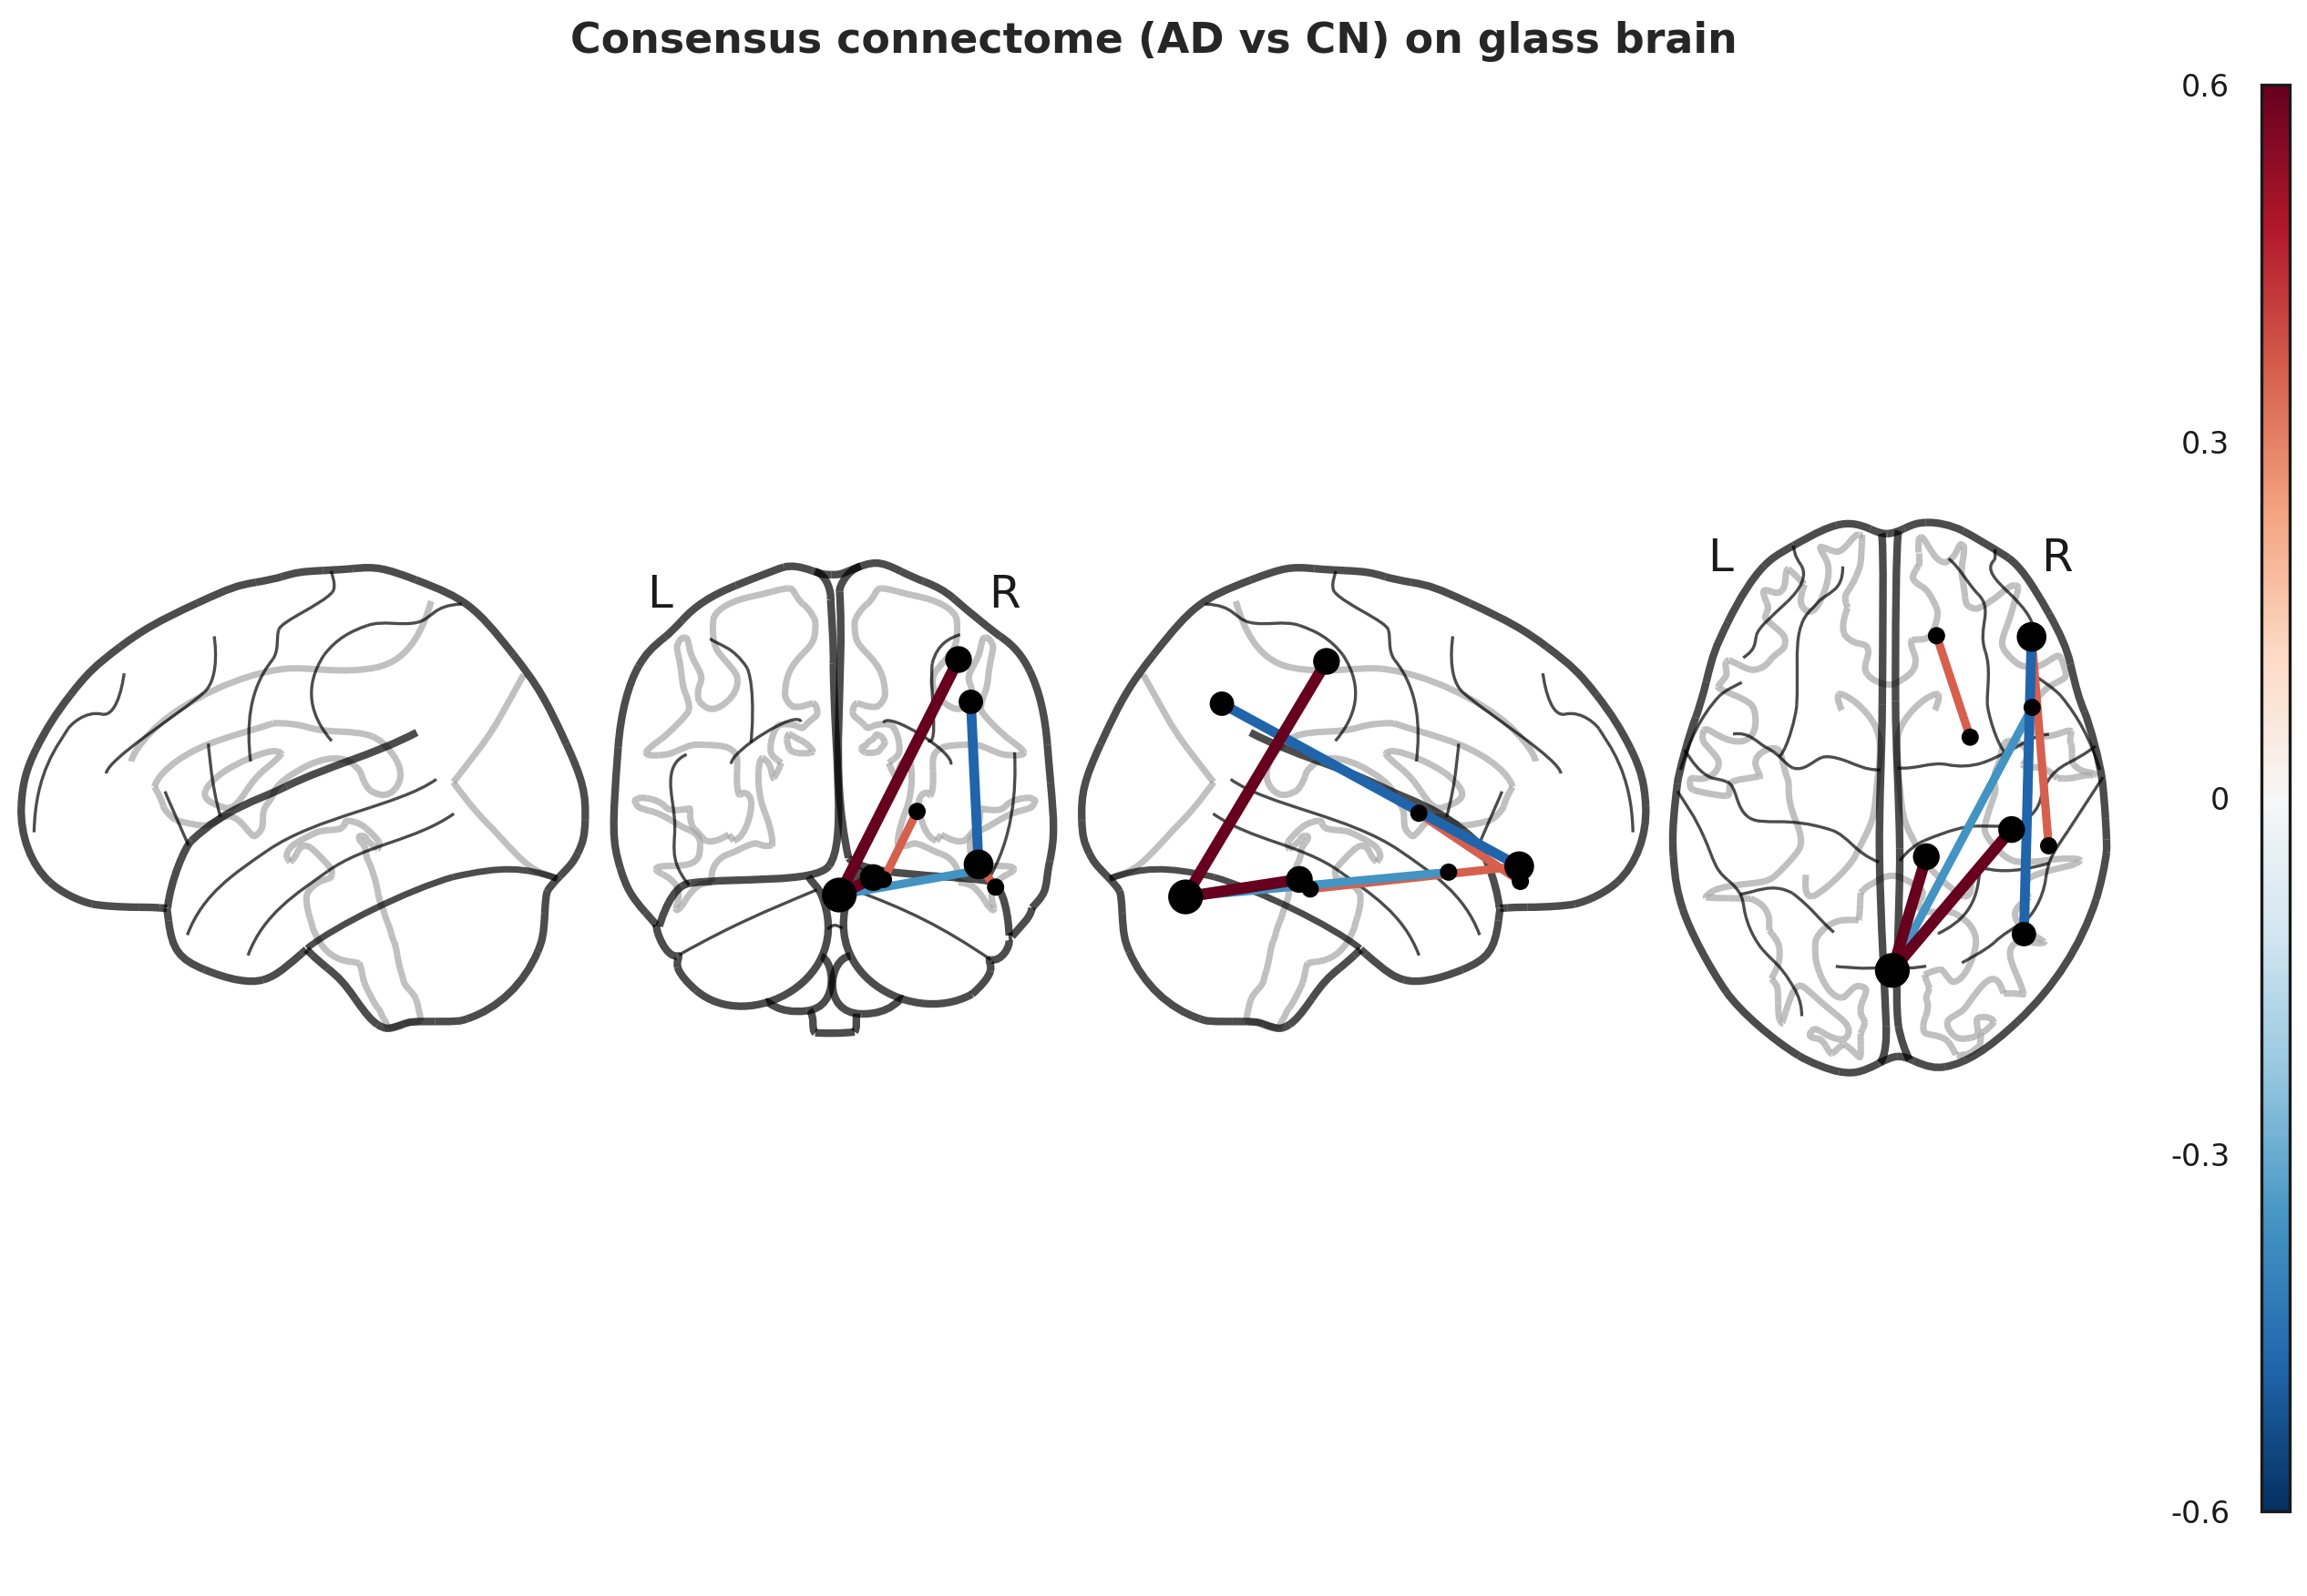

✅ Guardado connectome: Figures_Nature/fig_glass_consensus_SIGNED.[pdf|png|svg]
✅ Guardado node-strength: Figures_Nature/fig_glass_nodestrength_SIGNED.[pdf|png|svg]

Resumen — consenso firmado:
  • Aristas pro-AD (rojo): 4
  • Aristas pro-CN (azul): 2
  • Escala (barra de color) simétrica en ±0.60 (w = π · mean(sign))
  • Tamaño de nodo ∝ Σ|w| (hub robusto); color de mapa nodal firmado (rojo=pro-AD, azul=pro-CN).


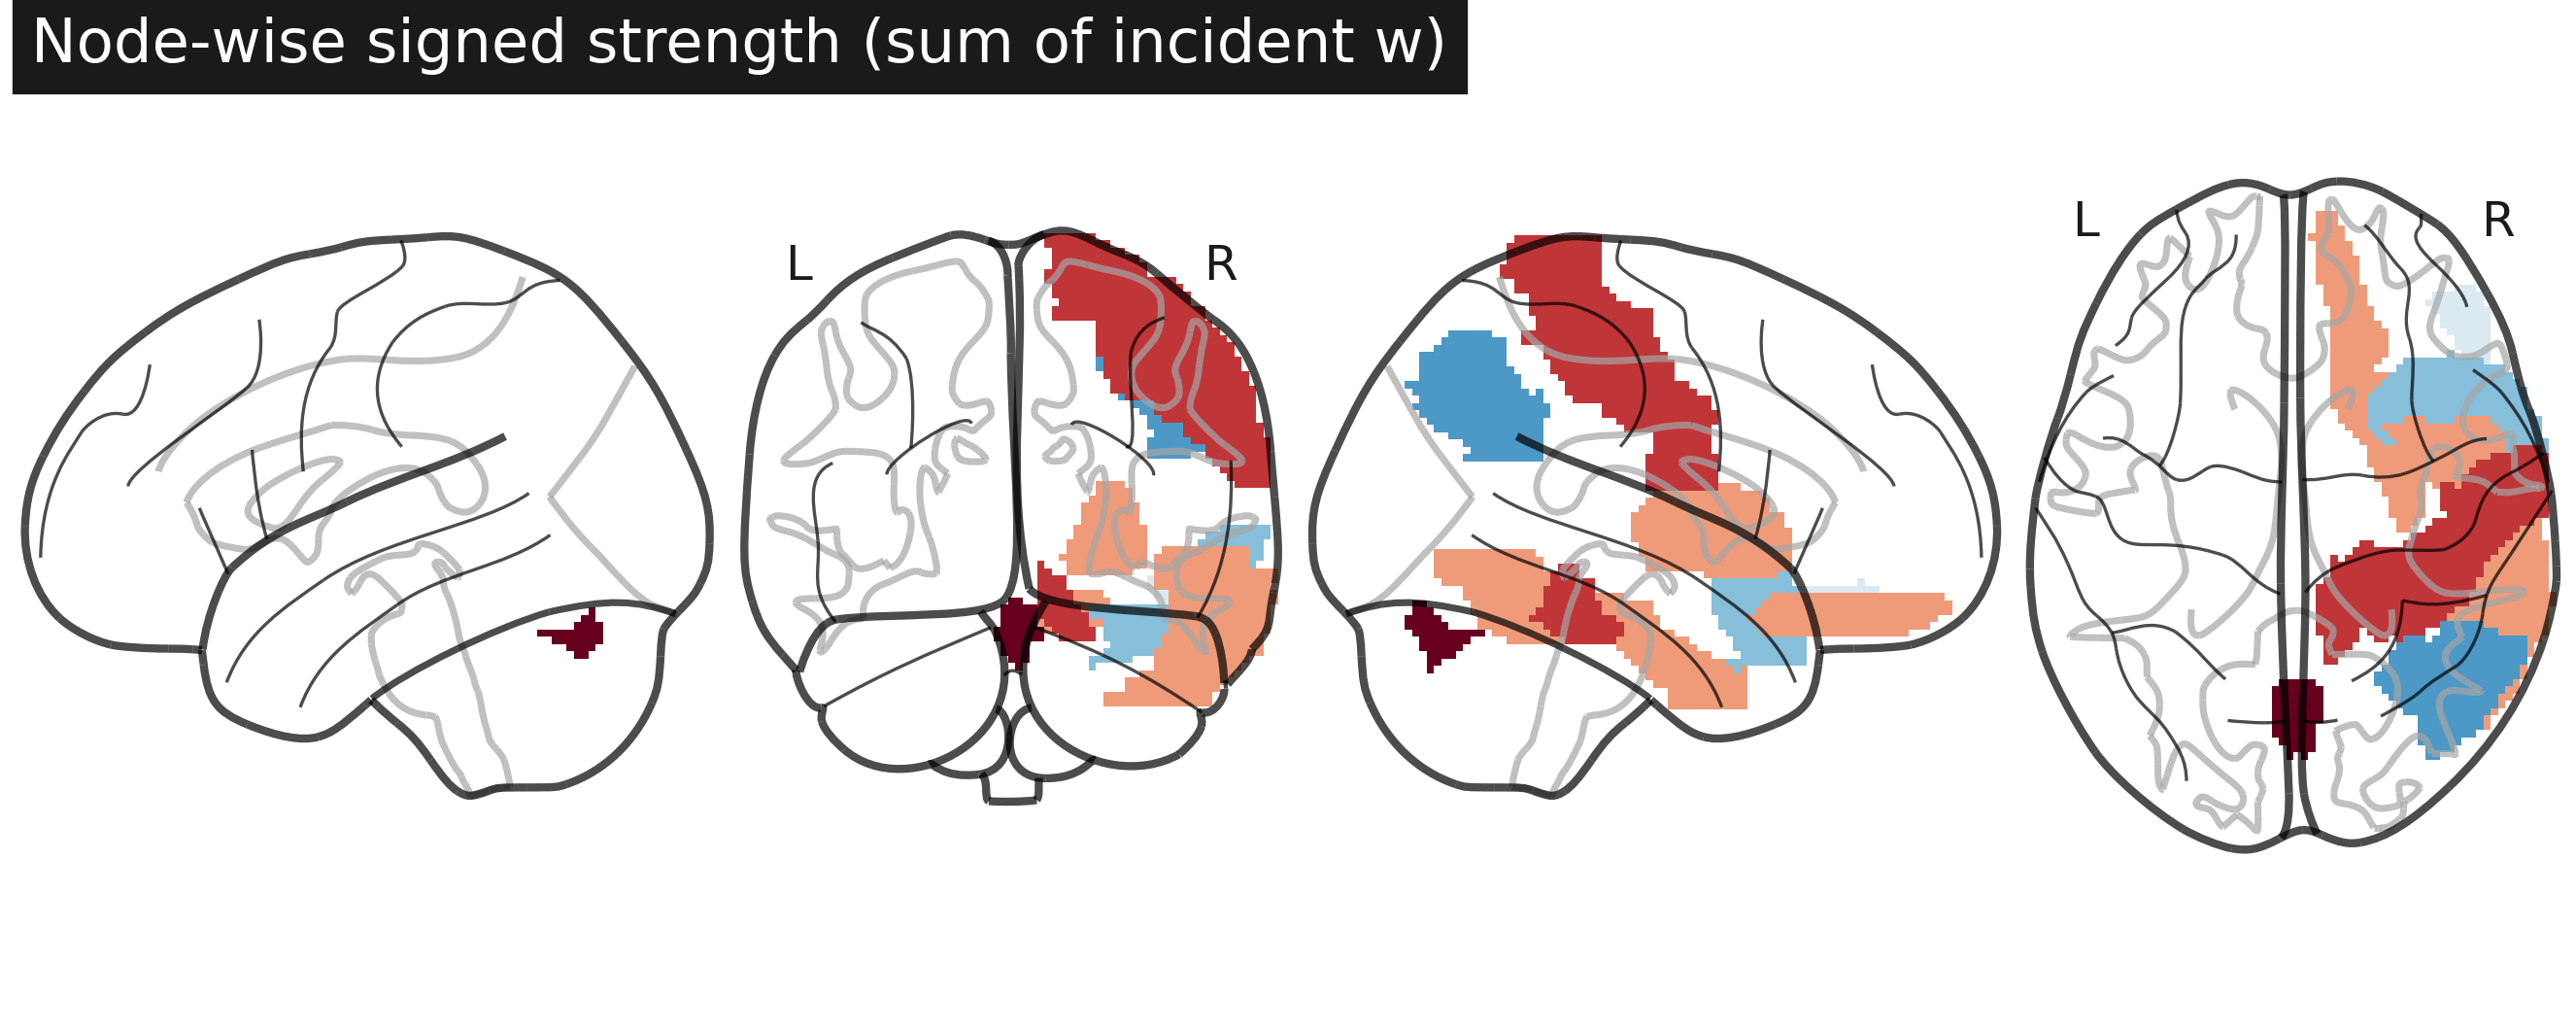

In [ ]:
# ================= GLASS BRAIN — CONSENSUS (versión final, firmado y con leyenda) =================
# Requiere: nilearn, nibabel, scipy.io; variables previas: df_full, savefig_nature, FIG_DIR
# Opcional: consensus_set (si no existe, lo genera con los parámetros abajo)

import re, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import nibabel as nib
from scipy.io import loadmat
import matplotlib.pyplot as plt
from nilearn.image import new_img_like
from nilearn.plotting import plot_connectome, plot_glass_brain, find_xyz_cut_coords

# ------------------------ Parámetros ------------------------
AAL3_DIR = Path("/home/diego/Escritorio/AAL3v1_for_SPM12/AAL3")  # <— ajusta si lo tenés en otro lado
#TOP_K_STABILITY = 250
#CONS_PI, CONS_TAU = 0.6, 0.6     # mismos cortes que venías usando
TITLE = "Consensus connectome (AD vs CN) on glass brain"
#SUBTITLE = r"Edge color: pro-AD (+, red) / pro-CN (–, blue) · weight $w=\pi\cdot\overline{\mathrm{sign}}(S)$, thickness ∝ |w|"
OUT_BASENAME = FIG_DIR / "fig_glass_consensus_SIGNED"

# ------------------------ Utilidades AAL3 ------------------------
def _canon(s: str) -> str:
    return re.sub(r"[^A-Za-z0-9]", "", str(s)).upper()

def _abbr_tokens(name: str) -> str:
    toks = re.split(r"[^A-Za-z0-9]+", name)
    short = []
    for t in toks:
        if not t: continue
        if t.isdigit(): short.append(t)
        elif len(t) <= 3: short.append(t.upper())
        else: short.append(t[:3].upper())
    return "".join(short)

def _load_aal3_paths(aal_dir: Path):
    cand_nii = [aal_dir/"AAL3v1.nii.gz", aal_dir/"AAL3v1.nii", aal_dir/"ROI_MNI_V7.nii"]
    cand_mat = [aal_dir/"ROI_MNI_V7_List.mat", aal_dir/"ROI_MNI_V7_1mm_List.mat"]
    cand_txt = [aal_dir/"AAL3v1.nii.txt", aal_dir/"ROI_MNI_V7_vol.txt"]
    cand_xml = [aal_dir/"AAL3v1.xml", aal_dir/"ROI_MNI_V7.xml"]
    AAL_NII = next((p for p in cand_nii if p.exists()), None)
    AAL_MAT = next((p for p in cand_mat if p.exists()), None)
    AAL_TXT = next((p for p in cand_txt if p.exists()), None)
    AAL_XML = next((p for p in cand_xml if p.exists()), None)
    assert AAL_NII is not None,  "❌ No encuentro el NIfTI del atlas AAL3."
    assert AAL_MAT is not None,  "❌ No encuentro ROI_MNI_V7_List.mat."
    return AAL_NII, AAL_MAT, AAL_TXT, AAL_XML

def _build_name_index(AAL_MAT, AAL_TXT):
    mat = loadmat(str(AAL_MAT))
    ROI_arr = mat["ROI"]
    name2id, canon2id = {}, {}
    for col in range(ROI_arr.shape[1]):
        item = ROI_arr[0, col]
        idx  = int(item["ID"][0][0])
        nomc = str(item["Nom_C"][0]).strip()
        noml = str(item["Nom_L"][0]).strip()
        for nm in {nomc, noml}:
            name2id[nm] = idx
            canon2id[_canon(nm)] = idx
            canon2id[_abbr_tokens(nm)] = idx
    if AAL_TXT and AAL_TXT.exists():
        for line in AAL_TXT.read_text(encoding="utf-8", errors="ignore").splitlines():
            line = line.strip()
            if not line or line.startswith("#"): continue
            parts = re.split(r"\s+", line, maxsplit=1)
            if len(parts) == 2 and parts[0].isdigit():
                idx = int(parts[0]); lbl = parts[1].strip()
                name2id[lbl] = idx
                canon2id[_canon(lbl)] = idx
                canon2id[_abbr_tokens(lbl)] = idx
    return name2id, canon2id

def resolve_roi_to_id(roi_name: str, name2id, canon2id):
    if roi_name in name2id:
        return name2id[roi_name], roi_name
    c = _canon(roi_name)
    if c in canon2id: return canon2id[c], roi_name
    a = _abbr_tokens(roi_name)
    if a in canon2id: return canon2id[a], roi_name
    return None, None

# ------------------------ (A) Consenso firmado ------------------------
# Si ya existe consensus_set, lo usamos; si no, lo construimos con tus cortes.
if 'consensus_set' not in globals():
    # π: frecuencia de aparecer en top-K por fold
    top_sets = (df_full.loc[df_full['Rank'] <= TOP_K_STABILITY]
                      .groupby('fold', observed=True)['connection_id'].apply(set))
    pi = pd.Series({e:0 for s in top_sets for e in s})
    for s in top_sets: 
        for e in s: pi[e] += 1
    pi = (pi / len(top_sets)).rename('pi')

    # τ: consistencia de signo (módulo); signedness: media de signos (con signo)
    S = df_full.set_index(['connection_id','fold'])['Saliency_Signed'].pipe(np.sign).unstack()
    tau = S.mean(axis=1).abs().rename('tau')
    signedness = S.mean(axis=1).fillna(0.0).rename('signedness')  # ∈[-1,1]

    df_stab = pd.concat([pi, tau, signedness], axis=1).fillna({'pi':0.0, 'tau':0.0, 'signedness':0.0})
    consensus_set = (df_stab.query("pi >= @CONS_PI and tau >= @CONS_TAU")
                              .sort_values(['pi','tau'], ascending=False))
else:
    # Si viene de antes, reconstruimos π y signedness para poder firmar el peso
    top_sets = (df_full.loc[df_full['Rank'] <= TOP_K_STABILITY]
                      .groupby('fold', observed=True)['connection_id'].apply(set))
    pi = pd.Series({e:0 for s in top_sets for e in s})
    for s in top_sets:
        for e in s: pi[e] += 1
    pi = (pi / len(top_sets)).rename('pi')
    S = df_full.set_index(['connection_id','fold'])['Saliency_Signed'].pipe(np.sign).unstack()
    signedness = S.mean(axis=1).fillna(0.0).rename('signedness')

    # garantizamos tener las columnas para el índice del consenso actual
    extra = pd.concat([pi, signedness], axis=1).reindex(consensus_set.index)
    consensus_set = consensus_set.assign(
                pi=pi.reindex(consensus_set.index).fillna(0.0),
                signedness=signedness.reindex(consensus_set.index).fillna(0.0)
            )


# Peso firmado: w = pi * signedness  (magnitud = π×τ, signo = pro-AD/pro-CN)
consensus_set = consensus_set.copy()
consensus_set['w_signed'] = (consensus_set['pi'] * consensus_set['signedness']).fillna(0.0)

if len(consensus_set) == 0:
    raise RuntimeError("El consensus_set está vacío tras aplicar los umbrales. Ajustá CONS_PI/CONS_TAU o TOP_K_STABILITY.")

# ------------------------ (B) Mapeo AAL3 → coordenadas MNI ------------------------
AAL_NII, AAL_MAT, AAL_TXT, AAL_XML = _load_aal3_paths(AAL3_DIR)
aal_img = nib.load(str(AAL_NII))
atlas_data = aal_img.get_fdata().astype(int)
name2id, canon2id = _build_name_index(AAL_MAT, AAL_TXT)

# ROI únicos del consenso
roi_names = sorted({roi for (a,b) in consensus_set.index for roi in (a,b)})
resolved_ids, unresolved = {}, []
for nm in roi_names:
    idx, _ = resolve_roi_to_id(nm, name2id, canon2id)
    (resolved_ids.setdefault(nm, idx) if idx is not None else unresolved.append(nm))
if unresolved:
    warnings.warn(f"ROIs sin resolver (no se dibujan): {unresolved}")

def roi_center_mni(label_id: int):
    mask = (atlas_data == int(label_id)).astype(int)
    mask_img = new_img_like(aal_img, mask)
    return find_xyz_cut_coords(mask_img)

roi2coord = {}
for nm, idx in resolved_ids.items():
    try:
        roi2coord[nm] = roi_center_mni(idx)
    except Exception as e:
        warnings.warn(f"No pude sacar coord MNI de {nm} (ID {idx}): {e}")

roi_order = [r for r in roi_names if r in roi2coord]
coords    = [roi2coord[r] for r in roi_order]
if not roi_order:
    raise RuntimeError("Ningún ROI del consenso obtuvo coordenadas MNI válidas.")

# ------------------------ (C) Matriz de adyacencia y atributos nodales ------------------------
def build_adj_from_consensus(roi_order, df_cons, weight_col="w_signed"):
    pos = {r: i for i, r in enumerate(roi_order)}
    n = len(roi_order)
    A = np.zeros((n, n), dtype=float)
    for (a, b), row in df_cons.iterrows():
        if a in pos and b in pos:
            w = float(row[weight_col])
            i, j = pos[a], pos[b]
            A[i, j] = A[j, i] = w
    return A

A = build_adj_from_consensus(roi_order, consensus_set, "w_signed")
if not np.any(A):
    raise RuntimeError("La matriz de adyacencia quedó vacía (w_signed=0 en todas). Revisá los cortes o el origen de signos.")

# fuerza firmada por nodo, y tamaño ∝ sum(|w|)
node_strength_signed = pd.Series(A.sum(axis=1), index=roi_order)
node_strength_abs    = pd.Series(np.abs(A).sum(axis=1), index=roi_order)

# ⇩ NUEVO: re-escalado suave y rango más chico
S = node_strength_abs.to_numpy()
S = (S - S.min()) / (S.max() - S.min() + 1e-12)   # [0,1]
NODE_MIN, NODE_MAX = 14, 70                        # antes: ~80–1000
node_sizes = np.clip(NODE_MIN + (NODE_MAX - NODE_MIN) * np.sqrt(S), NODE_MIN, NODE_MAX)


# ------------------------ (D) Figura — connectome + nodos ------------------------
vmax = float(np.abs(A).max())
fig = plt.figure(figsize=(8.4, 5.8))

disp = plot_connectome(
    adjacency_matrix=A,
    node_coords=coords,
    node_color="black",
    node_size=node_sizes,
    edge_cmap="RdBu_r",
    edge_vmin=-vmax, edge_vmax=vmax,
    colorbar=True,
    display_mode="lyrz",
    figure=fig
)

plt.suptitle(TITLE, y=0.99, fontsize=11, weight='bold')
#plt.title(SUBTITLE, fontsize=9)

# Guardado (PDF/PNG/SVG)
if "savefig_nature" in globals():
    savefig_nature(fig, OUT_BASENAME)
fig.savefig(str(OUT_BASENAME) + ".svg", format="svg", bbox_inches="tight")
plt.show()

# ------------------------ (E) Mapa nodal en glass brain (opcional, complementa el panel) ------------------------
stat_vol = np.zeros_like(atlas_data, dtype=float)
for roi_name in roi_order:
    idx = resolved_ids[roi_name]
    stat_vol[atlas_data == int(idx)] = node_strength_signed[roi_name]  # firmado (pro-AD rojo / pro-CN azul)

stat_img = new_img_like(aal_img, stat_vol)
disp2 = plot_glass_brain(
    stat_img, plot_abs=False, threshold=0, display_mode="lyrz",
    cmap="RdBu_r", black_bg=False, symmetric_cbar=True,
    title="Node-wise signed strength (sum of incident w)", vmax=np.nanmax(np.abs(stat_vol))
)

# Guardados
base2 = FIG_DIR / "fig_glass_nodestrength_SIGNED"
if "savefig_nature" in globals():
    disp2.savefig(str(base2) + ".pdf")
    disp2.savefig(str(base2) + ".png", dpi=300)
disp2.savefig(str(base2) + ".svg")

print("✅ Guardado connectome:", str(OUT_BASENAME) + ".[pdf|png|svg]")
print("✅ Guardado node-strength:", str(base2) + ".[pdf|png|svg]")

# ------------------------ (F) Mini-resumen para tu director (impreso en consola) ------------------------
n_pos = int((A >  0).sum() // 2)
n_neg = int((A <  0).sum() // 2)
print(f"\nResumen — consenso firmado:")
print(f"  • Aristas pro-AD (rojo): {n_pos}")
print(f"  • Aristas pro-CN (azul): {n_neg}")
print(f"  • Escala (barra de color) simétrica en ±{vmax:.2f} (w = π · mean(sign))")
print(f"  • Tamaño de nodo ∝ Σ|w| (hub robusto); color de mapa nodal firmado (rojo=pro-AD, azul=pro-CN).")


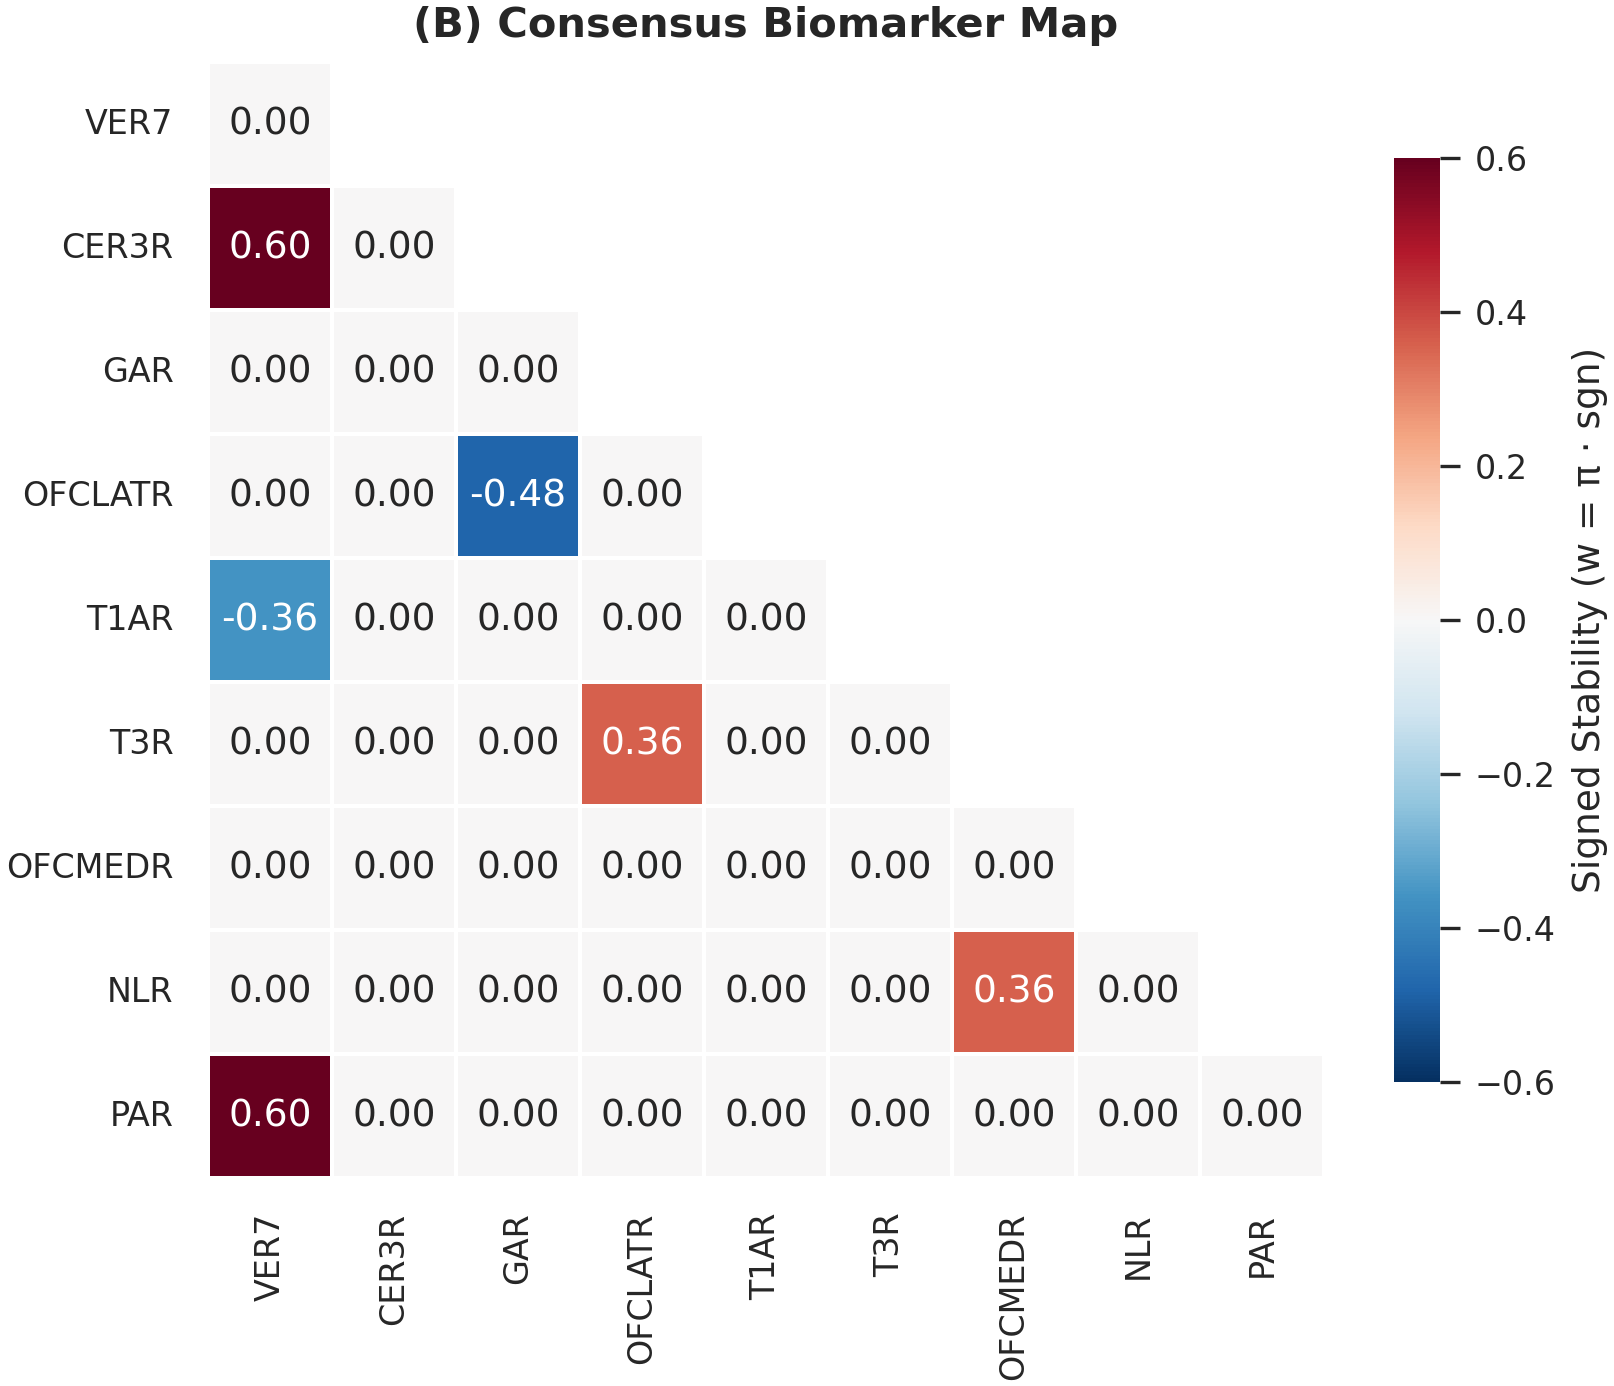

✅ Figura del Panel B (CORREGIDA Y FIRMADA) guardada en: Figures_Nature/figure_B_consensus_map_SIGNED.svg


In [ ]:
# ===================================================================
# CELDA PARA FIGURA B: Consensus Biomarker Map (CORREGIDA CON SIGNOS)
# ===================================================================

# --- Configuración ---
FIG_B_NAME = "figure_B_consensus_map_SIGNED"

# --- 1. Preparación de Datos ---
# ««« CORREGIDO: Usar 'w_signed' (calculado en la celda del glass brain)
#     en lugar de 'Signed' (que era solo la magnitud pi*tau).
#     Asegúrate de que la celda "GLASS BRAIN — CONSENSUS" se haya ejecutado primero.
assert 'consensus_set' in globals() and 'w_signed' in consensus_set.columns, \
    "Ejecuta la celda 'GLASS BRAIN — CONSENSUS' primero para generar 'w_signed'."
    
mat_B_data = consensus_set['w_signed'].copy() # ««« USA LA VARIABLE CON SIGNO

rois_B = sorted(list(set(roi for conn_tuple in mat_B_data.index for roi in conn_tuple)))
mat_B = pd.DataFrame(0.0, index=rois_B, columns=rois_B)

for (src, dst), signed_weight in mat_B_data.items():
    if src in mat_B.index and dst in mat_B.columns:
        mat_B.loc[src, dst] = signed_weight
    if dst in mat_B.index and src in mat_B.columns:
        mat_B.loc[dst, src] = signed_weight # Simétrica

# --- 2. Reordenar por Red (sin cambios) ---
if 'roi2net' not in globals():
    net_src_col = 'src_Refined_Network' if 'src_Refined_Network' in df_full.columns else 'src_Yeo17_Network'
    net_dst_col = 'dst_Refined_Network' if 'dst_Refined_Network' in df_full.columns else 'dst_Yeo17_Network'
    roi2net = {}
    for _, r in df_full[['src_AAL3_Name', net_src_col]].dropna().drop_duplicates().iterrows():
        roi2net[r['src_AAL3_Name']] = r[net_src_col]
    for _, r in df_full[['dst_AAL3_Name', net_dst_col]].dropna().drop_duplicates().iterrows():
        roi2net.setdefault(r['dst_AAL3_Name'], r[net_dst_col])

roi_order_df = pd.DataFrame({'ROI': rois_B, 'Network': [roi2net.get(r, 'Unknown') for r in rois_B]})
roi_order_df = roi_order_df.sort_values(by=['Network', 'ROI'])
network_ordered_rois = roi_order_df['ROI'].tolist()
mat_B = mat_B.reindex(index=network_ordered_rois, columns=network_ordered_rois)

# --- 3. Máscara (sin cambios) ---
mask = np.triu(np.ones_like(mat_B, dtype=bool), k=1)

# --- 4. Generación del Gráfico (CORREGIDO) ---
fig_B, ax_B = plt.subplots(figsize=(6, 5))

# ««« CORREGIDO: Ajustar la escala de color para que sea divergente
vmax = float(np.abs(mat_B.values).max()) # Obtener el máximo (ej: 0.6)
if vmax < 1e-9: vmax = 0.6 # Fallback
vmin = -vmax

sns.heatmap(
    mat_B, 
    mask=mask,
    cmap="RdBu_r",      # ««« CORREGIDO: Mapa de color divergente
    vmin=vmin,         # ««« CORREGIDO: vmin
    vmax=vmax,         # ««« CORREGIDO: vmax
    center=0.0,        # ««« CORREGIDO: Centrado en 0
    square=True, 
    cbar_kws={'label': 'Signed Stability (w = π ⋅ sgn)', 'shrink': 0.8}, # ««« ETIQUETA CORREGIDA
    ax=ax_B, 
    linewidths=.5, 
    linecolor='white',
    annot=True,
    fmt=".2f"
)
ax_B.set_title("(B) Consensus Biomarker Map", weight="bold")
ax_B.set_xlabel("")
ax_B.set_ylabel("")
ax_B.tick_params(axis='x', rotation=90)
ax_B.tick_params(axis='y', rotation=0)

# --- Guardado en SVG ---
output_path_B = FIG_DIR / f"{FIG_B_NAME}.svg"
fig_B.savefig(output_path_B, format='svg', bbox_inches="tight")
plt.show()
print(f"✅ Figura del Panel B (CORREGIDA Y FIRMADA) guardada en: {output_path_B}")

In [ ]:
# ========================== OPCIÓN A — CONSENSO POR SALIENCIA ==========================
# Define un set de aristas "biomarcadoras" usando:
#   π = frecuencia de aparición en el top-K por fold
#   τ = consistencia de signo de la saliencia (promedio de signos |mean|)

import numpy as np, pandas as pd
from collections import Counter
from pathlib import Path

# --- Parámetros (puedes ajustar) ---
#TOP_K_STABILITY = 250
#CONS_PI, CONS_TAU = 0.6, 0.6  # umbrales del consenso
TBL_DIR = Path('./Tables_Nature'); TBL_DIR.mkdir(parents=True, exist_ok=True)

assert 'df_full' in globals(), "df_full no está definido (cargá tus rankings primero)."
assert 'N_FOLDS' in globals(), "N_FOLDS no está definido."

# 1) Frecuencia π en top-K
top_sets = (
    df_full.loc[df_full['Rank'] <= TOP_K_STABILITY]
           .groupby('fold', observed=True)['connection_id']
           .apply(set)
)
pi = pd.Series(Counter(e for s in top_sets for e in s)).div(len(top_sets)).rename('pi')

# 2) Consistencia de signo τ a partir de 'Saliency_Signed'
sign = np.sign(
    df_full.set_index(['connection_id','fold'])['Saliency_Signed']
          .unstack()  # col=fold
)
tau = sign.mean(axis=1).abs().rename('tau')

df_stability_sal = pd.concat([pi, tau], axis=1).fillna({'pi':0.0})
df_stability_sal['Signed'] = df_stability_sal['pi'] * df_stability_sal['tau']

# 3) Consenso por saliencia
consensus_sal = (
    df_stability_sal
    .query("pi >= @CONS_PI and tau >= @CONS_TAU")
    .sort_values('Signed', ascending=False)
)

print(f"🔎 Opción A (Saliencia): {len(consensus_sal)} aristas con π≥{CONS_PI}, τ≥{CONS_TAU}")
display(consensus_sal.head(12))

# 4) Export
out_a = TBL_DIR / f"consensus_edges_saliency_topK{TOP_K_STABILITY}_pi{CONS_PI}_tau{CONS_TAU}.csv"
consensus_sal.reset_index().to_csv(out_a, index=False)
print("💾 Guardado:", out_a)

# Deja en globals para usar en la otra celda
CONS_PARAMS = {'TOP_K': TOP_K_STABILITY, 'PI': CONS_PI, 'TAU': CONS_TAU}


🔎 Opción A (Saliencia): 6 aristas con π≥0.6, τ≥0.6


pi  tau  Signed
PAR     VER7     0.6  1.0    0.60
CER3R   VER7     0.6  1.0    0.60
GAR     OFCLATR  0.8  0.6    0.48
T1AR    VER7     0.6  0.6    0.36
OFCLATR T3R      0.6  0.6    0.36
NLR     OFCMEDR  0.6  0.6    0.36

💾 Guardado: Tables_Nature/consensus_edges_saliency_topK250_pi0.6_tau0.6.csv


In [ ]:
# ========================== OPCIÓN B — CONSENSO POR COHEN'S d ==========================
# Define el set por tamaño de efecto "real" en TEST por fold:
#   - calcula d(AD − CN) por conexión y por fold (en TEST)
#   - define π_d = frecuencia de aparecer en top-K de |d|
#   - define τ_d = consistencia del signo de d
#   - aplica los mismos umbrales (π, τ) y compara con Opción A

import numpy as np, pandas as pd
from collections import Counter
from pathlib import Path

# --- Parámetros (alineados con la opción A) ---
#TOP_K_STABILITY = CONS_PARAMS.get('TOP_K', 250) if 'CONS_PARAMS' in globals() else 250
CONS_PI  = CONS_PARAMS.get('PI', 0.6)  if 'CONS_PARAMS' in globals() else 0.6
CONS_TAU = CONS_PARAMS.get('TAU', 0.6) if 'CONS_PARAMS' in globals() else 0.6
TBL_DIR = Path('./Tables_Nature'); TBL_DIR.mkdir(parents=True, exist_ok=True)

# --- Requisitos del entorno ---
for v in ['df_full','N_FOLDS','BASE_RUN_DIR','cnad_df','global_tensor_data','CHANNELS_TO_USE']:
    assert v in globals(), f"Falta variable requerida: {v}"


# --- Necesitamos (idx_i, idx_j) para mapear cada connection_id a índices (i,j) ---
if not {"idx_i","idx_j"}.issubset(df_full.columns):
    raise KeyError("df_full debe contener columnas 'idx_i' e 'idx_j' (usa la versión ANOTADO).")

conn_map = (
    df_full[['connection_id','idx_i','idx_j']]
    .drop_duplicates('connection_id')
    .set_index('connection_id')
    .astype(int)
)

# --- Preparación tensor/metadata alineados al NPZ ---
# (asumimos que cnad_df ya fue creado como en tu Celda 0)
# Ya tenemos en cnad_df la columna tensor_idx y etiqueta ResearchGroup_Mapped

# --- Cálculo de d por fold (TEST) ---
cohen_per_fold = []

for f in range(1, N_FOLDS + 1):
    test_idx_path = BASE_RUN_DIR / f"fold_{f}" / "test_indices.npy"
    if not test_idx_path.exists():
        print(f"⚠️ Falta test_indices en fold {f}: {test_idx_path}. Omito fold.")
        continue

    test_rows = cnad_df.iloc[np.load(test_idx_path)]
    ad_idx = test_rows.query("ResearchGroup_Mapped=='AD'")['tensor_idx'].to_numpy()
    cn_idx = test_rows.query("ResearchGroup_Mapped=='CN'")['tensor_idx'].to_numpy()

    if len(ad_idx) < 2 or len(cn_idx) < 2:
        print(f"⚠️ Muy pocos sujetos en TEST para fold {f}. Omito.")
        continue

    # valores por conexión: promedio sobre canales seleccionados
    rows = []
    for conn, (i, j) in conn_map.iterrows():
        vals_all = global_tensor_data[:, CHANNELS_TO_USE, i, j].mean(axis=1)  # [n_subj]
        dval = cohen_d(vals_all[ad_idx], vals_all[cn_idx])
        rows.append((conn, dval))

    df_fold_d = pd.DataFrame(rows, columns=['connection_id', f'd_fold_{f}']).set_index('connection_id')
    cohen_per_fold.append(df_fold_d)

if not cohen_per_fold:
    raise RuntimeError("No se pudo calcular d en ningún fold. Revisa test_indices y metadatos.")

df_d_all = pd.concat(cohen_per_fold, axis=1)

# --- Frecuencia π_d de aparecer en top-K |d| y consistencia τ_d del signo ---
# π_d: aristas que entran al top-K de |d| en cada fold
top_sets_d = []
for col in df_d_all.columns:
    s = df_d_all[col].abs().sort_values(ascending=False).head(TOP_K_STABILITY)
    top_sets_d.append(set(s.index))

pi_d = pd.Series(Counter(e for s in top_sets_d for e in s)).div(len(top_sets_d)).rename('pi')

# τ_d: consistencia del signo
sign_d = np.sign(df_d_all)
tau_d = sign_d.mean(axis=1).abs().rename('tau')

df_stability_d = pd.concat([pi_d, tau_d], axis=1).fillna({'pi':0.0})
df_stability_d['Signed'] = df_stability_d['pi'] * df_stability_d['tau']

# --- Consenso por d ---
consensus_d = (
    df_stability_d
    .query("pi >= @CONS_PI and tau >= @CONS_TAU")
    .sort_values('Signed', ascending=False)
)

print(f"🔎 Opción B (Cohen's d): {len(consensus_d)} aristas con π≥{CONS_PI}, τ≥{CONS_TAU}")
display(consensus_d.head(12))

# --- Export ---
out_b = TBL_DIR / f"consensus_edges_effectsize_topK{TOP_K_STABILITY}_pi{CONS_PI}_tau{CONS_TAU}.csv"
consensus_d.reset_index().to_csv(out_b, index=False)
print("💾 Guardado:", out_b)

# ================== COMPARACIÓN RÁPIDA ENTRE AMBAS OPCIONES ==================
if 'consensus_sal' in globals() and len(consensus_sal) > 0:
    A = set(consensus_sal.index)
    B = set(consensus_d.index)
    inter = A & B
    union  = A | B
    jacc   = (len(inter) / len(union)) if union else np.nan
    print(f"\n📊 Comparación:")
    print(f"  • |A| Saliencia = {len(A)}")
    print(f"  • |B| d        = {len(B)}")
    print(f"  • Overlap      = {len(inter)}")
    print(f"  • Jaccard      = {jacc:.3f}")

    # correlación de magnitudes |saliencia| vs |d| en el overlap
    sal_mean = df_full.groupby('connection_id')['Saliency_Signed'].mean().rename('sal_mean')
    d_mean   = df_d_all.mean(axis=1).rename('d_mean')
    comp_df  = pd.concat([sal_mean.abs(), d_mean.abs()], axis=1).dropna().loc[list(inter)]
    if len(comp_df) >= 3:
        from scipy.stats import spearmanr
        rho, p = spearmanr(comp_df['sal_mean'], comp_df['d_mean'])
        print(f"  • Spearman ρ(|sal|,|d|) en overlap = {rho:.2f} (p={p:.2g})")

    # Export del overlap (útil para suplementario)
    overlap_path = TBL_DIR / "consensus_overlap_edges.csv"
    pd.DataFrame(sorted(inter), columns=['connection_id']).to_csv(overlap_path, index=False)
    print("💾 Overlap exportado en:", overlap_path)
else:
    print("\nℹ️ No encontré 'consensus_sal' en memoria. Corré la celda de Opción A primero para comparar.")


🔎 Opción B (Cohen's d): 7 aristas con π≥0.6, τ≥0.6


pi  tau  Signed
O1L    PQL     0.6  1.0    0.60
CER10R PQL     0.6  1.0    0.60
PQL    V1L     0.6  1.0    0.60
CER3R  INR     0.6  1.0    0.60
       HIPPOR  0.6  1.0    0.60
PQL    T1L     0.6  0.6    0.36
O1R    PQL     0.6  0.6    0.36

💾 Guardado: Tables_Nature/consensus_edges_effectsize_topK250_pi0.6_tau0.6.csv

📊 Comparación:
  • |A| Saliencia = 6
  • |B| d        = 7
  • Overlap      = 0
  • Jaccard      = 0.000
💾 Overlap exportado en: Tables_Nature/consensus_overlap_edges.csv


Iniciando cálculo de PRI (Folds=5, Puntos=7, Random=20)...
  Procesando Fold 1/5...
  Procesando Fold 2/5...
  Procesando Fold 3/5...
  Procesando Fold 4/5...
  Procesando Fold 5/5...
...Cálculo de degradación completo.

PRI por fold (z-score, >0 = explicaciones con alta fidelidad):


fold  AUDC_sal  AUDC_rand  PRI_z
0     1  0.004912   0.000781   8.53
1     2  0.006096   0.000200   8.79
2     3  0.008596   0.000402  21.53
3     4  0.007931   0.001276  15.45
4     5  0.002972   0.001008   4.07

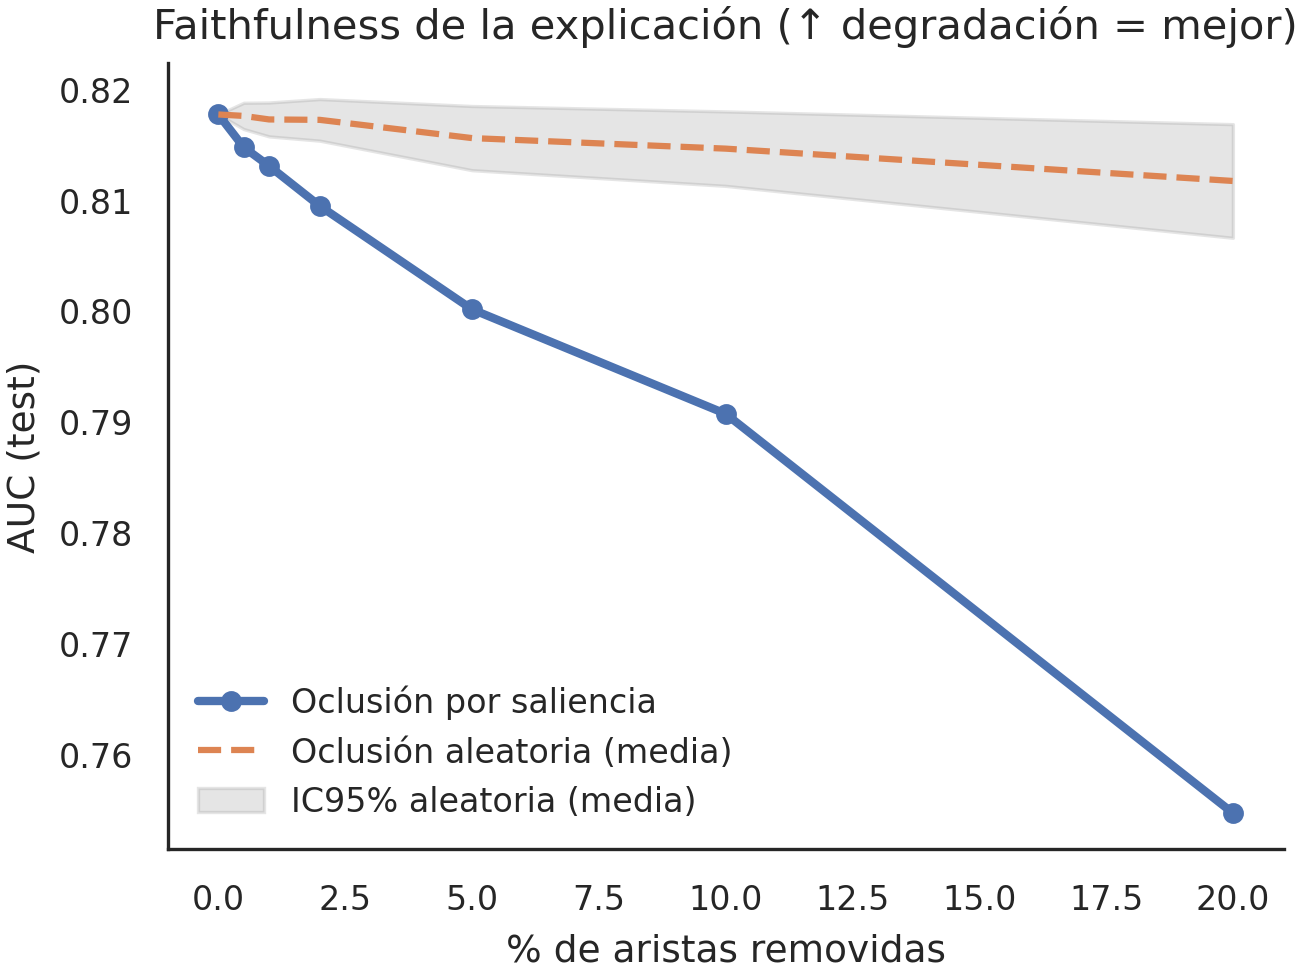

In [ ]:
# =================== CELDA 26 — PATTERN RECOGNITION INDEX (PRI) [REFACTORIZADA] ===================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import joblib
from sklearn.metrics import roc_auc_score
from scipy.stats import t
from models.convolutional_vae2 import ConvolutionalVAE
from serentipia9_qc_beta import apply_normalization_params

# --- 1. CONFIGURACIÓN ---
PERCENTS = [0, 0.5, 1, 2, 5, 10, 20]  # % del total de aristas removidas
N_RANDOM = 20                        # corridas aleatorias para IC95
MASK_VALUE = 0.0                     # valor de oclusión
R = global_tensor_data.shape[-1]
ALL_EDGES = [(i,j) for i in range(R) for j in range(i+1,R)]
N_EDGES = len(ALL_EDGES)

# --- 2. FUNCIONES AUXILIARES ---

def mask_edges_raw(tensor_raw, edges_to_zero):
    """
    Aplica máscara a un tensor 'raw' ANTES de normalizar.
    
    Parámetros:
    ----------
    tensor_raw : np.array [n_subj, n_chan_sel, R, R]
        Tensor ya filtrado a los canales de interés (p.ej. CHANNELS_TO_USE).
    edges_to_zero : list of tuples
        Lista de (i,j) a enmascarar.
        
    Devuelve:
    -------
    np.array
        Nuevo tensor con (i,j) y (j,i) puestos a MASK_VALUE en todos los canales.
    """
    X = tensor_raw.copy()
    # Enmascaramos todos los canales presentes en el tensor (que ya fue filtrado)
    for (i,j) in edges_to_zero:
        X[:, :, i, j] = MASK_VALUE # Usar ':' para todos los canales
        X[:, :, j, i] = MASK_VALUE
    return X

def get_auc_after_mask(fold: int, edges_to_zero: list) -> float:
    """
    Calcula el AUC en el test-set de un fold, pero aplicando una
    máscara de oclusión a las aristas en 'edges_to_zero'.
    
    Esta función depende de variables globales (estilo notebook):
    BASE_RUN_DIR, CLF, run_args, CHANNELS_TO_USE, fold_indices,
    cnad_df, global_tensor_data, device.
    """
    try:
        # --- a. Cargar modelos y datos del fold ---
        fold_dir = BASE_RUN_DIR / f"fold_{fold}"
        pipe = joblib.load(fold_dir / f"classifier_{CLF}_pipeline_fold_{fold}.joblib")
        
        vae_model = ConvolutionalVAE(
            input_channels=len(CHANNELS_TO_USE),
            latent_dim=run_args['latent_dim'],
            image_size=R,
            num_conv_layers_encoder=run_args['num_conv_layers_encoder'],
            decoder_type=run_args['decoder_type'],
            final_activation=run_args['vae_final_activation'],
            intermediate_fc_dim_config=run_args['intermediate_fc_dim_vae'],
            dropout_rate=run_args['dropout_rate_vae'],
            use_layernorm_fc=run_args['use_layernorm_vae_fc']
        ).to(device)
        
        vae_model.load_state_dict(torch.load(fold_dir / f"vae_model_fold_{fold}.pt", map_location=device))
        vae_model.eval()
        norm_params = joblib.load(fold_dir / "vae_norm_params.joblib")

        # --- b. Preparar datos de test ---
        test_idx = fold_indices[fold]['test']
        df_te = cnad_df.iloc[test_idx]
        y_true = df_te['ResearchGroup_Mapped'].map({'CN':0,'AD':1}).values

        if len(np.unique(y_true)) < 2:
            return np.nan # No se puede calcular AUC

        gidx = df_te['tensor_idx'].values
        Xraw = global_tensor_data[gidx][:, CHANNELS_TO_USE, :, :]
        
        # --- c. Aplicar máscara (en RAW) y normalizar ---
        Xraw_mask = mask_edges_raw(Xraw, edges_to_zero)
        Xnorm = apply_normalization_params(Xraw_mask, norm_params)

        # --- d. Pipeline VAE -> Latente ---
        with torch.no_grad():
            mu, _ = vae_model.encode(torch.from_numpy(Xnorm).float().to(device))
            Z = mu.cpu().numpy()

        # --- e. Pipeline Metadata -> Clasificador ---
        meta_cols = run_args['metadata_features']
        meta_te = df_te[meta_cols].copy()
        if 'Sex' in meta_cols:
            meta_te['Sex'] = meta_te['Sex'].map({'M':0,'F':1,'m':0,'f':1})
        
        # Imputación simple (debería coincidir con la del pipeline, esto es un fallback)
        for c in meta_cols:
            if meta_te[c].isnull().any():
                val = meta_te[c].median() if pd.api.types.is_numeric_dtype(meta_te[c]) else meta_te[c].mode().iloc[0]
                meta_te[c] = meta_te[c].fillna(val)

        X = np.hstack([Z, meta_te[meta_cols].values])
        
        # --- f. Predicción y AUC ---
        y_prob = pipe.predict_proba(X)[:,1]
        return roc_auc_score(y_true, y_prob)

    except Exception as e:
        print(f"Error en get_auc_after_mask (fold {fold}, {len(edges_to_zero)} aristas): {e}")
        return np.nan

def _area_deg(vs_percent, auc0, auc_vec):
    """Calcula área sobre la curva de degradación (AUDC)."""
    deg = np.maximum(auc0 - np.array(auc_vec), 0.0)
    x = np.array(vs_percent)/100.0
    return np.trapz(deg, x)

# --- 3. SCRIPT PRINCIPAL: Cálculo de degradación ---

print(f"Iniciando cálculo de PRI (Folds={N_FOLDS}, Puntos={len(PERCENTS)}, Random={N_RANDOM})...")
rows = []
rng = np.random.default_rng(SEED) # Usar la semilla global

for f in range(1, N_FOLDS+1):
    print(f"  Procesando Fold {f}/{N_FOLDS}...")
    # a. Baseline (sin máscara)
    auc0 = get_auc_after_mask(f, [])
    
    # b. Ranking de saliencia (específico del fold)
    df_f = df_full[df_full['fold'] == f].sort_values('Rank')
    ranked_edges = df_f[['idx_i','idx_j']].drop_duplicates().to_records(index=False)
    ranked_edges = [(int(i),int(j)) for i,j in ranked_edges]

    for p in PERCENTS:
        K = int(round(p/100.0 * N_EDGES))
        
        # c. Oclusión por saliencia
        topK = ranked_edges[:K] if K>0 else []
        auc_top = get_auc_after_mask(f, topK)
        
        # d. Oclusión aleatoria (N_RANDOM veces)
        auc_rands = []
        for _ in range(N_RANDOM):
            rand_indices = rng.choice(len(ALL_EDGES), size=K, replace=False) if K>0 else []
            edges_rand = [ALL_EDGES[i] for i in rand_indices] if K>0 else []
            auc_rands.append(get_auc_after_mask(f, edges_rand))
        
        auc_rand_mean = np.nanmean(auc_rands) if len(auc_rands) else auc0
        auc_rand_sd   = np.nanstd(auc_rands, ddof=1) if len(auc_rands)>1 else 0.0
        ci_t = t.ppf(0.975, df=max(len(auc_rands)-1, 1))
        ci = ci_t * (auc_rand_sd / np.sqrt(max(len(auc_rands), 1)))

        rows.append({
            'fold': f, 'percent': p, 'AUC0': auc0,
            'AUC_sal': auc_top, 'AUC_rand_mean': auc_rand_mean, 'AUC_rand_ci95': ci
        })

df_pri = pd.DataFrame(rows)
print("...Cálculo de degradación completo.")

# --- 4. CÁLCULO DE ÍNDICE PRI (AUDC) ---

pri_rows = []
for f, g in df_pri.groupby('fold'):
    auc0 = g['AUC0'].iloc[0]
    area_sal = _area_deg(g['percent'], auc0, g['AUC_sal'])
    area_rnd = _area_deg(g['percent'], auc0, g['AUC_rand_mean'])
    
    # z-score usando la amplitud del IC como ruido (aprox conservadora)
    sd_rnd_auc = (g['AUC_rand_ci95'].abs().max() / t.ppf(0.975, df=max(N_RANDOM-1,1))) if (g['AUC_rand_ci95']>0).any() else 1e-6
    # Asumimos que el "ruido" en el área es proporcional al ruido en AUC
    sd_rnd_area = sd_rnd_auc * (PERCENTS[-1]/100.0) # Escala por el rango de X
    
    PRI_z = (area_sal - area_rnd) / max(sd_rnd_area, 1e-6)
    
    pri_rows.append({'fold': f, 'AUDC_sal': area_sal, 'AUDC_rand': area_rnd, 'PRI_z': PRI_z})

df_PRI = pd.DataFrame(pri_rows)
print("\nPRI por fold (z-score, >0 = explicaciones con alta fidelidad):")
display(df_PRI.assign(PRI_z=lambda d: d['PRI_z'].round(2)))

# --- 5. FIGURA: Curva AUC vs % removido (promedio de folds) ---

plot_df = (
    df_pri
    .groupby('percent', as_index=False)
    .agg(
        AUC_sal=('AUC_sal','mean'),
        AUC_rand_mean=('AUC_rand_mean','mean'),
        # Promediar el CI95 es una aproximación visual razonable
        AUC_rand_ci95_mean=('AUC_rand_ci95','mean') 
    )
)

fig, ax = plt.subplots(figsize=(4.8,3.4))
ax.plot(plot_df['percent'], plot_df['AUC_sal'], lw=2, label='Oclusión por saliencia', marker='o', markersize=4)
ax.plot(plot_df['percent'], plot_df['AUC_rand_mean'], lw=1.5, ls='--', label='Oclusión aleatoria (media)')
ax.fill_between(plot_df['percent'],
                plot_df['AUC_rand_mean'] - plot_df['AUC_rand_ci95_mean'],
                plot_df['AUC_rand_mean'] + plot_df['AUC_rand_ci95_mean'],
                alpha=0.2, label='IC95% aleatoria (media)', color='gray')

ax.set_xlabel('% de aristas removidas'); ax.set_ylabel('AUC (test)')
ax.set_title('Faithfulness de la explicación (↑ degradación = mejor)')
ax.legend(frameon=False)
savefig_nature(fig, FIG_DIR / "figure_E_PRI_foldwise")
plt.show()

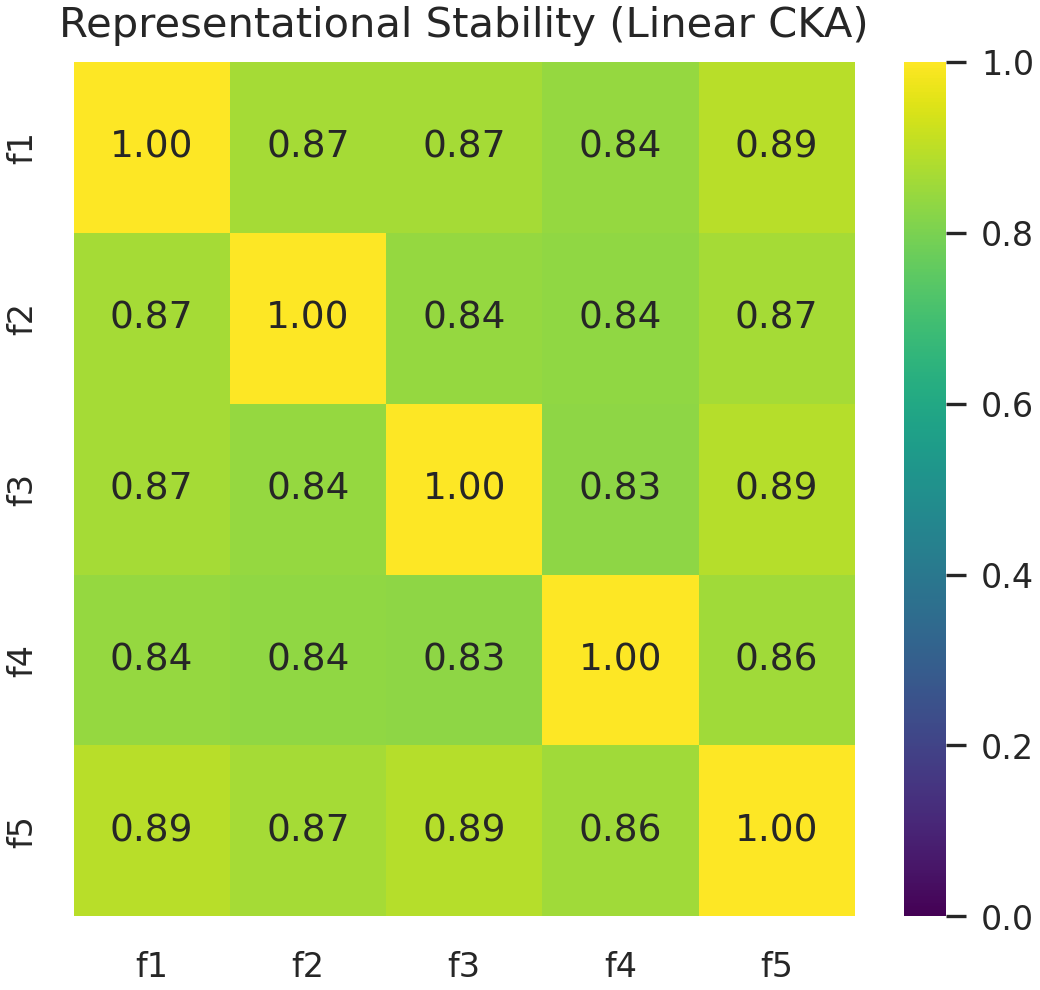

CKA medio fuera de la diagonal: 0.8585070652435556


In [ ]:
# =============== CELDA — CKA ENTRE FOLDS (LATENT REPRESENTATION) ===============
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns

def linear_cka(X, Y):
    # X:[n,d], Y:[n,d2], centrado implícito mediante Gram centrado
    def _center_gram(K):
        n = K.shape[0]
        H = np.eye(n) - np.ones((n,n))/n
        return H @ K @ H
    K = X @ X.T
    L = Y @ Y.T
    Kc, Lc = _center_gram(K), _center_gram(L)
    hsic = np.sum(Kc*Lc)
    norm = np.sqrt(np.sum(Kc*Kc) * np.sum(Lc*Lc)) + 1e-12
    return float(hsic / norm)

# Codificamos TODOS los CN/AD con cada VAE
Z_by_fold = {}
for f in range(1, N_FOLDS+1):
    fold_dir = BASE_RUN_DIR / f"fold_{f}"
    vae_model = ConvolutionalVAE(
        input_channels=len(CHANNELS_TO_USE),
        latent_dim=run_args['latent_dim'],
        image_size=global_tensor_data.shape[-1],
        num_conv_layers_encoder=run_args['num_conv_layers_encoder'],
        decoder_type=run_args['decoder_type'],
        final_activation=run_args['vae_final_activation'],
        intermediate_fc_dim_config=run_args['intermediate_fc_dim_vae'],
        dropout_rate=run_args['dropout_rate_vae'],
        use_layernorm_fc=run_args['use_layernorm_vae_fc']
    ).to(device)
    vae_model.load_state_dict(torch.load(fold_dir / f"vae_model_fold_{f}.pt", map_location=device))
    vae_model.eval()
    norm_params = joblib.load(fold_dir / "vae_norm_params.joblib")

    gidx = cnad_df['tensor_idx'].values
    Xraw = global_tensor_data[gidx][:, CHANNELS_TO_USE, :, :]
    Xnorm = apply_normalization_params(Xraw, norm_params)
    with torch.no_grad():
        mu, _ = vae_model.encode(torch.from_numpy(Xnorm).float().to(device))
        Z_by_fold[f] = mu.cpu().numpy()

# Matriz CKA (fold x fold)
F = sorted(Z_by_fold.keys())
M = np.zeros((len(F), len(F)))
for i, fi in enumerate(F):
    for j, fj in enumerate(F):
        M[i,j] = linear_cka(Z_by_fold[fi], Z_by_fold[fj])

fig, ax = plt.subplots(figsize=(4.2,3.7))
sns.heatmap(M, vmin=0, vmax=1, cmap='viridis', annot=True, fmt=".2f",
            xticklabels=[f"f{f}" for f in F], yticklabels=[f"f{f}" for f in F], ax=ax)
ax.set_title("Representational Stability (Linear CKA)")
# 1. Guardar TODAS las versiones de la figura PRIMERO
savefig_nature(fig, FIG_DIR / "fig5_latent_cka") # Guarda .pdf y .png
plt.savefig(FIG_DIR / "figure_F_CKA_grid.png", dpi=300) # Guarda la copia para la Fig 3F
plt.savefig(FIG_DIR / "figure_F_CKA_grid.pdf")      # Guarda la copia para la Fig 3F

# 2. Mostrar la figura DESPUÉS de haberla guardado
plt.show()

# --- FIN DE LA CORRECCIÓN ---

print("CKA medio fuera de la diagonal:", np.nanmean(M[np.triu_indices_from(M,1)]))


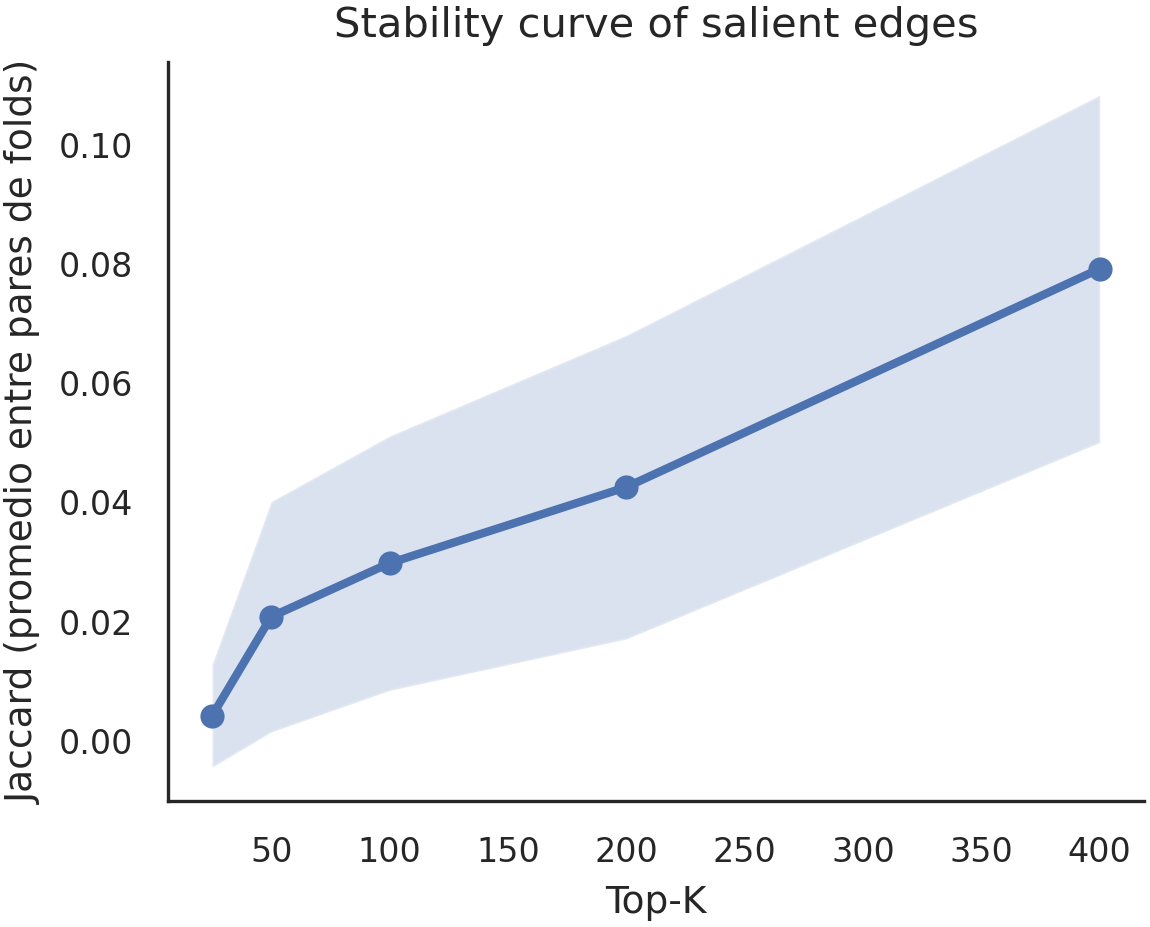

Jaccard_mean @K=200: 0.04249517925094489
Jaccard_sd   @K=200: 0.02548734385579494
Detalle de estabilidad @K=50:
    K  Jaccard_mean  Jaccard_sd
1  50      0.020732    0.019345
Concordancia de ranking (Kendall τ) top-500: 0.12


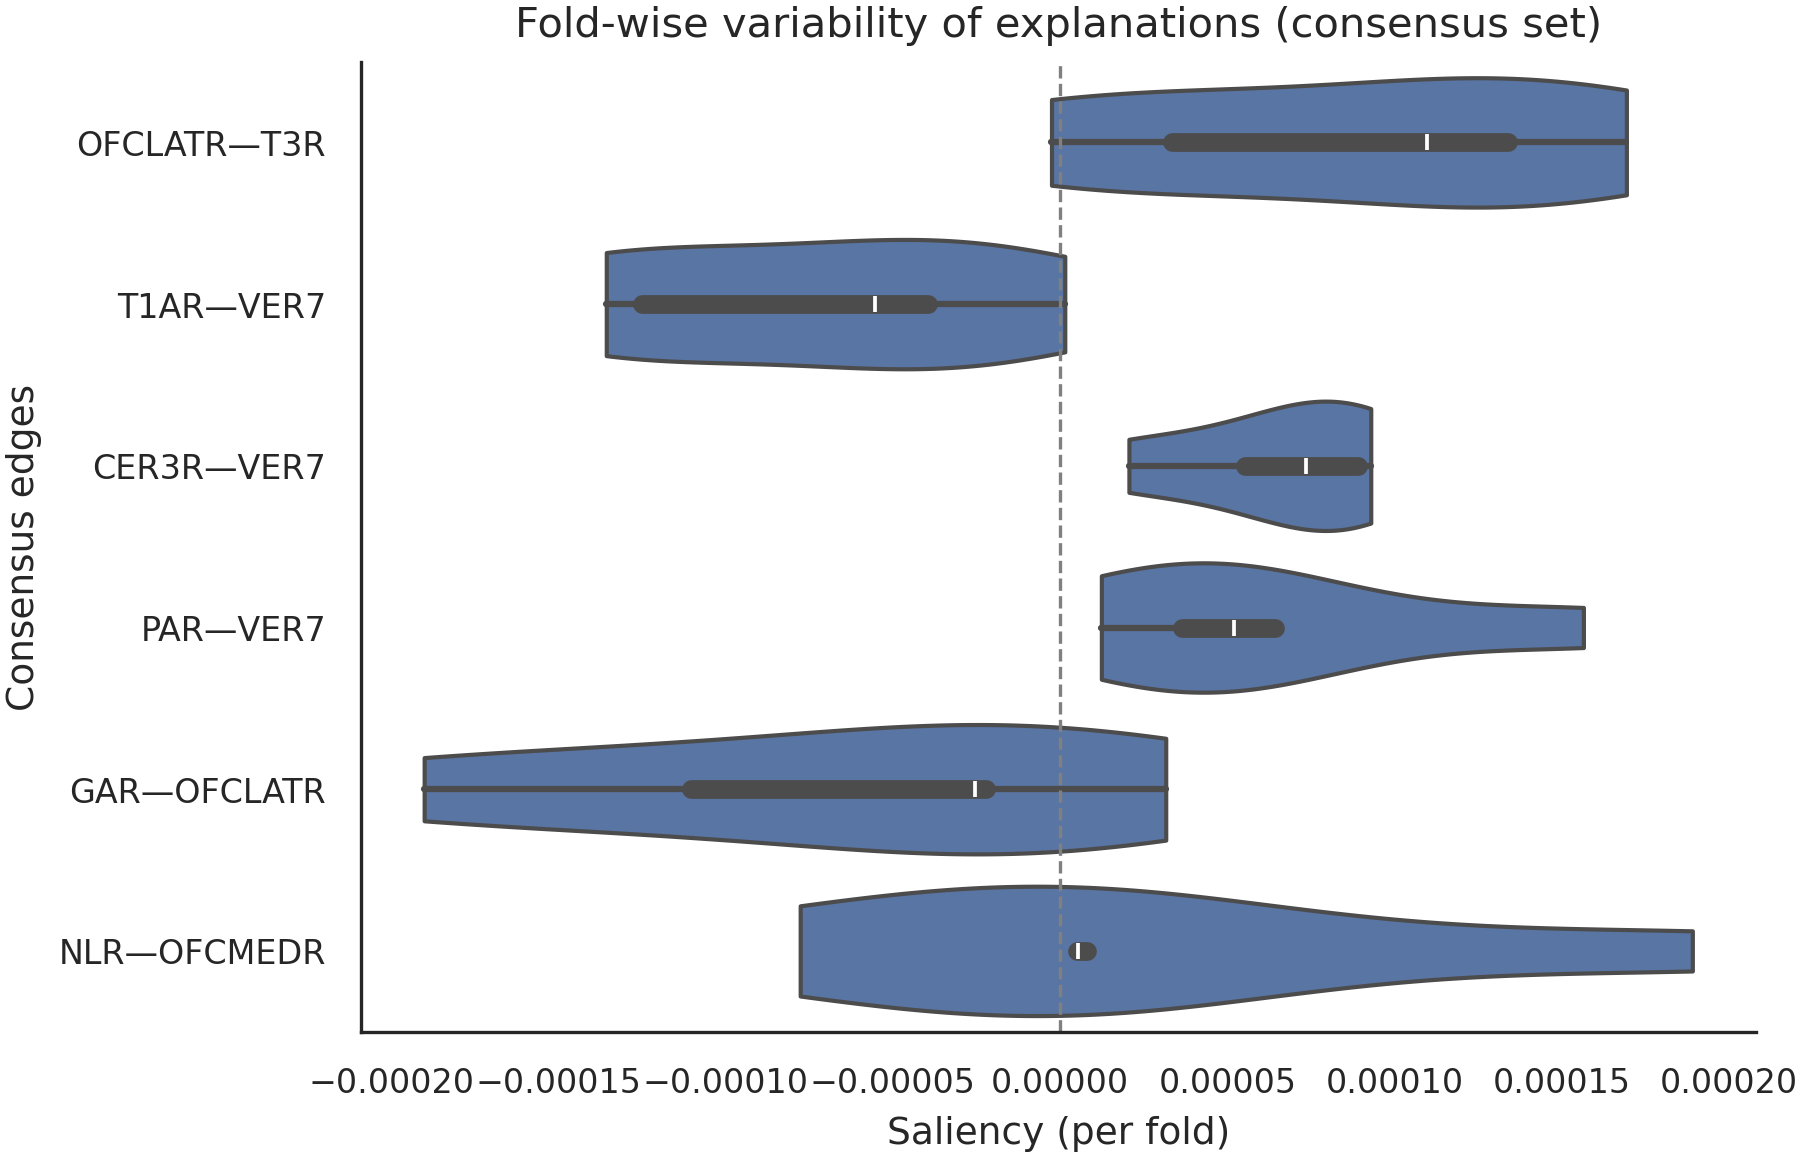

In [ ]:
# ======= CELDA 28 — VARIABILIDAD DE INTERPRETABILIDAD (CORREGIDA) =======
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import kendalltau

# --- 1) Curvas de estabilidad de ranking: Jaccard(top-K) promedio entre pares de folds ---
Kgrid = [25, 50, 100, 200, 400]
pair_vals = {K: [] for K in Kgrid}

for f1, f2 in combinations(range(1, N_FOLDS+1), 2):
    r1 = df_full[df_full['fold']==f1].sort_values('Rank').drop_duplicates('connection_id')
    r2 = df_full[df_full['fold']==f2].sort_values('Rank').drop_duplicates('connection_id')
    s1 = r1['connection_id'].tolist()
    s2 = r2['connection_id'].tolist()
    
    for K in Kgrid:
        A = set(s1[:K]); B = set(s2[:K])
        j = len(A&B) / max(len(A|B),1)
        pair_vals[K].append(j)

stab_df = pd.DataFrame({
    'K': Kgrid,
    'Jaccard_mean': [np.mean(pair_vals[K]) for K in Kgrid],
    'Jaccard_sd':   [np.std(pair_vals[K], ddof=1) if len(pair_vals[K]) > 1 else 0 for K in Kgrid]
})

fig, ax = plt.subplots(figsize=(4.2,3.2))
ax.plot(stab_df['K'], stab_df['Jaccard_mean'], lw=2, marker='o')
ax.fill_between(stab_df['K'],
                stab_df['Jaccard_mean'] - stab_df['Jaccard_sd'],
                stab_df['Jaccard_mean'] + stab_df['Jaccard_sd'], alpha=0.2)
ax.set_xlabel('Top-K'); ax.set_ylabel('Jaccard (promedio entre pares de folds)')
ax.set_title('Stability curve of salient edges')
savefig_nature(fig, FIG_DIR / "fig6_stability_curve_jaccard")
plt.show()

print("Jaccard_mean @K=200:", stab_df.loc[stab_df['K']==200, 'Jaccard_mean'].values[0])
print("Jaccard_sd   @K=200:", stab_df.loc[stab_df['K']==200, 'Jaccard_sd'].values[0])
print("Detalle de estabilidad @K=50:")
print(stab_df[stab_df['K'] == 50])

# --- 2) Concordancia de ranking: Kendall τ / W para un conjunto común de aristas ---
TOPM = 500

# universo = intersección de aristas presentes en todos los folds
edges_all = [set(df_full[df_full['fold']==f]['connection_id']) for f in range(1, N_FOLDS+1)]
univ = sorted(set.intersection(*edges_all))

# tomamos TOPM por ranking de un fold de referencia y restringimos al universo
ref = (df_full[df_full['fold']==1].sort_values('Rank')
       .query("connection_id in @univ").head(TOPM)['connection_id'].tolist())

E = ref if len(ref)>=TOPM else univ[:TOPM]

# rank matrix: rows=edges, cols=folds
Rmat = np.zeros((len(E), N_FOLDS), dtype=int)
for j, f in enumerate(range(1, N_FOLDS+1)):
    r = (df_full[df_full['fold']==f]
         .set_index('connection_id')['Rank'].to_dict())
    Rmat[:, j] = [r.get(e, len(r)+1) for e in E]

# Kendall tau promedio entre columnas
taus = []
for a,b in combinations(range(N_FOLDS),2):
    t,_ = kendalltau(Rmat[:,a], Rmat[:,b])
    taus.append(t)
tau_mean = np.nanmean(taus)
print(f"Concordancia de ranking (Kendall τ) top-{TOPM}: {tau_mean:.2f}")

# --- 3) Forest/violin: dispersión por fold de las aristas del consenso ---
cons = consensus_set.index.tolist()
df_forest = (df_full[df_full['connection_id'].isin(cons)]
             .groupby(['connection_id','fold'])['Saliency_Signed'].mean().reset_index())

# --- INICIO DE CORRECCIÓN ---
# Convertir 'connection_id' (tupla) a string para evitar error de MultiIndex en Seaborn
df_forest['connection_id_str'] = df_forest['connection_id'].apply(lambda t: f"{t[0]}—{t[1]}")

# ordenar por |media| (usando el nuevo 'connection_id_str' para agrupar)
order = (df_forest.groupby('connection_id_str')['Saliency_Signed'].mean()
         .abs().sort_values(ascending=False).index.tolist())

fig, ax = plt.subplots(figsize=(6,4.2))

# *** BUG CORREGIDO AQUÍ: Usar y='connection_id_str' en lugar de y='connection_id' ***
sns.violinplot(data=df_forest, 
               y='connection_id_str',  # <-- CORREGIDO
               x='Saliency_Signed',
               order=order, 
               inner='box', 
               cut=0, 
               scale='width', 
               ax=ax)
# --- FIN DE CORRECCIÓN ---

ax.axvline(0, ls='--', c='gray', lw=0.8)
ax.set_ylabel('Consensus edges'); ax.set_xlabel('Saliency (per fold)')
ax.set_title('Fold-wise variability of explanations (consensus set)')
savefig_nature(fig, FIG_DIR / "fig6_variability_violin_consensus")
plt.show()

In [ ]:
# Permutación nula para consenso por saliencia
from collections import Counter
rng = np.random.default_rng(42)
N=131; E = N*(N-1)//2
F=5; K=250; PI_TH, TAU_TH = 0.6, 0.6
iters=2000
counts=[]
for _ in range(iters):
    top_sets=[set(rng.choice(E, size=K, replace=False)) for _ in range(F)]
    # π: frecuencia
    pi = Counter(e for s in top_sets for e in s)
    for k in pi: pi[k] /= F
    # τ: consistencia de signo (aleatoria; media de ±1)
    # con signos iid simétricos, |mean(sign)| ~ distribución de Rademacher;
    # aproximamos tau con |(sum s)/F|, s∈{−1,1}
    # Para ser conservadores, muestreamos:
    tau = {e: abs(np.mean(rng.choice([-1,1], size=F))) for e in pi.keys()}
    signed = sum(1 for e in pi if (pi[e] >= PI_TH and tau[e] >= TAU_TH))
    counts.append(signed)
null_ge = np.mean(np.array(counts) >= 6)  # 11 = tu consenso observado
print("p_nulo (#aristas ≥ observadas) =", null_ge)


p_nulo (#aristas ≥ observadas) = 0.0


In [ ]:
def cross_counts(df, K):
    top = df[df["Rank"]<=K]
    inter = top[(top.hemi_src!='U') & (top.hemi_dst!='U') & (top.hemi_src!=top.hemi_dst)]
    rl = ((inter.hemi_src=='R') & (inter.hemi_dst=='L')).sum()
    lr = ((inter.hemi_src=='L') & (inter.hemi_dst=='R')).sum()
    return rl, lr, len(inter)
for K in (50,100,200):
    rl, lr, n = cross_counts(df_full.assign(hemi_src=df_full['hemi_src'],hemi_dst=df_full['hemi_dst']), K)
    print(f"K={K}: R→L={rl}, L→R={lr}, total inter={n}")


K=50: R→L=49, L→R=31, total inter=134
K=100: R→L=113, L→R=71, total inter=294
K=200: R→L=208, L→R=162, total inter=580


In [ ]:
from scipy.stats import spearmanr
rho, pval = spearmanr(df_consensus_analysis["mean_saliency"].abs(),
                      df_consensus_analysis["mean_cohen_d"].abs())
print(f"ρ(|sal|,|d|) = {rho:.3f},  p = {pval:.3g}")


ρ(|sal|,|d|) = 0.657,  p = 0.156


In [ ]:
# —— Medias y rango por fold de acc_site_* y chance_level ——
cols = [c for c in ['acc_site_raw','acc_site_latent','chance_level'] if c in df_qc_summary.columns]
print(df_qc_summary[cols].describe().loc[['mean','min','max']].round(3))


      acc_site_raw  acc_site_latent  chance_level
mean         0.296            0.327          0.25
min          0.222            0.212          0.25
max          0.349            0.422          0.25


In [ ]:
from pathlib import Path
import re, numpy as np, pandas as pd

# === CONFIG ===
TBL_DIR = Path("Tables_Nature")
CONS_TEX_IN  = TBL_DIR / "consensus_edges.tex"                # tu archivo actual
CONS_TEX_OUT = TBL_DIR / "consensus_edges_ANNOTATED.tex"      # salida formateada
ROI_INFO_CSV = Path("roi_info_master.csv")                    # <-- ajusta ruta si hace falta

# === 1) ROI master: detectar la columna "long name" de forma robusta ===
roi_df = pd.read_csv(ROI_INFO_CSV)
assert "AAL3_Name" in roi_df.columns, "roi_info_master.csv debe tener columna 'AAL3_Name'"
print(f"Columnas en roi_info_master.csv: {roi_df.columns.tolist()}")

# candidatos comunes a "nombre largo"
long_candidates = [c for c in roi_df.columns
                   if c.lower() in {"aal3_fullname","aal3_long","longname","name_long","nom_l","label_long"}
                   or ("long" in c.lower() and "name" in c.lower())]

if not long_candidates:
    raise ValueError("No encuentro columna de 'nombre largo' en roi_info_master.csv. "
                     "Renombra/duplica una como 'AAL3_LongName' o similar.")
LONG_COL = long_candidates[0]
roi_df = roi_df[["AAL3_Name", LONG_COL]].drop_duplicates()
roi_df.columns = ["AAL3_Name", "AAL3_LongName"]

# helper lateralidad
midline_tokens = {'VER','VPL','PAG','NCR','tVPL','VER7','VER8','VER9'}
def hemi_of(roi: str) -> str:
    if not isinstance(roi, str): return 'U'
    if roi.endswith('R'): return 'R'
    if roi.endswith('L'): return 'L'
    base = ''.join([c for c in roi if not c.isdigit()])
    return 'M' if any(t in base for t in midline_tokens) else 'U'

# === 2) Parsear tu consensus_edges.tex (filas "src & dst & netpair & pi & tau \\")
rows = []
for line in CONS_TEX_IN.read_text(encoding="utf-8").splitlines():
    line = line.strip()
    if not line or line.startswith("%"): 
        continue
    if not line.endswith(r"\\"):
        continue
    parts = [p.strip() for p in line[:-2].split("&")]
    if len(parts) < 5:
        # tolerar líneas con espacios raros
        parts = [p.strip() for p in re.split(r"\s*&\s*", line[:-2])]
    if len(parts) != 5:
        continue
    src, dst, netpair, pi, tau = parts
    try:
        pi = float(pi); tau = float(tau)
    except:
        # Si hay algo raro, intentamos limpiar comas decimales
        pi = float(str(pi).replace(",", ".")); tau = float(str(tau).replace(",", "."))
    rows.append((src, dst, netpair, pi, tau))

if not rows:
    raise RuntimeError("No pude parsear ninguna fila desde consensus_edges.tex")

cons_df = pd.DataFrame(rows, columns=["src","dst","net_pair","pi","tau"])

# === 3) Anotaciones: nombre largo, lateralidad, redes separadas ===
# a) nombres largos
cons_df = (cons_df
           .merge(roi_df.rename(columns={"AAL3_Name":"src"}), on="src", how="left")
           .rename(columns={"AAL3_LongName":"src_long"}))
cons_df = (cons_df
           .merge(roi_df.rename(columns={"AAL3_Name":"dst"}), on="dst", how="left")
           .rename(columns={"AAL3_LongName":"dst_long"}))

# b) lateralidad y par hemisférico
cons_df["hemi_src"] = cons_df["src"].map(hemi_of)
cons_df["hemi_dst"] = cons_df["dst"].map(hemi_of)
cons_df["hemi_pair"] = cons_df["hemi_src"] + "–" + cons_df["hemi_dst"]

# c) separar par de redes si viene como "NetA—NetB"
if "—" in "".join(cons_df["net_pair"].astype(str).tolist()):
    cons_df[["net_src","net_dst"]] = cons_df["net_pair"].str.split("—", n=1, expand=True)
else:
    # fallback: todo junto si no hay separador largo
    cons_df["net_src"] = cons_df["net_pair"]
    cons_df["net_dst"] = cons_df["net_pair"]

# === 4) (Opcional) Dirección pro-AD / pro-CN desde df_full si existe en memoria ===
direction = []
if "df_full" in globals():
    # firma por conexión = mean(sign(Saliency_Signed)) entre folds
    # construimos ID canónico (tupla ordenada) para matchear
    tmp = df_full.copy()
    tmp["connection_id"] = [tuple(sorted(x)) for x in zip(tmp["src_AAL3_Name"], tmp["dst_AAL3_Name"])]
    sgn = (np.sign(tmp.set_index(["connection_id","fold"])["Saliency_Signed"])
             .unstack().mean(axis=1).reindex(
                 [tuple(sorted(x)) for x in cons_df[["src","dst"]].to_numpy()]
             ))
    for val in sgn:
        if pd.isna(val): direction.append("")
        elif val > 0:    direction.append("pro-AD")
        elif val < 0:    direction.append("pro-CN")
        else:            direction.append("")
else:
    direction = [""]*len(cons_df)

cons_df["direction"] = direction

# ordenar por estabilidad firmada (si no la tenés, usa pi*tau)
cons_df["Signed"] = cons_df["pi"]*cons_df["tau"]
cons_df = cons_df.sort_values(["Signed","pi","tau"], ascending=[False,False,False]).reset_index(drop=True)

# === 5) Export lindo a LaTeX (tabularx) ===
def _tex_esc(s): 
    return ("" if pd.isna(s) else str(s).replace("_", r"\_"))

# columnas finales (puedes ajustar)
cons_df["roi_short"] = cons_df.apply(lambda r: rf"\texttt{{{_tex_esc(r['src'])}—{_tex_esc(r['dst'])}}}", axis=1)
cons_df["roi_long"]  = cons_df.apply(lambda r: rf"{_tex_esc(r['src_long'])} — {_tex_esc(r['dst_long'])}", axis=1)

latex_lines = []
latex_lines.append(r"\begin{tabularx}{\textwidth}{@{} l L L l l c c c @{}}")
latex_lines.append(r"\toprule")
latex_lines.append(r"\textbf{\#} & \textbf{ROI (short)} & \textbf{ROI (long)} & \textbf{Net src} & \textbf{Net dst} & \textbf{Hem.} & $\boldsymbol{\pi}$ & $\boldsymbol{\tau}$ \\")
latex_lines.append(r"\midrule")

for i, r in cons_df.iterrows():
    latex_lines.append(
        rf"{i+1} & {r['roi_short']} & {r['roi_long']} & "
        rf"{_tex_esc(r['net_src'])} & {_tex_esc(r['net_dst'])} & "
        rf"{_tex_esc(r['hemi_pair'])} & {r['pi']:.2f} & {r['tau']:.2f} \\"
    )

latex_lines.append(r"\bottomrule")
latex_lines.append(r"\end{tabularx}")

# preámbulo para el tipo de columna L (parrafos)
PREAMBLE_HINT = (
    "% En el preámbulo del .tex asegúrate de tener:\n"
    "% \\usepackage{booktabs}\n"
    "% \\usepackage{tabularx}\n"
    "% \\newcolumntype{L}{>{\\raggedright\\arraybackslash}X}\n"
)

CONS_TEX_OUT.write_text("\n".join(latex_lines), encoding="utf-8")
print("✅ Tabla LaTeX anotada →", CONS_TEX_OUT.resolve())
print(PREAMBLE_HINT)


Columnas en roi_info_master.csv: ['ROI_TensorIdx', 'Original_Index_0_N', 'AAL3_Name', 'Hemisphere', 'ROI_BaseName', 'Pair_ID', 'Macro_Lobe', 'AAL3_FullName', 'Refined_Network', 'Refined_Short', 'Yeo17_Network', 'Yeo17_Short', 'Overlap_Percent', 'AAL3_Vol_mm3', 'AAL3_Vol_Vox']
✅ Tabla LaTeX anotada → /home/diego/Escritorio/limpio/Tables_Nature/consensus_edges_ANNOTATED.tex
% En el preámbulo del .tex asegúrate de tener:
% \usepackage{booktabs}
% \usepackage{tabularx}
% \newcolumntype{L}{>{\raggedright\arraybackslash}X}

